# 基于编码器和解码器的时间序列预测

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.fft as fft
import os
from tqdm import tqdm # 打印进度条
import math
from einops import rearrange, repeat, reduce
from scipy.fftpack import next_fast_len
import matplotlib.pyplot as plt
import functools
from functools import partial, wraps
from sympy import Poly, legendre, Symbol, chebyshevt
from scipy.special import eval_legendre
from scipy import signal
from torch.nn.modules.linear import Linear
from operator import mul
from typing import List
from pandas.tseries import offsets
from pandas.tseries.frequencies import to_offset
import joblib
# 两种绘图接口
import plotly_express as px
import plotly.graph_objects as go

import warnings

warnings.filterwarnings("ignore")

## 编码-解码器

编码—解码模型主要由编码器和解码器组成，编码器和解码器实际上都是一个神经网络，如下图：

![hello](../images/p24.jpg)

### 编码器

编码器内部由一个输入层和多层RNN（或LSTM）单元构成。

编码器没有输出层，但我们可以将其中RNN的内部状态作为输出。因为经过多层RNN的处理，RNN的内部状态已经可以充分代表源语言的含义。

在一些应用场合，如果将编码器所有神经元的状态都作为编码输出给解码器，复杂度会非常高，因此，人们会将最后一层的编码器状态作为对整个输入信息的编码。之所以选择最后一层，是因为这一层通常是对所有输入信息和低层隐含单元的信息汇总。



![hello](../images/p25.jpg)

### 解码器

解码器的架构和编码器大体相同。

我们已经知道，编码器和解码器之间需要通过内部状态进行连接，我们将内部状态定义为，在完成对中文的编码后编码器内网络全部隐含神经元状态的取值。而在解码器中，我们也定义了相同结构的RNN。因此，我们采用的连接方式是使用编码器RNN的内部状态来初始化解码器RNN的初始状态。实际上，这个过程并非直接采用编码器的输出作为解码器的输入，而是将编码器中每一个神经元的值都直接赋给解码神经元作为初始值。

因此，将解码器的初始状态设定为编码器的最终状态，既可以在编码器与解码器之间建立连接，驱动解码器的运转，又避免了解码器中所有隐含节点被全零初始化或随机初始化，大大节省了训练解码器的时间。

![hello](../images/p26.jpg)

解码器内部的RNN架构与编码器内部的RNN架构相同，我们只需将编码器内部RNN的状态直接赋值给解码器内部的RNN，即可实现内部状态的传递。

解码器与编码器不同的地方在于，解码器需要对应到输出层，也需要使用交叉熵方法来计算网络的损失。由于我们已经将编码器和解码器连接为一个整体的动态计算图，因此神经网络的反馈调整可以由PyTorch自动进行。

我们可以这样理解编码器和解码器的作用：编码器实现的是对源信息的理解，解码器实现的是对内部状态到目标信息的映射，而模型整体可以实现源信息到目标信息的“翻译”。

## 自编码器

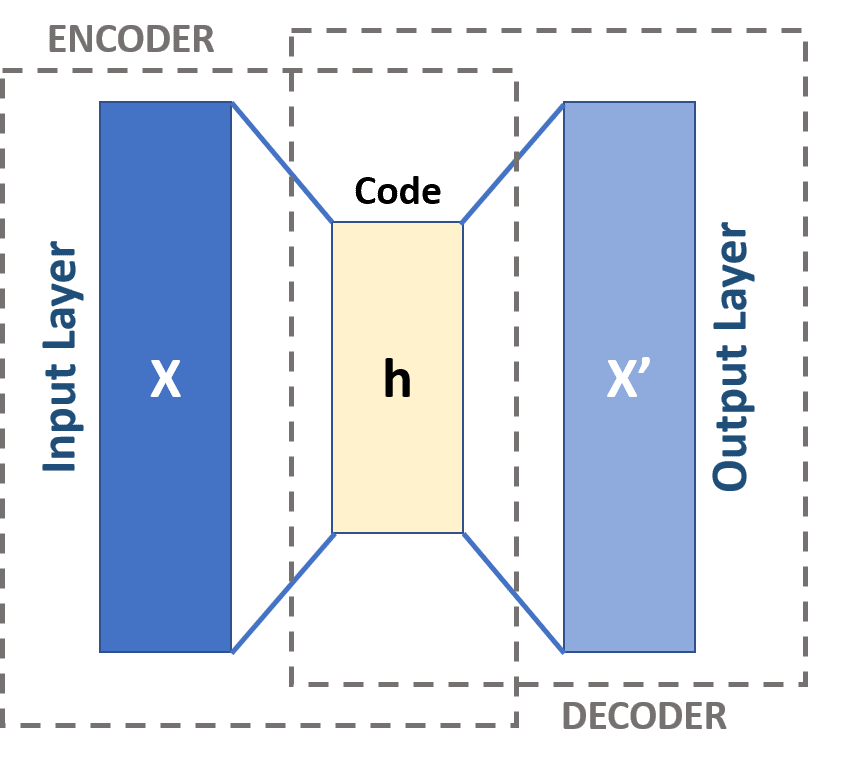

1986年Rumelhart提出自编码器的概念，顾名思义，即可以使用自身的高阶特征编码自己。自编码器（auto-encoder, AE）是一类在半监督学习和无监督学习中使用的人工神经网络（Artificial Neural Networks, ANNs），其功能是通过将输入信息作为学习目标，对输入信息进行表征学习。 

其结构通常包括一个输入层、一个或多个隐藏层和一个输出层。自编码器的目标是学习将输入数据压缩到隐藏层中，并能够通过解码器将其从压缩表示中重建出输入数据。

自编码器基本上可以分为三个不同的组件：编码器、瓶颈和解码器。编码器将输入数据映射到隐藏层，通常通过一系列的非线性变换和特征提取来实现。解码器则将隐藏层的表示映射回到重构的输入数据，同时也通过非线性变换和特征提取来实现。自编码器通过将输入数据进行压缩和重建的过程来学习有效的数据表示，从而可以用于数据的降维、特征提取、数据压缩、数据去噪等应用。

如果自编码器只是单纯的将输入复制到输出中，那么他没有用处。所以实际上，希望通过训练自编码器将输入复制到输出中，使隐藏表示的 h 拥有有用的属性。

因为自编码器也是一种神经网络，它的输入和输出是一致的，它借助稀疏编码的思想，目标是使用一些高阶特征重新组合来重构自己，即对所有的自编码器来讲，目标都是**样本重构**。自编码器首先通过编码层，将高维空间的向量压缩成低维的向量（潜在变量），然后通过解码层将低维向量解压重构出原始样本。

假如我们通过一组数据训练出了我们的自编码器，然后我们拆掉自编码器的解码器，就可以用剩下的编码器来表征我们的数据了。隐藏层的神经元数目远低于输入层，那么就相当于我们用更少的特征（神经元）去表征我们的输入数据，从而达到**降维压缩**的功能。

自编码器（Autoencoder）通常**不需要时间步**（time steps），因为自编码器主要用于学习数据的紧凑表示，而不涉及到时序信息。自编码器的训练通常是在整个输入数据集上进行的，而不是在时间序列数据上按照时间步进行。

如果你的数据是时序数据，并且你关心时间信息，你可能会考虑使用递归神经网络（Recurrent Neural Network，RNN）或长短时记忆网络（Long Short-Term Memory，LSTM）等网络结构，这些结构被设计用于处理时序信息。**自编码器通常用于静态数据或无序数据的表示学习，而不是处理时序信息。**

## 编码-解码器和自编码器区别

**任务目标：**

- 自编码器： 主要用于学习输入数据的紧凑表示，并能够通过解码器生成与原始输入相似的输出。训练目标通常是最小化输入和重构输出之间的差异。
- 编码-解码器： 这是一个更一般性的框架，可以用于执行多种任务，而不仅仅是学习数据的紧凑表示。编码器负责将输入数据映射到某个潜在空间，而解码器则负责将潜在表示映射回原始空间，但任务可以根据具体情况而变化，例如翻译、生成等。

**任务多样性：**

- 自编码器： 主要用于数据压缩和去噪，以及学习输入数据的表示。
- 编码-解码器： 更通用，可以用于各种任务，例如图像翻译、文本生成、语音合成等。编码-解码器的结构可以被设计用于执行特定的任务，而不仅仅是学习数据的表示。

**应用领域：**

- 自编码器： 常用于无监督学习和特征学习领域，例如图像降噪、图像去模糊等。
- 编码-解码器： 在各种领域都有广泛的应用，包括自然语言处理、计算机视觉、语音处理等。

虽然自编码器是编码-解码器的一种特例，但编码-解码器的框架更加通用，可以适用于更广泛的任务。在实际应用中，可以根据具体任务的需求选择使用自编码器或更通用的编码-解码器结构。

## CNN-LSTM-Encoder-Decoder

**CNN用于提取输入数据的特征，LSTM用于捕捉时间序列数据的长期依赖性。**

一维卷积神经网络（1D CNN）通常用于处理时序数据，例如时间序列或信号数据。这种网络结构可以有效地捕获时序数据中的局部模式和趋势。

### 多输入多输出多步预测

#### 数据准备

In [1]:
# 读取数据
def loader(data_path=None, data=None, time_col=None, datetime=None, freq=None):
    """
    读取数据，并对输入数据时间列进行处理

    参数说明
    ----------
    data_path : {str}
        输入数据地址，如果为空，读取已有数据
    data : {DataFrame} of shape (n_samples, n_features)
        输入数据，如果需读取本地数据，将该值置空，否则传入已有数据
    time_col : {str}
        输入数据的时间列，如果没有时间列，生成时间戳范围，或者生成固定频率的时间戳数据
    datetime : {str} 
        时间列开始时间，如果time_col为空，需填入此项，格式为%Y-%m-%d %H:%M:%S
    freq : {int}
        时间序列频率，单位为秒

    返回值
    -------
    data : {DataFrame} of shape (n_samples, n_features)
        经过时间序列处理后的数据
    """
    # 读取原始数据
    if data_path == None:
        if data.empty is True:
            raise ValueError("data is not exist!")
        else:
            data = data
    else:
        data = pd.read_csv(data_path)
    
    # 时间列处理
    if time_col == None:
        # 筛选输入频率
        re_1 = re.findall('[0-9]', freq)
        re_2 = re.findall('[a-z]', freq)
        # 识别数字频率
        if len(re_1) == 0:
            nums = 1
        else:
            nums = int(''.join(re_1))
        # 识别频率
        fr = re_2[0]
        # 生成时间间隔
        if fr == 's':
            time_index = pd.date_range(start=pd.to_datetime(datetime),
                                       end=pd.to_datetime(datetime) +
                                       timedelta(seconds=(data.shape[0] - 1)*nums),
                                       freq=freq)
        elif fr == 't':
            time_index = pd.date_range(start=pd.to_datetime(datetime),
                                       end=pd.to_datetime(datetime) +
                                       timedelta(minutes=(data.shape[0] - 1)*nums),
                                       freq=freq)
        elif fr == 'h':
            time_index = pd.date_range(start=pd.to_datetime(datetime),
                                       end=pd.to_datetime(datetime) +
                                       timedelta(hours=(data.shape[0] - 1)*nums),
                                       freq=freq)
        elif fr == 'd':
            time_index = pd.date_range(start=pd.to_datetime(datetime),
                                       end=pd.to_datetime(datetime) +
                                       timedelta(days=(data.shape[0] - 1)*nums),
                                       freq=freq)
        full_data = pd.DataFrame(data=data.values,
                                 index=pd.to_datetime(time_index, unit=freq),
                                 columns=data.columns)
    else:
        columns = [i for i in data.columns if i != time_col] # 去除时间列
        full_data = pd.DataFrame(data=data.drop([time_col], axis=1).values,
                                 index=pd.to_datetime(data[time_col].values),
                                 columns=columns)
    return full_data

In [114]:
data_path = "../outputs/datasets/energy.csv"
ts_data = loader(data_path=data_path, data=None, time_col='time')
ts_data

,load,temp
2012-01-01 00:00:00,2698.0,32.00
2012-01-01 01:00:00,2558.0,32.67
2012-01-01 02:00:00,2444.0,30.00
2012-01-01 03:00:00,2402.0,31.00
2012-01-01 04:00:00,2403.0,32.00
...,...,...
2014-12-31 19:00:00,4012.0,18.00
2014-12-31 20:00:00,3856.0,16.67
2014-12-31 21:00:00,3671.0,17.00
2014-12-31 22:00:00,3499.0,15.33


In [115]:
# 时间格式编码
def time_features_from_frequency_str(freq_str: str):
    """
    Returns a list of time features that will be appropriate for the given frequency string.
    Parameters
    ----------
    freq_str
        Frequency string of the form [multiple][granularity] such as "12H", "5min", "1D" etc.
    """

    class TimeFeature:
        def __init__(self):
            pass

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            pass

        def __repr__(self):
            return self.__class__.__name__ + "()"


    class SecondOfMinute(TimeFeature):
        """Minute of hour encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return index.second / 59.0 - 0.5


    class MinuteOfHour(TimeFeature):
        """Minute of hour encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return index.minute / 59.0 - 0.5


    class HourOfDay(TimeFeature):
        """Hour of day encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return index.hour / 23.0 - 0.5


    class DayOfWeek(TimeFeature):
        """Hour of day encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return index.dayofweek / 6.0 - 0.5


    class DayOfMonth(TimeFeature):
        """Day of month encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return (index.day - 1) / 30.0 - 0.5


    class DayOfYear(TimeFeature):
        """Day of year encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return (index.dayofyear - 1) / 365.0 - 0.5


    class MonthOfYear(TimeFeature):
        """Month of year encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return (index.month - 1) / 11.0 - 0.5


    class WeekOfYear(TimeFeature):
        """Week of year encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return (index.isocalendar().week - 1) / 52.0 - 0.5

    
    features_by_offsets = {
        offsets.YearEnd: [],
        offsets.QuarterEnd: [MonthOfYear],
        offsets.MonthEnd: [MonthOfYear],
        offsets.Week: [DayOfMonth, WeekOfYear],
        offsets.Day: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.BusinessDay: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Hour: [HourOfDay, DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Minute: [
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
        offsets.Second: [
            SecondOfMinute,
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
    }

    offset = to_offset(freq_str)

    for offset_type, feature_classes in features_by_offsets.items():
        if isinstance(offset, offset_type):
            return [cls() for cls in feature_classes]

    supported_freq_msg = f"""
    Unsupported frequency {freq_str}
    The following frequencies are supported:
        Y   - yearly
            alias: A
        M   - monthly
        W   - weekly
        D   - daily
        B   - business days
        H   - hourly
        T   - minutely
            alias: min
        S   - secondly
    """
    raise RuntimeError(supported_freq_msg)
    
def time_features(dates, freq='h'):
    return np.vstack([feat(dates) for feat in time_features_from_frequency_str(freq)])

In [1]:
# 包含时间维度的数据集划分
def divider(df, train_ratio, valid_ratio, x_feature_list, y_feature_list, freq, scaler_path):
    """
    读取数据，并对数据进行划分

    参数说明
    ----------
    df : {DataFrame} of shape (n_samples, n_features)
        输入数据
    train_ratio : {float}
        用于训练的数据集占比:将数据按照一定比例进行切分，取值范围为(0,1)
    valid_ratio : {float}
        用于验证的数据集占比:将数据按照一定比例进行切分，取值范围为(0,1)
    x_feature_list : {list[str]} 
        训练特征列，不包含时间列
    y_feature_list : {list[str]} 
        目标特征列，不包含时间列
    freq : {str}
        用来编码时间特征的频率，可选[s:秒,t:分,h:时,d:天,b:工作日,w:周,m:月]，频率越低，模型可能越精确
    scaler_path : {str} 
        数据归一化模型保存地址

    返回值
    -------
    x_scaler : {sklearn.preprocessing.MinMaxScaler}
        训练特征列归一化器
    y_scaler : {sklearn.preprocessing.MinMaxScaler}
        目标特征列归一化器
    train : {list[DataFrame]}
        训练特征数据，目标特征数据，时间特征数据
    valid : {list[DataFrame]}
        验证特征数据，目标特征数据，时间特征数据
    test : {list[DataFrame]}
        测试特征数据，目标特征数据，时间特征数据
    """
    #归一化
    x_scaler = MinMaxScaler() # 保证数据同分布
    y_scaler = MinMaxScaler()
    x_scaler = x_scaler.fit(df.copy()[x_feature_list]) 
    y_scaler = y_scaler.fit(df.copy()[y_feature_list])

    # 设置保存归一化参数路径
    if not os.path.exists(scaler_path):
        os.makedirs(scaler_path)

    # 保存归一化参数
    joblib.dump(x_scaler, scaler_path + "/x_scaler.pkl")
    joblib.dump(y_scaler, scaler_path + "/y_scaler.pkl")

    #测试集
    train = df.copy().iloc[:int(df.shape[0]*train_ratio), :][x_feature_list]
    train_stamp = time_features(pd.to_datetime(train.index), freq=freq)
    train_stamp = train_stamp.transpose(1, 0)
    train[x_feature_list] = x_scaler.transform(train)
    xtr = train.values.astype('float32')
    ytr = df.copy().iloc[:int(df.shape[0]*train_ratio), :][y_feature_list]
    ytr[y_feature_list] = y_scaler.transform(ytr)
    ytr = ytr.values.astype('float32')
    train = [xtr, ytr, train_stamp]

    #验证集
    valid = df.copy().iloc[int(df.shape[0]*train_ratio): int(df.shape[0]*(train_ratio+valid_ratio)), :][x_feature_list]
    valid_stamp = time_features(pd.to_datetime(valid.index), freq=freq)
    valid_stamp = valid_stamp.transpose(1, 0)
    valid[x_feature_list] = x_scaler.transform(valid)
    xva = valid.values.astype('float32')
    yva = df.copy().iloc[int(df.shape[0]*train_ratio): int(df.shape[0]*(train_ratio+valid_ratio)), :][y_feature_list]
    yva[y_feature_list] = y_scaler.transform(yva)
    yva = yva.values.astype('float32')
    valid = [xva, yva, valid_stamp]

    #测试集
    if train_ratio + valid_ratio != 1:
        test = df.copy().iloc[int(df.shape[0]*(train_ratio+valid_ratio)):, :][x_feature_list]
        test_stamp = time_features(pd.to_datetime(test.index), freq=freq)
        test_stamp = test_stamp.transpose(1, 0)
        test[x_feature_list] = x_scaler.transform(test)
        xte = test.values.astype('float32')
        yte = df.copy().iloc[int(df.shape[0]*(train_ratio+valid_ratio)):, :][y_feature_list]
        yte[y_feature_list] = y_scaler.transform(yte)
        yte = yte.values.astype('float32')
        test = [xte, yte, test_stamp]
    else:
        test = [np.array(0), np.array(0), np.array(0)]
    
    return x_scaler, y_scaler, train, valid, test

In [116]:
# 构造参数字典
params1 = {
    "df": ts_data,
    "train_ratio": 0.7,
    "valid_ratio": 0.1,
    "x_feature_list": ["load", 'temp'],
    "y_feature_list": ["load", 'temp'],
    "freq": 'h',
    "scaler_path": '../outputs/scalers/CLED'
}

#函数传参
x_scaler, y_scaler, train_data, valid_data, test_data = divider(**params1)
print("x_train shape: {0} y_train shape: {1} stamp_train shape: {2}".format(train_data[0].shape, train_data[1].shape, train_data[2].shape))
print("x_valid shape: {0} y_valid shape: {1} stamp_valid shape: {2}".format(valid_data[0].shape, valid_data[1].shape, valid_data[2].shape))
print("x_test shape: {0} y_test shape: {1} stamp_test shape: {2}".format(test_data[0].shape, test_data[1].shape, test_data[2].shape))

x_train shape: (23376, 2) y_train shape: (23376, 2) stamp_train shape: (23376, 4)
x_valid shape: (1464, 2) y_valid shape: (1464, 2) stamp_valid shape: (1464, 4)
x_test shape: (1464, 2) y_test shape: (1464, 2) stamp_test shape: (1464, 4)


In [4]:
# 利用前seq_len个数据，预测下pred_len个数据
def generator(data_list, seq_len, pred_len, label_len, batch_size, sample_freq: int = 1):
    """
    读取数据，并对数据进行划分

    参数说明
    ----------
    data_list : {list[DataFrame]}
        输入特征数据，目标特征数据，时间特征数据
    seq_len : {int}
        输入数据包含过去多少个时间步，正整数
    pred_len : {int}
        目标应该在未来多少个时间步之后，正整数
    label_len : {int} 
        先验时间步
    batch_size : {int} 
        输入数据的批次大小，正整数
    sample_freq : {int} 
        采样频率，正整数

    返回值
    -------
    X : {torch.Tensor}
        特征数据张量
    y : {torch.Tensor}
        目标数据张量
    X_stamp : {torch.Tensor}
        特征时间编码张量
    y_stamp : {torch.Tensor}
        目标时间编码张量
    data_loader : {torch.utils.data.dataloader.DataLoader}
        数据加载器，[特征，目标，特征时间编码，目标时间编码]
    """
    # 获取数据
    feature = data_list[0] # 特征
    target = data_list[1] # 目标
    stamp = data_list[2] # 时间戳
    
    # 循环生成数据
    X, y = [], []
    X_stamp, y_stamp = [], []
    seq_len = seq_len - 1 # 包含当前时间点
    for i in range(seq_len, len(feature) - pred_len, sample_freq):
        # 数据维度
        feat = feature[i - seq_len:i + 1]
        tar = target[i + 1:i + 1 + pred_len]
        X.append(np.array(feat))
        y.append(np.array(tar))
        
        # 时间维度
        xs = stamp[i - seq_len:i + 1]
        ys = stamp[i + 1 - label_len:i + 1 + pred_len]
        X_stamp.append(np.array(xs))
        y_stamp.append(np.array(ys))
        
    # 转为张量，数据维度
    X = torch.as_tensor(X).float()
    y = torch.as_tensor(y).float()
    
    # 转为张量，时间维度
    X_stamp = torch.as_tensor(X_stamp).float()
    y_stamp = torch.as_tensor(y_stamp).float()
    
    # 创建dataloader，[特征，目标，特征时间编码，目标时间编码]
    data_loader = DataLoader(TensorDataset(X, y, X_stamp, y_stamp), shuffle=True, batch_size=batch_size)
    
    return X, y, X_stamp, y_stamp, data_loader

In [118]:
# 构造参数字典
params2 = {
    "seq_len": 6,
    "pred_len": 3,
    "label_len": 0,
    "batch_size": 32,
}
X_train, y_train, X_train_stamp, y_train_stamp, train_loader = generator(train_data, **params2)
X_valid, y_valid, X_valid_stamp, y_valid_stamp, valid_loader = generator(valid_data, **params2)
X_test, y_test, X_test_stamp, y_test_stamp, test_loader = generator(test_data, **params2)
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_train.shape, y_train.shape, len(train_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_valid.shape, y_valid.shape, len(valid_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_test.shape, y_test.shape, len(test_loader)))

X_size: torch.Size([23368, 6, 2]),y_size: torch.Size([23368, 3, 2]),loader_len: 731
X_size: torch.Size([1456, 6, 2]),y_size: torch.Size([1456, 3, 2]),loader_len: 46
X_size: torch.Size([1456, 6, 2]),y_size: torch.Size([1456, 3, 2]),loader_len: 46


#### 模型定义

In [131]:
# 一维CNN模型
class CNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, e_layers):
        super(CNN, self).__init__()
        layers = []
        num_layers = e_layers
        in_channels = input_dim
        for _ in range(num_layers):
            # 保证输出维度不变，kernel_size=3,padding=1,stride=1
            layers.append(nn.Conv1d(in_channels=in_channels,
                                    out_channels=hidden_dim,
                                    kernel_size=3,
                                    padding=1))
            layers.append(nn.ReLU())
            in_channels = hidden_dim  # 调整输入通道数
        self.conv_layers = nn.Sequential(*layers)
            
    def forward(self, x):
        x = self.conv_layers(x) 
        return x
            
# LSTM模型
class LSTM(nn.Module):
    def __init__(self, hidden_dim, out_dim, d_layers):
        super().__init__()
        self.hidden_size = hidden_dim // 2 # 隐藏层设为输入的一半
        self.lstm = nn.LSTM(input_size=hidden_dim, hidden_size=self.hidden_size, num_layers=d_layers, batch_first=True)
        self.linear = nn.Linear(in_features=self.hidden_size, out_features=out_dim)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

# CNN+LSTM模型
class CLED(nn.Module):
    def __init__(self, seq_len, pred_len, label_len, c_in, d_model, c_out, e_layers, d_layers):
        super(CLED, self).__init__()
        self.pred_len = pred_len
        self.cnn = CNN(c_in, d_model, e_layers)
        self.rnn = LSTM(d_model, c_out, d_layers)

    def forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec):
        x = x_enc.permute(0, 2, 1) # 将输入维度变换为(样本数,特征,时间步)
        x = self.cnn(x) # cnn的输出维度为（batch数，特征数，时间步）
        x = x.permute(0, 2, 1) # rnn的输入维度为（batch数，时间步，特征数）
        x = self.rnn(x)
        x = x[:, -self.pred_len:, :]  # [B, L, D]

        return x

#### 模型训练

In [132]:
def train(task_args, train_args, model_args):
    # 参数配置
    columns = task_args['columns'] # 模型全部特征
    target = task_args['target'] # 模型预测特征
    features = task_args['features'] # 模型预测模式
    model_name = train_args['model_name'] # 模型名称
    train_loader = train_args['train_loader'] # 训练集
    valid_loader = train_args['valid_loader'] # 验证集
    n_epochs = train_args['n_epochs'] # 训练次数
    learning_rate = train_args['learning_rate'] # 学习率
    loss = train_args['loss'] # 损失函数
    patience = train_args['patience'] # 最大早停次数阈值，超过就会早停
    lradj = train_args['lradj'] # 学习率函数
    model_path = train_args['model_path'] # 模型保存路径
    verbose = train_args['verbose'] # 打印训练过程
    plots = train_args['plots'] # 绘制损失图
    device = train_args['device'] # 训练设备，可选'cuda'和'cpu'
    pred_len = model_args['pred_len'] # 预测长度
    label_len = model_args['label_len']
    
    #检查是否可用GPU
    device = torch.device(device)
    
    # 创建模型和优化器
    model = model_name(**model_args).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = loss
    
    # 调整学习率
    def adjust_learning_rate(optimizer, epoch, lradj, learning_rate, train_epochs):
        # lr = learning_rate * (0.2 ** (epoch // 2))
        if lradj == 'type1':
            lr_adjust = {epoch: learning_rate * (0.5 ** ((epoch - 1) // 1))}
        elif lradj == 'type2':
            lr_adjust = {
                2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6,
                10: 5e-7, 15: 1e-7, 20: 5e-8
            }
        elif lradj == "cosine":
            lr_adjust = {epoch: learning_rate /2 * (1 + math.cos(epoch / train_epochs * math.pi))}
        if epoch in lr_adjust.keys():
            lr = lr_adjust[epoch]
            # 参数组(param_groups)是用来指定不同的参数组以便对它们进行不同的优化设置，比如'lr'
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
            print('Updating learning rate to {}'.format(lr))
    
    # 设置早停
    class EarlyStopping():
        def __init__(self, patience=7, verbose=False, delta=0):
            self.patience = patience # 连续超限次数，如果满足条件，则早停
            self.verbose = verbose
            self.counter = 0
            self.best_score = None
            self.early_stop = False
            self.val_loss_min = np.Inf
            self.delta = delta

        def __call__(self, val_loss, model, path):
            score = -val_loss
            if self.best_score is None:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
            elif score < self.best_score + self.delta:
                self.counter += 1
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
                self.counter = 0

        def save_checkpoint(self, val_loss, model, path):
            if self.verbose:
                print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
            torch.save(model.state_dict(), path + '/' + 'checkpoint.pth')
            self.val_loss_min = val_loss
    early_stopping = EarlyStopping(patience=patience, verbose=verbose)
    
    # 训练任务
    def forecasting_task(columns, target, features):
        """
        features: [M, S, MS]; 
            M:multivariate predict multivariate, 
            S:univariate predict univariate, 
            MS:multivariate predict univariate'
        """
        # 字典索引生成
        col_dict = {}
        for i,j in enumerate(columns):
            col_dict[j] = i

        if features == 'MS':
            target = target[0]
            if target in columns:
                f_dim = col_dict[target]
            else:
                f_dim = 0
        elif features == 'S':
            f_dim = 0
        else:
            f_dim = 0
        return f_dim
    f_dim = forecasting_task(columns, target, features)
    
    # 设置保存模型路径
    if not os.path.exists(model_path):
        os.makedirs(model_path)

    # 模型训练和验证
    train_losses, val_losses = [], []
    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_train_loss = 0
        for batch_x, batch_y, batch_x_mark, batch_y_mark in train_loader:
            #将数据移至 GPU
            batch_x = batch_x.to(device) # 会用到实际数据
            batch_y = batch_y.to(device) # 只用来获取维度，不会用到实际数据，防止泄露信息
            batch_x_mark = batch_x_mark.to(device)
            batch_y_mark = batch_y_mark.to(device)
            # 清空梯度
            optimizer.zero_grad()
            # decoder输入 
            dec_inp = torch.zeros_like(batch_y[:, -pred_len:, :]).float()
            if features == 'MS':
                dec_inp = torch.cat([batch_x[:, -label_len:, f_dim: f_dim+1], dec_inp], dim=1).float().to(device)
                outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                # outputs = outputs[:, :, f_dim: f_dim+1] 
            else:
                dec_inp = torch.cat([batch_x[:, -label_len:, f_dim:], dec_inp], dim=1).float().to(device)
                outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                # outputs = outputs[:, :, f_dim:]
            train_loss = criterion(outputs, batch_y)
            # 反向传播计算得到每个参数的梯度值
            train_loss.backward()
            # 通过梯度下降执行一步参数更新
            optimizer.step()
            #每个batch的loss和
            total_train_loss += train_loss.item() # .item()表示只包含一个元素的tensor中提取值
                
        #每个epoch的损失平均
        avg_train_loss = total_train_loss / len(train_loader)
        
        #所有epoch的loss
        train_losses.append(avg_train_loss)
        
        #评估模型
        model.eval()
        #关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            total_val_loss = 0
            for batch_x, batch_y, batch_x_mark, batch_y_mark in valid_loader:
                #将数据移至 GPU
                batch_x = batch_x.to(device) # 会用到实际数据
                batch_y = batch_y.to(device) # 只用来获取维度，不会用到实际数据，防止泄露信息
                batch_x_mark = batch_x_mark.to(device)
                batch_y_mark = batch_y_mark.to(device)
                # decoder输入
                dec_inp = torch.zeros_like(batch_y[:, -pred_len:, :]).float()
                if features == 'MS':
                    dec_inp = torch.cat([batch_x[:, -label_len:, f_dim: f_dim+1], dec_inp], dim=1).float().to(device)
                    outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                    # outputs = outputs[:, :, f_dim: f_dim+1] 
                else:
                    dec_inp = torch.cat([batch_x[:, -label_len:, f_dim:], dec_inp], dim=1).float().to(device)
                    outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                    # outputs = outputs[:, :, f_dim:]
                val_loss = criterion(outputs, batch_y)
                #每个batch的loss和
                total_val_loss += val_loss.item()
                
        #每个epoch的损失平均
        avg_val_loss = total_val_loss / len(valid_loader)
        
        #所有epoch的loss
        val_losses.append(avg_val_loss)
        
        #打印训练过程
        if verbose:
            print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
            
        # 设置早停
        early_stopping(avg_val_loss, model, model_path)
        if early_stopping.early_stop:
            print("Early stopping!")
            break
            
        # 调整学习率
        adjust_learning_rate(optimizer, epoch+1, lradj, learning_rate, n_epochs)

    #绘制损失函数图
    def plot_loss(train_losses, val_losses):
        plt.figure(figsize=(10, 5))
        plt.style.use('seaborn-v0_8-paper') #绘制背景色
        plt.grid(axis = 'y',linewidth=0.35) #绘制网格
        plt.plot(val_losses, linestyle='-',color = '#11b3b6')
        plt.plot(train_losses, linestyle='-',color = '#f14643')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Progress")
        plt.legend(["Validation", "Training"])
        plt.show()
    if plots:
        plot_loss(train_losses, val_losses)
            
    return model

  5%|████▏                                                                              | 1/20 [00:03<01:06,  3.52s/it]

Epoch [1/20], Training Loss: 0.0083, Validation Loss: 0.0035
Validation loss decreased (inf --> 0.003464).  Saving model ...
Updating learning rate to 0.0009938441702975688


 10%|████████▎                                                                          | 2/20 [00:06<01:00,  3.37s/it]

Epoch [2/20], Training Loss: 0.0026, Validation Loss: 0.0020
Validation loss decreased (0.003464 --> 0.002007).  Saving model ...
Updating learning rate to 0.0009755282581475768


 15%|████████████▍                                                                      | 3/20 [00:09<00:52,  3.10s/it]

Epoch [3/20], Training Loss: 0.0020, Validation Loss: 0.0015
Validation loss decreased (0.002007 --> 0.001517).  Saving model ...
Updating learning rate to 0.0009455032620941839


 20%|████████████████▌                                                                  | 4/20 [00:12<00:47,  2.99s/it]

Epoch [4/20], Training Loss: 0.0017, Validation Loss: 0.0015
Validation loss decreased (0.001517 --> 0.001483).  Saving model ...
Updating learning rate to 0.0009045084971874737


 25%|████████████████████▊                                                              | 5/20 [00:15<00:43,  2.91s/it]

Epoch [5/20], Training Loss: 0.0015, Validation Loss: 0.0013
Validation loss decreased (0.001483 --> 0.001340).  Saving model ...
Updating learning rate to 0.0008535533905932737


 30%|████████████████████████▉                                                          | 6/20 [00:17<00:40,  2.88s/it]

Epoch [6/20], Training Loss: 0.0014, Validation Loss: 0.0012
Validation loss decreased (0.001340 --> 0.001167).  Saving model ...
Updating learning rate to 0.0007938926261462366


 35%|█████████████████████████████                                                      | 7/20 [00:20<00:37,  2.86s/it]

Epoch [7/20], Training Loss: 0.0013, Validation Loss: 0.0012
Validation loss decreased (0.001167 --> 0.001161).  Saving model ...
Updating learning rate to 0.0007269952498697733


 40%|█████████████████████████████████▏                                                 | 8/20 [00:23<00:33,  2.81s/it]

Epoch [8/20], Training Loss: 0.0012, Validation Loss: 0.0011
Validation loss decreased (0.001161 --> 0.001095).  Saving model ...
Updating learning rate to 0.0006545084971874737


 45%|█████████████████████████████████████▎                                             | 9/20 [00:26<00:32,  2.93s/it]

Epoch [9/20], Training Loss: 0.0012, Validation Loss: 0.0010
Validation loss decreased (0.001095 --> 0.000978).  Saving model ...
Updating learning rate to 0.0005782172325201155


 50%|█████████████████████████████████████████                                         | 10/20 [00:29<00:28,  2.88s/it]

Epoch [10/20], Training Loss: 0.0011, Validation Loss: 0.0009
Validation loss decreased (0.000978 --> 0.000905).  Saving model ...
Updating learning rate to 0.0005


 55%|█████████████████████████████████████████████                                     | 11/20 [00:32<00:25,  2.84s/it]

Epoch [11/20], Training Loss: 0.0011, Validation Loss: 0.0009
EarlyStopping counter: 1 out of 3
Updating learning rate to 0.0004217827674798845


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:35<00:22,  2.83s/it]

Epoch [12/20], Training Loss: 0.0010, Validation Loss: 0.0010
EarlyStopping counter: 2 out of 3
Updating learning rate to 0.00034549150281252633


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:37<00:20,  2.87s/it]

Epoch [13/20], Training Loss: 0.0010, Validation Loss: 0.0008
Validation loss decreased (0.000905 --> 0.000835).  Saving model ...
Updating learning rate to 0.00027300475013022663


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:41<00:17,  2.96s/it]

Epoch [14/20], Training Loss: 0.0009, Validation Loss: 0.0009
EarlyStopping counter: 1 out of 3
Updating learning rate to 0.00020610737385376348


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:43<00:14,  2.92s/it]

Epoch [15/20], Training Loss: 0.0009, Validation Loss: 0.0008
Validation loss decreased (0.000835 --> 0.000825).  Saving model ...
Updating learning rate to 0.00014644660940672628


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:47<00:11,  2.99s/it]

Epoch [16/20], Training Loss: 0.0009, Validation Loss: 0.0008
Validation loss decreased (0.000825 --> 0.000786).  Saving model ...
Updating learning rate to 9.549150281252633e-05


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:50<00:08,  2.98s/it]

Epoch [17/20], Training Loss: 0.0009, Validation Loss: 0.0008
EarlyStopping counter: 1 out of 3
Updating learning rate to 5.449673790581611e-05


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:53<00:06,  3.03s/it]

Epoch [18/20], Training Loss: 0.0009, Validation Loss: 0.0008
EarlyStopping counter: 2 out of 3
Updating learning rate to 2.4471741852423235e-05


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:56<00:03,  3.06s/it]

Epoch [19/20], Training Loss: 0.0009, Validation Loss: 0.0008
Validation loss decreased (0.000786 --> 0.000777).  Saving model ...
Updating learning rate to 6.15582970243117e-06


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:59<00:00,  2.97s/it]

Epoch [20/20], Training Loss: 0.0009, Validation Loss: 0.0008
Validation loss decreased (0.000777 --> 0.000774).  Saving model ...
Updating learning rate to 0.0


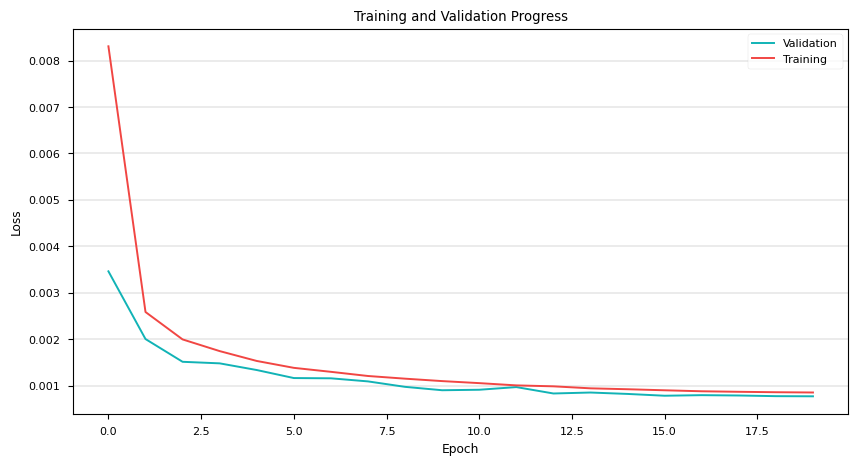

In [133]:
# 构造参数字典
params3 = {
    "task_args":{
        "columns": ['load', 'temp'],
        "target": ["load", 'temp'],
        "features": 'M'
    },
    "train_args": {
        "model_name": CLED,
        "train_loader": train_loader,
        "valid_loader": valid_loader,
        "n_epochs": 20,
        "learning_rate": 0.001,
        "loss": nn.MSELoss(),
        "patience": 3,
        "device": 'cuda',
        "lradj": 'cosine',
        "model_path": "../outputs/best_models/CLED",
        "verbose": True,
        "plots": True,
    },
    "model_args": {
        'seq_len': 6,
        'pred_len': 3,
        "label_len": 0,
        'd_model': 128,
        'c_in': 2,
        'c_out': 2,
        'e_layers': 1,
        'd_layers': 1,
    },
}
model = train(**params3)

#### 模型测试

In [134]:
def test(task_args, test_args):
    # 参数配置
    columns = task_args['columns'] # 全部
    target = task_args['target'] 
    features = task_args['features'] 
    model = test_args['model'] 
    x_test = test_args['x_test'] 
    x_test_stamp = test_args['x_test_stamp']
    y_test = test_args['y_test'] 
    y_test_stamp = test_args['y_test_stamp']
    pred_len = test_args['pred_len'] 
    label_len = test_args['label_len']
    device = test_args['device'] # 训练设备，可选'cuda'和'cpu'
    test_path = test_args['test_path'] # 结果保存路径
    
    #检查是否可用GPU
    device = torch.device(device)

    # 评估指标函数
    def metric(pred, true):
        # a/b，其中生成的 NaN 或 Inf 替换为 0
        def divide_no_nan(a, b):
            result = a / b
            result[result != result] = .0
            result[np.inf in result] = .0
            result[np.nan in result] = .0
            return result
        # 残差的标准误差
        def RSE(pred, true):
            return np.sqrt(np.sum((true - pred) ** 2)) / np.sqrt(np.sum((true - true.mean()) ** 2))
        # 相关系数
        def CORR(pred, true):
            u = ((true - true.mean(0)) * (pred - pred.mean(0))).sum(0)
            d = np.sqrt(((true - true.mean(0)) ** 2 * (pred - pred.mean(0)) ** 2).sum(0))
            return (u / d).mean(-1)
        # 平均绝对误差
        def MAE(pred, true):
            return np.mean(np.abs(pred - true))
        # 均方误差
        def MSE(pred, true):
            return np.mean((pred - true) ** 2)
        # 均方根误差
        def RMSE(pred, true):
            return np.sqrt(MSE(pred, true))
        # 平均绝对百分比误差
        def MAPE(pred, true):
            return np.mean(np.abs(divide_no_nan((pred - true), true)))
        # 均方预测误差
        def MSPE(pred, true):
            return np.mean(np.square(divide_no_nan((pred - true), true)))
        # 结果汇总
        mae = MAE(pred, true)
        mse = MSE(pred, true)
        rmse = RMSE(pred, true)
        mape = MAPE(pred, true)
        mspe = MSPE(pred, true)
        print("mae: {:.4f}\nmse: {:.4f}\nrmse: {:.4f}\nmape: {:.4f}\nmspe: {:.4f}".format(mae, mse, rmse, mape, mspe))
        return mae, mse, rmse, mape, mspe
    
    def forecasting_task(columns, target, features):
        """
        features: [M, S, MS]; 
            M:multivariate predict multivariate, 
            S:univariate predict univariate, 
            MS:multivariate predict univariate'
        """
        # 字典索引生成
        col_dict = {}
        for i,j in enumerate(columns):
            col_dict[j] = i

        if features == 'MS':
            target = target[0]
            if target in columns:
                f_dim = col_dict[target]
            else:
                f_dim = 0
        elif features == 'S':
            f_dim = 0
        else:
            f_dim = 0
        return f_dim
    f_dim = forecasting_task(columns, target, features)
    
    # 设置保存模型路径
    if not os.path.exists(test_path):
        os.makedirs(test_path)
    
    # 关闭自动求导功能
    model.eval() # 一定要有
    with torch.no_grad():
        '''测试集设置'''
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        x_test_stamp = x_test_stamp.to(device)
        y_test_stamp = y_test_stamp.to(device)
        # decoder输入
        dec_inp = torch.zeros_like(y_test[:, -pred_len:, :]).float()
        dec_inp = torch.cat([y_test[:, -label_len:, :], dec_inp], dim=1).float().to(device)
        outputs = model(x_test, x_test_stamp, dec_inp, y_test_stamp)
        if features == 'MS':
            dec_inp = torch.cat([x_test[:, -label_len:, f_dim: f_dim+1], dec_inp], dim=1).float().to(device)
            y_pred = model(x_test, x_test_stamp, dec_inp, y_test_stamp)
            # y_pred = outputs[:, :, f_dim: f_dim+1] 
        else:
            dec_inp = torch.cat([x_test[:, -label_len:, f_dim:], dec_inp], dim=1).float().to(device)
            y_pred = model(x_test, x_test_stamp, dec_inp, y_test_stamp)
            # y_pred = outputs[:, :, f_dim:]
        # 评估指标计算
        y_pred = y_pred.cpu().detach().numpy()
        y_true = y_test.cpu().detach().numpy()
        mae, mse, rmse, mape, mspe = metric(y_pred, y_true)
        np.save(test_path + '/metrics.npy', np.array([mae, mse, rmse, mape, mspe]))
        np.save(test_path + '/pred.npy', y_pred)
        np.save(test_path + '/true.npy', y_true)
        
    return 0

In [135]:
# 构造参数字典
params4 = {
    "task_args":{
        "columns": ['load', 'temp'],
        "target": ['load', 'temp'],
        "features": 'M'
    },
    "test_args": {
        "model": model,
        "x_test": X_test,
        "x_test_stamp": X_test_stamp,
        "y_test": y_test,
        "y_test_stamp": y_test_stamp,
        'label_len': 0,
        'pred_len': 3,
        'device': 'cuda',
        'test_path': '../outputs/results/CLED'
    }
}
res = test(**params4)

mae: 0.0201
mse: 0.0009
rmse: 0.0298
mape: 0.0489
mspe: 0.0061


#### 结果分析

In [136]:
def plot(task_args, plot_args):
    # 参数配置
    columns = task_args['columns'] # 全部
    target = task_args['target'] 
    features = task_args['features'] 
    drawing_point = plot_args['drawing_point'] # 绘图点
    model = plot_args['model'] 
    x_train = plot_args['x_train'] 
    x_train_stamp = plot_args['x_train_stamp']
    x_valid = plot_args['x_valid'] 
    x_valid_stamp = plot_args['x_valid_stamp']
    x_test = plot_args['x_test'] 
    x_test_stamp = plot_args['x_test_stamp']
    y_train = plot_args['y_train'] 
    y_train_stamp = plot_args['y_train_stamp']
    y_valid = plot_args['y_valid'] 
    y_valid_stamp = plot_args['y_valid_stamp']
    y_test = plot_args['y_test'] 
    y_test_stamp = plot_args['y_test_stamp']
    y_true = plot_args['y_true'] 
    seq_len = plot_args['seq_len']
    scaler = plot_args['scaler']
    pred_len = plot_args['pred_len'] 
    label_len = plot_args['label_len']
    device = plot_args['device'] # 训练设备，可选'cuda'和'cpu'
    option = plot_args['option'] # 绘图选项，可选'part','full'
    figure_path = plot_args['figure_path'] # 图片保存路径
    seq_len = seq_len - 1 # 包含当前时间点
    
    #检查是否可用GPU
    device = torch.device(device)
    
    # 任务分类
    def forecasting_task(columns, target, features, drawing_point):
        """
        features: [M, S, MS]; 
            M:multivariate predict multivariate, 
            S:univariate predict univariate, 
            MS:multivariate predict univariate'
        """
        # 字典索引生成
        col_dict = {}
        for i,j in enumerate(columns):
            col_dict[j] = i

        if features == 'MS':
            target = target[0]
            if target in columns:
                f_dim = col_dict[target]
            else:
                f_dim = 0
        elif features == 'S':
            f_dim = 0
        else:
            f_dim = 0

        if drawing_point in columns:
            d_dim = col_dict[drawing_point]
        else:
            d_dim = 0
        return f_dim, d_dim
    f_dim, d_dim = forecasting_task(columns, target, features, drawing_point)
        
    # 数据集长度
    train_size = len(x_train) + seq_len + pred_len
    valid_size = len(x_valid) + seq_len + pred_len
    test_size = len(x_test) + seq_len + pred_len
    
    # 时间序列形状
    timeseries_y = y_true.values[:, d_dim].reshape(-1, 1)
    timeseries_x = y_true.index
    
    # 关闭自动求导功能
    model.eval() # 一定要有
    with torch.no_grad():
        '''训练集设置'''
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        x_train_stamp = x_train_stamp.to(device)
        y_train_stamp = y_train_stamp.to(device)
        # decoder输入
        B, _, _ = x_train.shape
        dec_inp = torch.zeros((B, pred_len, len(target))).float().to(device)
        if features == 'S' or features == 'M':
            dec_inp = torch.cat([x_train[:, -label_len:, f_dim:], dec_inp], dim=1).float()
            y_pred = model(x_train, x_train_stamp, dec_inp, y_train_stamp)
            y_pred = y_pred.cpu().detach().numpy() # 首先将张量移动到CPU，然后从计算图中分离，最后转换为NumPy数组
            y_pred = scaler.inverse_transform(y_pred[:, 0, :].reshape(-1, len(columns))) # 反归一化
            y_pred = y_pred[:, d_dim:d_dim+1]
        else:
            dec_inp = torch.cat([x_train[:, -label_len:, f_dim: f_dim+1], dec_inp], dim=1).float()
            y_pred = model(x_train, x_train_stamp, dec_inp, y_train_stamp)
            y_pred = y_pred.cpu().detach().numpy() # 首先将张量移动到CPU，然后从计算图中分离，最后转换为NumPy数组
            y_pred = scaler.inverse_transform(y_pred[:, 0, :].reshape(-1, 1)) # 反归一化
        train_plot_y = [np.nan]*(seq_len+1) + list(y_pred.reshape(-1, ))+ [np.nan]*(pred_len-1)
        train_plot_x = timeseries_x[: train_size]
        
        '''验证集设置'''
        x_valid = x_valid.to(device)
        y_valid = y_valid.to(device)
        x_valid_stamp = x_valid_stamp.to(device)
        y_valid_stamp = y_valid_stamp.to(device)
        # decoder输入
        B, _, _ = x_valid.shape
        dec_inp = torch.zeros((B, pred_len, len(target))).float().to(device)
        if features == 'S' or features == 'M':
            dec_inp = torch.cat([x_valid[:, -label_len:, f_dim:], dec_inp], dim=1).float()
            y_pred = model(x_valid, x_valid_stamp, dec_inp, y_valid_stamp)
            y_pred = y_pred.cpu().detach().numpy() 
            y_pred = scaler.inverse_transform(y_pred[:, 0, :].reshape(-1, len(columns))) # 反归一化
            y_pred = y_pred[:, d_dim:d_dim+1]
        else:
            dec_inp = torch.cat([x_valid[:, -label_len:, f_dim: f_dim+1], dec_inp], dim=1).float()
            y_pred = model(x_valid, x_valid_stamp, dec_inp, y_valid_stamp)
            y_pred = y_pred.cpu().detach().numpy() 
            y_pred = scaler.inverse_transform(y_pred[:, 0, :].reshape(-1, 1)) # 反归一化
        valid_plot_y = [np.nan]*(seq_len+1) + list(y_pred.reshape(-1, ))+ [np.nan]*(pred_len-1)
        valid_plot_x = timeseries_x[train_size: train_size+valid_size]
        
        '''测试集设置'''
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        x_test_stamp = x_test_stamp.to(device)
        y_test_stamp = y_test_stamp.to(device)
        # decoder输入
        B, _, _ = x_test.shape
        dec_inp = torch.zeros((B, pred_len, len(target))).float().to(device)
        if features == 'S' or features == 'M':
            dec_inp = torch.cat([x_test[:, -label_len:, f_dim:], dec_inp], dim=1).float()
            y_pred = model(x_test, x_test_stamp, dec_inp, y_test_stamp)
            y_pred = y_pred.cpu().detach().numpy() 
            y_pred = scaler.inverse_transform(y_pred[:, 0, :].reshape(-1, len(columns))) # 反归一化
            y_pred = y_pred[:, d_dim:d_dim+1]
        else:
            dec_inp = torch.cat([x_test[:, -label_len:, f_dim: f_dim+1], dec_inp], dim=1).float()
            y_pred = model(x_test, x_test_stamp, dec_inp, y_test_stamp)
            y_pred = y_pred.cpu().detach().numpy() 
            y_pred = scaler.inverse_transform(y_pred[:, 0, :].reshape(-1, 1)) # 反归一化
        test_plot_y = [np.nan]*(seq_len+1) + list(y_pred.reshape(-1, )) + [np.nan]*(pred_len-1)
        test_plot_x = timeseries_x[train_size+valid_size: train_size+valid_size+test_size]
        
    # 设置保存图片路径
    if not os.path.exists(figure_path):
        os.makedirs(figure_path)
    figure_path = figure_path + '/' + target[0] + '_' + option + '.png'

    # 全局静态图
    def static_full_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, 
                               valid_plot_x, valid_plot_y, test_plot_x, test_plot_y, figure_path):
        #绘图，原始图，训练图，验证图，测试图
        fig = plt.figure(1, (10, 5))
        ax = fig.add_subplot(1,1,1)
        plt.style.use('seaborn-v0_8-paper') #绘制背景色
        plt.grid(axis = 'y',linewidth=0.35) #绘制网格
        plt.title('true-predict-curve ') #图标题
        plt.xticks(rotation = 45) #rotation文字旋转方向
        ax.plot(timeseries_x, timeseries_y, linestyle='-',color = '#11b3b6',label = 'true_curve')
        ax.plot(train_plot_x, train_plot_y, linestyle='--',label = 'train_predict_curve')
        ax.plot(valid_plot_x, valid_plot_y, linestyle='--',label = 'valid_predict_curve')
        ax.plot(test_plot_x, test_plot_y, linestyle='--',label = 'test_predict_curve')
        ax.legend(frameon=False) #绘制图例
        plt.xlabel('Time')
        plt.ylabel('Values')
        plt.savefig(figure_path, dpi=600)
        plt.show()

    # 局部静态图
    def static_part_timeseries(timeseries_x, timeseries_y, test_plot_x, test_plot_y, figure_path):
        timeseries_x = timeseries_x[timeseries_x >= test_plot_x[0]]
        timeseries_y = timeseries_y[timeseries_y.shape[0] - len(test_plot_x):,:]
        #绘图，原始图，训练图，验证图，测试图
        fig = plt.figure(1, (10, 5))
        ax = fig.add_subplot(1,1,1)
        plt.style.use('seaborn-v0_8-paper') #绘制背景色
        plt.grid(axis = 'y',linewidth=0.35) #绘制网格
        plt.title('true-predict-curve ') #图标题
        plt.xticks(rotation = 45) #rotation文字旋转方向
        ax.plot(timeseries_x, timeseries_y, linestyle='-',label = 'true_curve')
        ax.plot(test_plot_x, test_plot_y, linestyle='--',label = 'predict_curve')
        ax.legend(frameon=False) #绘制图例
        plt.xlabel('Time')
        plt.ylabel('Values')
        plt.savefig(figure_path, dpi=600)
        plt.show()

    # 全局动态图
    def dynamic_full_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y):
        # 准备画布
        fig = go.Figure()
    
        # 添加实际数据
        fig.add_trace(
            go.Scatter(
                x=timeseries_x,
                y=timeseries_y.reshape(timeseries_y.shape[0], ),
                mode='lines',
                name='true_curve',
                line = dict(color=None, width=2, dash=None)
            ))
    
        # 添加训练预测数据
        fig.add_trace(
            go.Scatter(
                x=train_plot_x,
                y=train_plot_y,
                mode='lines',
                name='train_predict_curve',
                line = dict(color=None, width=2, dash=None)
            ))
    
        # 添加验证预测数据
        fig.add_trace(
            go.Scatter(
                x=valid_plot_x,
                y=valid_plot_y,
                mode='lines',
                name='valid_predict_curve',
                line = dict(color=None, width=2, dash=None)
            ))
    
        # 添加测试预测数据
        fig.add_trace(
            go.Scatter(
                x=test_plot_x,
                y=test_plot_y,
                mode='lines',
                name='test_predict_curve',
                line = dict(color=None, width=2, dash=None)
            ))
    
        #更新图表的排版
        fig.update_layout(
            title='true-predict-curve',
            xaxis=dict(title="date"),
            yaxis=dict(title="values"),
            width=900,  #图表宽度
            height=500,  #图表长度
            template="simple_white"  #图表风格
        )
    
        fig.show()

    # 局部动态图
    def dynamic_part_timeseries(timeseries_x, timeseries_y, test_plot_x, test_plot_y):
        timeseries_x = timeseries_x[timeseries_x >= test_plot_x[0]]
        timeseries_y = timeseries_y[timeseries_y.shape[0] - len(test_plot_x):,:]
        # 准备画布
        fig = go.Figure()
    
        # 添加实际数据
        fig.add_trace(
            go.Scatter(
                x=timeseries_x,
                y=timeseries_y.reshape(timeseries_y.shape[0], ),
                mode='lines',
                name='true_curve',
                line = dict(color=None, width=2, dash=None)
            ))
    
        # 添加测试预测数据
        fig.add_trace(
            go.Scatter(
                x=test_plot_x,
                y=test_plot_y,
                mode='lines',
                name='predict_curve',
                line = dict(color=None, width=2, dash=None)
            ))
    
        #更新图表的排版
        fig.update_layout(
            title='true-predict-curve',
            xaxis=dict(title="date"),
            yaxis=dict(title="values"),
            width=900,  #图表宽度
            height=500,  #图表长度
            template="simple_white"  #图表风格
        )
    
        fig.show()

    # 绘图选项，可选'part','full','dynamic_part','dynamic_full'
    if option == 'part':
        # 局部静态图
        static_part_timeseries(timeseries_x, timeseries_y, test_plot_x, test_plot_y, figure_path)
    elif option == 'full':
        # 全局静态图
        static_full_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, 
                               valid_plot_x, valid_plot_y, test_plot_x, test_plot_y, figure_path)
    elif option == 'dynamic_full':
        # 全局动态图
        dynamic_full_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, 
                               valid_plot_x, valid_plot_y, test_plot_x, test_plot_y)
    elif option == 'dynamic_part':
        # 局部动态图
        dynamic_part_timeseries(timeseries_x, timeseries_y, test_plot_x, test_plot_y)
    else:
        raise ValueError("only support 'part','full','dynamic_part','dynamic_part'")
        
    return 0

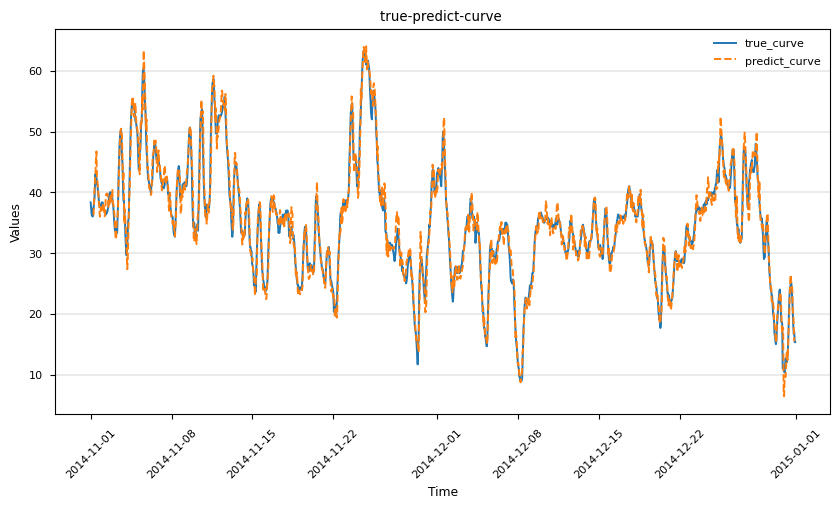

0

In [137]:
# 构造参数字典
params5 = {
    "task_args":{
        "columns": ['load', 'temp'],
        "target": ['load', 'temp'],
        "features": 'M'
    },
    "plot_args": {
        "drawing_point": 'temp',
        "model": model,
        "x_train": X_train,
        "x_valid": X_valid,
        "x_test": X_test,
        "x_train_stamp": X_train_stamp,
        "x_valid_stamp": X_valid_stamp,
        "x_test_stamp": X_test_stamp,
        "y_train": y_train,
        "y_valid": y_valid,
        "y_test": y_test,
        "y_train_stamp": y_train_stamp,
        "y_valid_stamp": y_valid_stamp,
        "y_test_stamp": y_test_stamp,
        "y_true": ts_data,
        "seq_len": 6,
        "pred_len": 3,
        "label_len": 0,
        "scaler": y_scaler,
        "device": 'cuda',
        "option": 'part',
        "figure_path": '../outputs/images/CLED'
    }
}
plot(**params5)

#### 模型预测

In [138]:
def predict(task_args, predict_args, model_args):
    # 参数配置
    columns = task_args['columns']
    target = task_args['target'] 
    time_col = predict_args['time_col']
    features = task_args['features'] 
    freq = predict_args['freq']
    model_name = predict_args['model_name'] 
    x_true = predict_args['x_true'] 
    scaler_path = predict_args['scaler_path']
    model_path = predict_args['model_path'] 
    device = predict_args['device'] # 预测设备，可选'cuda'和'cpu'
    pred_len = model_args['pred_len'] 
    label_len = model_args['label_len']

    #检查是否可用GPU
    device = torch.device(device)

    # 读取归一化参数
    x_scaler = joblib.load(scaler_path + "/x_scaler.pkl")
    y_scaler = joblib.load(scaler_path + "/y_scaler.pkl")

    # 加载模型
    model = model_name(**model_args)
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)

    # 生成固定长度的时间范围
    x_true = loader(data_path=None, data=x_true, time_col=time_col) # 原始数据
    x_true = x_true[columns]
    timedelta = x_true.index[-1] - x_true.index[-2] # 时间差
    if label_len != 0:
        y_stamp = pd.date_range(start=x_true.index[-label_len], 
                                end=x_true.index[-label_len]+timedelta*(label_len+pred_len-1), 
                                freq=freq)
    else:
        y_stamp = pd.date_range(start=x_true.index[-1]+timedelta*(label_len+1), 
                                end=x_true.index[-1]+timedelta*(label_len+pred_len), 
                                freq=freq) 
    x_stamp = time_features(pd.to_datetime(x_true.index), freq=freq) # x时间戳数据
    x_stamp = x_stamp.transpose(1, 0)
    y_time = y_stamp
    y_stamp = time_features(y_stamp, freq=freq) # y时间戳数据
    y_stamp = y_stamp.transpose(1, 0)
    

    # 转换类型
    x_true[columns] = x_scaler.transform(x_true) # 归一化
    x_true = x_true.values.astype('float32')
    x_true = torch.as_tensor(x_true).unsqueeze(0).float() # 转为张量
    x_stamp = torch.as_tensor(x_stamp).unsqueeze(0).float()
    y_stamp = torch.as_tensor(y_stamp).unsqueeze(0).float()
    
    # 任务分类
    def forecasting_task(columns, target, features):
        """
        features: [M, S, MS]; 
            M:multivariate predict multivariate, 
            S:univariate predict univariate, 
            MS:multivariate predict univariate'
        """
        # 字典索引生成
        col_dict = {}
        for i,j in enumerate(columns):
            col_dict[j] = i

        if features == 'MS':
            target = target[0]
            if target in columns:
                f_dim = col_dict[target]
            else:
                f_dim = 0
        elif features == 'S':
            f_dim = 0
        else:
            f_dim = 0
        return f_dim
    f_dim = forecasting_task(columns, target, features)

    # 关闭自动求导功能
    model.eval() # 一定要有
    with torch.no_grad():
        x_true = x_true.to(device)
        x_stamp = x_stamp.to(device)
        y_stamp = y_stamp.to(device)
        # decoder输入
        B, _, _ = x_true.shape
        dec_inp = torch.zeros((B, pred_len, len(target))).float().to(device)
        if features == 'MS':
            dec_inp = torch.cat([x_true[:, -label_len:, f_dim: f_dim+1], dec_inp], dim=1).float()
            y_pred = model(x_true, x_stamp, dec_inp, y_stamp)
            y_pred = y_pred.cpu().detach().numpy() 
            y_pred = y_scaler.inverse_transform(y_pred[-1, :, :]) # 反归一化
            # y_pred = y_pred[:, f_dim: f_dim+1]
        else:
            dec_inp = torch.cat([x_true[:, -label_len:, f_dim:], dec_inp], dim=1).float()
            y_pred = model(x_true, x_stamp, dec_inp, y_stamp)
            y_pred = y_pred.cpu().detach().numpy() 
            y_pred = y_scaler.inverse_transform(y_pred[-1, :, :]) # 反归一化
            # y_pred = y_pred[:, f_dim:]

    # 输出为dataframe
    y_pred = pd.DataFrame(data=y_pred, index=y_time[-pred_len:], columns=target)
    
    return y_pred

In [139]:
# 构造参数字典
params6 = {
    "task_args":{
        "columns": ['load', 'temp'],
        "target": ['load', 'temp'],
        "features": 'M',
    },
    "predict_args": {
        "time_col": 'time',
        "freq": 'h',
        "model_name": CLED,
        "model_path": "../outputs/best_models/CLED/checkpoint.pth",
        "x_true": pd.read_csv(data_path).iloc[:6, :],
        "scaler_path": '../outputs/scalers/CLED',
        "device": 'cpu'
    },
    "model_args": {
        'seq_len': 6,
        'pred_len': 3,
        "label_len": 0,
        'd_model': 128,
        'c_in': 2,
        'c_out': 2,
        'e_layers': 1,
        'd_layers': 1,
    },
}
y_pred = predict(**params6)

In [140]:
y_pred

,load,temp
2012-01-01 06:00:00,2591.604736,31.378092
2012-01-01 07:00:00,2845.355469,31.211395
2012-01-01 08:00:00,3157.360840,31.189352


## CNN-GRU-Encoder-Decoder

### 多输入多输出多步预测

#### 模型定义

In [141]:
# 一维CNN模型
class CNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, e_layers):
        super(CNN, self).__init__()
        layers = []
        num_layers = e_layers
        in_channels = input_dim
        for _ in range(num_layers):
            # 保证输出维度不变，kernel_size=3,padding=1,stride=1
            layers.append(nn.Conv1d(in_channels=in_channels,
                                    out_channels=hidden_dim,
                                    kernel_size=3,
                                    padding=1))
            layers.append(nn.ReLU())
            in_channels = hidden_dim  # 调整输入通道数
        self.conv_layers = nn.Sequential(*layers)
            
    def forward(self, x):
        x = self.conv_layers(x) 
        return x
            
# GRU模型
class LSTM(nn.Module):
    def __init__(self, hidden_dim, out_dim, d_layers):
        super().__init__()
        self.hidden_size = hidden_dim // 2 # 隐藏层设为输入的一半
        self.gru = nn.GRU(input_size=hidden_dim, hidden_size=self.hidden_size, num_layers=d_layers, batch_first=True)
        self.linear = nn.Linear(in_features=self.hidden_size, out_features=out_dim)
    def forward(self, x):
        x, _ = self.gru(x)
        x = self.linear(x)
        return x

# CNN+GRU模型
class CGED(nn.Module):
    def __init__(self, seq_len, pred_len, label_len, c_in, d_model, c_out, e_layers, d_layers):
        super(CGED, self).__init__()
        self.pred_len = pred_len
        self.cnn = CNN(c_in, d_model, e_layers)
        self.rnn = GRU(d_model, c_out, d_layers)

    def forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec):
        x = x_enc.permute(0, 2, 1) # 将输入维度变换为(样本数,特征,时间步)
        x = self.cnn(x) # cnn的输出维度为（batch数，特征数，时间步）
        x = x.permute(0, 2, 1) # rnn的输入维度为（batch数，时间步，特征数）
        x = self.rnn(x)
        x = x[:, -self.pred_len:, :]  # [B, L, D]

        return x

## Bi-LSTM-Encoder-Decoder

### 多输入多输出多步预测

#### 数据准备

In [2]:
# 读取数据
def loader(data_path=None, data=None, time_col=None, datetime=None, freq=None):
    """
    读取数据，并对输入数据时间列进行处理

    参数说明
    ----------
    data_path : {str}
        输入数据地址，如果为空，读取已有数据
    data : {DataFrame} of shape (n_samples, n_features)
        输入数据，如果需读取本地数据，将该值置空，否则传入已有数据
    time_col : {str}
        输入数据的时间列，如果没有时间列，生成时间戳范围，或者生成固定频率的时间戳数据
    datetime : {str} 
        时间列开始时间，如果time_col为空，需填入此项，格式为%Y-%m-%d %H:%M:%S
    freq : {int}
        时间序列频率，单位为秒

    返回值
    -------
    data : {DataFrame} of shape (n_samples, n_features)
        经过时间序列处理后的数据
    """
    # 读取原始数据
    if data_path == None:
        if data.empty is True:
            raise ValueError("data is not exist!")
        else:
            data = data
    else:
        data = pd.read_csv(data_path)
    
    # 时间列处理
    if time_col == None:
        # 筛选输入频率
        re_1 = re.findall('[0-9]', freq)
        re_2 = re.findall('[a-z]', freq)
        # 识别数字频率
        if len(re_1) == 0:
            nums = 1
        else:
            nums = int(''.join(re_1))
        # 识别频率
        fr = re_2[0]
        # 生成时间间隔
        if fr == 's':
            time_index = pd.date_range(start=pd.to_datetime(datetime),
                                       end=pd.to_datetime(datetime) +
                                       timedelta(seconds=(data.shape[0] - 1)*nums),
                                       freq=freq)
        elif fr == 't':
            time_index = pd.date_range(start=pd.to_datetime(datetime),
                                       end=pd.to_datetime(datetime) +
                                       timedelta(minutes=(data.shape[0] - 1)*nums),
                                       freq=freq)
        elif fr == 'h':
            time_index = pd.date_range(start=pd.to_datetime(datetime),
                                       end=pd.to_datetime(datetime) +
                                       timedelta(hours=(data.shape[0] - 1)*nums),
                                       freq=freq)
        elif fr == 'd':
            time_index = pd.date_range(start=pd.to_datetime(datetime),
                                       end=pd.to_datetime(datetime) +
                                       timedelta(days=(data.shape[0] - 1)*nums),
                                       freq=freq)
        full_data = pd.DataFrame(data=data.values,
                                 index=pd.to_datetime(time_index, unit=freq),
                                 columns=data.columns)
    else:
        columns = [i for i in data.columns if i != time_col] # 去除时间列
        full_data = pd.DataFrame(data=data.drop([time_col], axis=1).values,
                                 index=pd.to_datetime(data[time_col].values),
                                 columns=columns)
    return full_data

In [76]:
data_path = "../outputs/datasets/energy.csv"
ts_data = loader(data_path=data_path, data=None, time_col='time')
ts_data

,load,temp
2012-01-01 00:00:00,2698.0,32.00
2012-01-01 01:00:00,2558.0,32.67
2012-01-01 02:00:00,2444.0,30.00
2012-01-01 03:00:00,2402.0,31.00
2012-01-01 04:00:00,2403.0,32.00
...,...,...
2014-12-31 19:00:00,4012.0,18.00
2014-12-31 20:00:00,3856.0,16.67
2014-12-31 21:00:00,3671.0,17.00
2014-12-31 22:00:00,3499.0,15.33


In [77]:
# 时间格式编码
def time_features_from_frequency_str(freq_str: str):
    """
    Returns a list of time features that will be appropriate for the given frequency string.
    Parameters
    ----------
    freq_str
        Frequency string of the form [multiple][granularity] such as "12H", "5min", "1D" etc.
    """

    class TimeFeature:
        def __init__(self):
            pass

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            pass

        def __repr__(self):
            return self.__class__.__name__ + "()"


    class SecondOfMinute(TimeFeature):
        """Minute of hour encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return index.second / 59.0 - 0.5


    class MinuteOfHour(TimeFeature):
        """Minute of hour encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return index.minute / 59.0 - 0.5


    class HourOfDay(TimeFeature):
        """Hour of day encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return index.hour / 23.0 - 0.5


    class DayOfWeek(TimeFeature):
        """Hour of day encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return index.dayofweek / 6.0 - 0.5


    class DayOfMonth(TimeFeature):
        """Day of month encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return (index.day - 1) / 30.0 - 0.5


    class DayOfYear(TimeFeature):
        """Day of year encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return (index.dayofyear - 1) / 365.0 - 0.5


    class MonthOfYear(TimeFeature):
        """Month of year encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return (index.month - 1) / 11.0 - 0.5


    class WeekOfYear(TimeFeature):
        """Week of year encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return (index.isocalendar().week - 1) / 52.0 - 0.5

    
    features_by_offsets = {
        offsets.YearEnd: [],
        offsets.QuarterEnd: [MonthOfYear],
        offsets.MonthEnd: [MonthOfYear],
        offsets.Week: [DayOfMonth, WeekOfYear],
        offsets.Day: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.BusinessDay: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Hour: [HourOfDay, DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Minute: [
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
        offsets.Second: [
            SecondOfMinute,
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
    }

    offset = to_offset(freq_str)

    for offset_type, feature_classes in features_by_offsets.items():
        if isinstance(offset, offset_type):
            return [cls() for cls in feature_classes]

    supported_freq_msg = f"""
    Unsupported frequency {freq_str}
    The following frequencies are supported:
        Y   - yearly
            alias: A
        M   - monthly
        W   - weekly
        D   - daily
        B   - business days
        H   - hourly
        T   - minutely
            alias: min
        S   - secondly
    """
    raise RuntimeError(supported_freq_msg)
    
def time_features(dates, freq='h'):
    return np.vstack([feat(dates) for feat in time_features_from_frequency_str(freq)])

In [2]:
# 包含时间维度的数据集划分
def divider(df, train_ratio, valid_ratio, x_feature_list, y_feature_list, freq, scaler_path):
    """
    读取数据，并对数据进行划分

    参数说明
    ----------
    df : {DataFrame} of shape (n_samples, n_features)
        输入数据
    train_ratio : {float}
        用于训练的数据集占比:将数据按照一定比例进行切分，取值范围为(0,1)
    valid_ratio : {float}
        用于验证的数据集占比:将数据按照一定比例进行切分，取值范围为(0,1)
    x_feature_list : {list[str]} 
        训练特征列，不包含时间列
    y_feature_list : {list[str]} 
        目标特征列，不包含时间列
    freq : {str}
        用来编码时间特征的频率，可选[s:秒,t:分,h:时,d:天,b:工作日,w:周,m:月]，频率越低，模型可能越精确
    scaler_path : {str} 
        数据归一化模型保存地址

    返回值
    -------
    x_scaler : {sklearn.preprocessing.MinMaxScaler}
        训练特征列归一化器
    y_scaler : {sklearn.preprocessing.MinMaxScaler}
        目标特征列归一化器
    train : {list[DataFrame]}
        训练特征数据，目标特征数据，时间特征数据
    valid : {list[DataFrame]}
        验证特征数据，目标特征数据，时间特征数据
    test : {list[DataFrame]}
        测试特征数据，目标特征数据，时间特征数据
    """
    #归一化
    x_scaler = MinMaxScaler() # 保证数据同分布
    y_scaler = MinMaxScaler()
    x_scaler = x_scaler.fit(df.copy()[x_feature_list]) 
    y_scaler = y_scaler.fit(df.copy()[y_feature_list])

    # 设置保存归一化参数路径
    if not os.path.exists(scaler_path):
        os.makedirs(scaler_path)

    # 保存归一化参数
    joblib.dump(x_scaler, scaler_path + "/x_scaler.pkl")
    joblib.dump(y_scaler, scaler_path + "/y_scaler.pkl")

    #测试集
    train = df.copy().iloc[:int(df.shape[0]*train_ratio), :][x_feature_list]
    train_stamp = time_features(pd.to_datetime(train.index), freq=freq)
    train_stamp = train_stamp.transpose(1, 0)
    train[x_feature_list] = x_scaler.transform(train)
    xtr = train.values.astype('float32')
    ytr = df.copy().iloc[:int(df.shape[0]*train_ratio), :][y_feature_list]
    ytr[y_feature_list] = y_scaler.transform(ytr)
    ytr = ytr.values.astype('float32')
    train = [xtr, ytr, train_stamp]

    #验证集
    valid = df.copy().iloc[int(df.shape[0]*train_ratio): int(df.shape[0]*(train_ratio+valid_ratio)), :][x_feature_list]
    valid_stamp = time_features(pd.to_datetime(valid.index), freq=freq)
    valid_stamp = valid_stamp.transpose(1, 0)
    valid[x_feature_list] = x_scaler.transform(valid)
    xva = valid.values.astype('float32')
    yva = df.copy().iloc[int(df.shape[0]*train_ratio): int(df.shape[0]*(train_ratio+valid_ratio)), :][y_feature_list]
    yva[y_feature_list] = y_scaler.transform(yva)
    yva = yva.values.astype('float32')
    valid = [xva, yva, valid_stamp]

    #测试集
    if train_ratio + valid_ratio != 1:
        test = df.copy().iloc[int(df.shape[0]*(train_ratio+valid_ratio)):, :][x_feature_list]
        test_stamp = time_features(pd.to_datetime(test.index), freq=freq)
        test_stamp = test_stamp.transpose(1, 0)
        test[x_feature_list] = x_scaler.transform(test)
        xte = test.values.astype('float32')
        yte = df.copy().iloc[int(df.shape[0]*(train_ratio+valid_ratio)):, :][y_feature_list]
        yte[y_feature_list] = y_scaler.transform(yte)
        yte = yte.values.astype('float32')
        test = [xte, yte, test_stamp]
    else:
        test = [np.array(0), np.array(0), np.array(0)]
    
    return x_scaler, y_scaler, train, valid, test

In [79]:
# 构造参数字典
params1 = {
    "df": ts_data,
    "train_ratio": 0.7,
    "valid_ratio": 0.1,
    "x_feature_list": ["load", 'temp'],
    "y_feature_list": ["load", 'temp'],
    "freq": 'h',
    "scaler_path": '../outputs/scalers/BiLED'
}

#函数传参
x_scaler, y_scaler, train_data, valid_data, test_data = divider(**params1)
print("x_train shape: {0} y_train shape: {1} stamp_train shape: {2}".format(train_data[0].shape, train_data[1].shape, train_data[2].shape))
print("x_valid shape: {0} y_valid shape: {1} stamp_valid shape: {2}".format(valid_data[0].shape, valid_data[1].shape, valid_data[2].shape))
print("x_test shape: {0} y_test shape: {1} stamp_test shape: {2}".format(test_data[0].shape, test_data[1].shape, test_data[2].shape))

x_train shape: (23376, 2) y_train shape: (23376, 2) stamp_train shape: (23376, 4)
x_valid shape: (1464, 2) y_valid shape: (1464, 2) stamp_valid shape: (1464, 4)
x_test shape: (1464, 2) y_test shape: (1464, 2) stamp_test shape: (1464, 4)


In [5]:
# 利用前seq_len个数据，预测下pred_len个数据
def generator(data_list, seq_len, pred_len, label_len, batch_size, sample_freq: int = 1):
    """
    读取数据，并对数据进行划分

    参数说明
    ----------
    data_list : {list[DataFrame]}
        输入特征数据，目标特征数据，时间特征数据
    seq_len : {int}
        输入数据包含过去多少个时间步，正整数
    pred_len : {int}
        目标应该在未来多少个时间步之后，正整数
    label_len : {int} 
        先验时间步
    batch_size : {int} 
        输入数据的批次大小，正整数
    sample_freq : {int} 
        采样频率，正整数

    返回值
    -------
    X : {torch.Tensor}
        特征数据张量
    y : {torch.Tensor}
        目标数据张量
    X_stamp : {torch.Tensor}
        特征时间编码张量
    y_stamp : {torch.Tensor}
        目标时间编码张量
    data_loader : {torch.utils.data.dataloader.DataLoader}
        数据加载器，[特征，目标，特征时间编码，目标时间编码]
    """
    # 获取数据
    feature = data_list[0] # 特征
    target = data_list[1] # 目标
    stamp = data_list[2] # 时间戳
    
    # 循环生成数据
    X, y = [], []
    X_stamp, y_stamp = [], []
    seq_len = seq_len - 1 # 包含当前时间点
    for i in range(seq_len, len(feature) - pred_len, sample_freq):
        # 数据维度
        feat = feature[i - seq_len:i + 1]
        tar = target[i + 1:i + 1 + pred_len]
        X.append(np.array(feat))
        y.append(np.array(tar))
        
        # 时间维度
        xs = stamp[i - seq_len:i + 1]
        ys = stamp[i + 1 - label_len:i + 1 + pred_len]
        X_stamp.append(np.array(xs))
        y_stamp.append(np.array(ys))
        
    # 转为张量，数据维度
    X = torch.as_tensor(X).float()
    y = torch.as_tensor(y).float()
    
    # 转为张量，时间维度
    X_stamp = torch.as_tensor(X_stamp).float()
    y_stamp = torch.as_tensor(y_stamp).float()
    
    # 创建dataloader，[特征，目标，特征时间编码，目标时间编码]
    data_loader = DataLoader(TensorDataset(X, y, X_stamp, y_stamp), shuffle=True, batch_size=batch_size)
    
    return X, y, X_stamp, y_stamp, data_loader

In [81]:
# 构造参数字典
params2 = {
    "seq_len": 6,
    "pred_len": 3,
    "label_len": 0,
    "batch_size": 32,
}
X_train, y_train, X_train_stamp, y_train_stamp, train_loader = generator(train_data, **params2)
X_valid, y_valid, X_valid_stamp, y_valid_stamp, valid_loader = generator(valid_data, **params2)
X_test, y_test, X_test_stamp, y_test_stamp, test_loader = generator(test_data, **params2)
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_train.shape, y_train.shape, len(train_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_valid.shape, y_valid.shape, len(valid_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_test.shape, y_test.shape, len(test_loader)))

X_size: torch.Size([23368, 6, 2]),y_size: torch.Size([23368, 3, 2]),loader_len: 731
X_size: torch.Size([1456, 6, 2]),y_size: torch.Size([1456, 3, 2]),loader_len: 46
X_size: torch.Size([1456, 6, 2]),y_size: torch.Size([1456, 3, 2]),loader_len: 46


#### 模型定义

In [82]:
# BiLED模型
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, e_layers):
        super(Encoder, self).__init__()
        # LSTM层将输入序列映射到隐藏状态空间，双向LSTM
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=e_layers, batch_first=True, bidirectional = True)

    def forward(self, x):
        # 将输入序列传入LSTM层，返回隐藏状态和细胞状态
        _, (hidden, cell) = self.lstm(x)
        return hidden, cell

# 定义解码器模型
class Decoder(nn.Module):
    def __init__(self, hidden_dim, out_dim, d_layers):
        super(Decoder, self).__init__()
        # LSTM层将解码器输入映射到隐藏状态空间
        self.lstm = nn.LSTM(out_dim, hidden_dim, num_layers=d_layers, batch_first=True, bidirectional = True)
        # 线性层将解码器输出映射到指定输出维度，线性层输入维度为hidden_dim*2
        self.out = nn.Linear(hidden_dim*2, out_dim)

    def forward(self, y, hidden, cell):
        # 将输入序列传入LSTM层，返回输出、隐藏状态和细胞状态
        output, (hidden, cell) = self.lstm(y, (hidden, cell))
        # 使用线性层映射到输出维度
        output = self.out(output)
        return output, hidden, cell

# 定义整个Seq2Seq模型
class BiLED(nn.Module):
    def __init__(self, seq_len, pred_len, label_len, c_in, d_model, c_out, e_layers, d_layers):
        super(BiLED, self).__init__()
        self.pred_len = pred_len
        # 创建编码器和解码器实例
        self.encoder = Encoder(c_in, d_model, e_layers)
        self.decoder = Decoder(d_model, c_out, d_layers)

    def forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec):
        # 编码器处理输入序列
        encoder_hidden, encoder_cell = self.encoder(x_enc)
        # 解码器初始化隐藏状态和细胞状态，让解码器的隐藏层状态等于编码器的隐藏层状态
        decoder_hidden, decoder_cell = encoder_hidden, encoder_cell
        # 解码器处理目标序列
        dec_out, _, _ = self.decoder(x_dec, decoder_hidden, decoder_cell)
        output = dec_out[:, -self.pred_len:, :]  # [B, L, D]
        
        return output

#### 模型训练

In [83]:
def train(task_args, train_args, model_args):
    # 参数配置
    columns = task_args['columns'] # 模型全部特征
    target = task_args['target'] # 模型预测特征
    features = task_args['features'] # 模型预测模式
    model_name = train_args['model_name'] # 模型名称
    train_loader = train_args['train_loader'] # 训练集
    valid_loader = train_args['valid_loader'] # 验证集
    n_epochs = train_args['n_epochs'] # 训练次数
    learning_rate = train_args['learning_rate'] # 学习率
    loss = train_args['loss'] # 损失函数
    patience = train_args['patience'] # 最大早停次数阈值，超过就会早停
    lradj = train_args['lradj'] # 学习率函数
    model_path = train_args['model_path'] # 模型保存路径
    verbose = train_args['verbose'] # 打印训练过程
    plots = train_args['plots'] # 绘制损失图
    device = train_args['device'] # 训练设备，可选'cuda'和'cpu'
    pred_len = model_args['pred_len'] # 预测长度
    label_len = model_args['label_len']
    
    #检查是否可用GPU
    device = torch.device(device)
    
    # 创建模型和优化器
    model = model_name(**model_args).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = loss
    
    # 调整学习率
    def adjust_learning_rate(optimizer, epoch, lradj, learning_rate, train_epochs):
        # lr = learning_rate * (0.2 ** (epoch // 2))
        if lradj == 'type1':
            lr_adjust = {epoch: learning_rate * (0.5 ** ((epoch - 1) // 1))}
        elif lradj == 'type2':
            lr_adjust = {
                2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6,
                10: 5e-7, 15: 1e-7, 20: 5e-8
            }
        elif lradj == "cosine":
            lr_adjust = {epoch: learning_rate /2 * (1 + math.cos(epoch / train_epochs * math.pi))}
        if epoch in lr_adjust.keys():
            lr = lr_adjust[epoch]
            # 参数组(param_groups)是用来指定不同的参数组以便对它们进行不同的优化设置，比如'lr'
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
            print('Updating learning rate to {}'.format(lr))
    
    # 设置早停
    class EarlyStopping():
        def __init__(self, patience=7, verbose=False, delta=0):
            self.patience = patience # 连续超限次数，如果满足条件，则早停
            self.verbose = verbose
            self.counter = 0
            self.best_score = None
            self.early_stop = False
            self.val_loss_min = np.Inf
            self.delta = delta

        def __call__(self, val_loss, model, path):
            score = -val_loss
            if self.best_score is None:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
            elif score < self.best_score + self.delta:
                self.counter += 1
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
                self.counter = 0

        def save_checkpoint(self, val_loss, model, path):
            if self.verbose:
                print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
            torch.save(model.state_dict(), path + '/' + 'checkpoint.pth')
            self.val_loss_min = val_loss
    early_stopping = EarlyStopping(patience=patience, verbose=verbose)
    
    # 训练任务
    def forecasting_task(columns, target, features):
        """
        features: [M, S, MS]; 
            M:multivariate predict multivariate, 
            S:univariate predict univariate, 
            MS:multivariate predict univariate'
        """
        # 字典索引生成
        col_dict = {}
        for i,j in enumerate(columns):
            col_dict[j] = i

        if features == 'MS':
            target = target[0]
            if target in columns:
                f_dim = col_dict[target]
            else:
                f_dim = 0
        elif features == 'S':
            f_dim = 0
        else:
            f_dim = 0
        return f_dim
    f_dim = forecasting_task(columns, target, features)
    
    # 设置保存模型路径
    if not os.path.exists(model_path):
        os.makedirs(model_path)

    # 模型训练和验证
    train_losses, val_losses = [], []
    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_train_loss = 0
        for batch_x, batch_y, batch_x_mark, batch_y_mark in train_loader:
            #将数据移至 GPU
            batch_x = batch_x.to(device) # 会用到实际数据
            batch_y = batch_y.to(device) # 只用来获取维度，不会用到实际数据，防止泄露信息
            batch_x_mark = batch_x_mark.to(device)
            batch_y_mark = batch_y_mark.to(device)
            # 清空梯度
            optimizer.zero_grad()
            # decoder输入 
            dec_inp = torch.zeros_like(batch_y[:, -pred_len:, :]).float()
            if features == 'MS':
                dec_inp = torch.cat([batch_x[:, -label_len:, f_dim: f_dim+1], dec_inp], dim=1).float().to(device)
                outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                # outputs = outputs[:, :, f_dim: f_dim+1] 
            else:
                dec_inp = torch.cat([batch_x[:, -label_len:, f_dim:], dec_inp], dim=1).float().to(device)
                outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                # outputs = outputs[:, :, f_dim:]
            train_loss = criterion(outputs, batch_y)
            # 反向传播计算得到每个参数的梯度值
            train_loss.backward()
            # 通过梯度下降执行一步参数更新
            optimizer.step()
            #每个batch的loss和
            total_train_loss += train_loss.item() # .item()表示只包含一个元素的tensor中提取值
                
        #每个epoch的损失平均
        avg_train_loss = total_train_loss / len(train_loader)
        
        #所有epoch的loss
        train_losses.append(avg_train_loss)
        
        #评估模型
        model.eval()
        #关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            total_val_loss = 0
            for batch_x, batch_y, batch_x_mark, batch_y_mark in valid_loader:
                #将数据移至 GPU
                batch_x = batch_x.to(device) # 会用到实际数据
                batch_y = batch_y.to(device) # 只用来获取维度，不会用到实际数据，防止泄露信息
                batch_x_mark = batch_x_mark.to(device)
                batch_y_mark = batch_y_mark.to(device)
                # decoder输入
                dec_inp = torch.zeros_like(batch_y[:, -pred_len:, :]).float()
                if features == 'MS':
                    dec_inp = torch.cat([batch_x[:, -label_len:, f_dim: f_dim+1], dec_inp], dim=1).float().to(device)
                    outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                    # outputs = outputs[:, :, f_dim: f_dim+1] 
                else:
                    dec_inp = torch.cat([batch_x[:, -label_len:, f_dim:], dec_inp], dim=1).float().to(device)
                    outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                    # outputs = outputs[:, :, f_dim:]
                val_loss = criterion(outputs, batch_y)
                #每个batch的loss和
                total_val_loss += val_loss.item()
                
        #每个epoch的损失平均
        avg_val_loss = total_val_loss / len(valid_loader)
        
        #所有epoch的loss
        val_losses.append(avg_val_loss)
        
        #打印训练过程
        if verbose:
            print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
            
        # 设置早停
        early_stopping(avg_val_loss, model, model_path)
        if early_stopping.early_stop:
            print("Early stopping!")
            break
            
        # 调整学习率
        adjust_learning_rate(optimizer, epoch+1, lradj, learning_rate, n_epochs)

    #绘制损失函数图
    def plot_loss(train_losses, val_losses):
        plt.figure(figsize=(10, 5))
        plt.style.use('seaborn-v0_8-paper') #绘制背景色
        plt.grid(axis = 'y',linewidth=0.35) #绘制网格
        plt.plot(val_losses, linestyle='-',color = '#11b3b6')
        plt.plot(train_losses, linestyle='-',color = '#f14643')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Progress")
        plt.legend(["Validation", "Training"])
        plt.show()
    if plots:
        plot_loss(train_losses, val_losses)
            
    return model

  5%|████▏                                                                              | 1/20 [00:05<01:43,  5.43s/it]

Epoch [1/20], Training Loss: 0.0093, Validation Loss: 0.0028
Validation loss decreased (inf --> 0.002751).  Saving model ...
Updating learning rate to 0.0009938441702975688


 10%|████████▎                                                                          | 2/20 [00:10<01:36,  5.34s/it]

Epoch [2/20], Training Loss: 0.0027, Validation Loss: 0.0021
Validation loss decreased (0.002751 --> 0.002099).  Saving model ...
Updating learning rate to 0.0009755282581475768


 15%|████████████▍                                                                      | 3/20 [00:15<01:29,  5.29s/it]

Epoch [3/20], Training Loss: 0.0021, Validation Loss: 0.0017
Validation loss decreased (0.002099 --> 0.001739).  Saving model ...
Updating learning rate to 0.0009455032620941839


 20%|████████████████▌                                                                  | 4/20 [00:21<01:24,  5.29s/it]

Epoch [4/20], Training Loss: 0.0018, Validation Loss: 0.0019
EarlyStopping counter: 1 out of 3
Updating learning rate to 0.0009045084971874737


 25%|████████████████████▊                                                              | 5/20 [00:26<01:19,  5.30s/it]

Epoch [5/20], Training Loss: 0.0016, Validation Loss: 0.0014
Validation loss decreased (0.001739 --> 0.001415).  Saving model ...
Updating learning rate to 0.0008535533905932737


 30%|████████████████████████▉                                                          | 6/20 [00:31<01:13,  5.28s/it]

Epoch [6/20], Training Loss: 0.0014, Validation Loss: 0.0014
EarlyStopping counter: 1 out of 3
Updating learning rate to 0.0007938926261462366


 35%|█████████████████████████████                                                      | 7/20 [00:37<01:11,  5.49s/it]

Epoch [7/20], Training Loss: 0.0013, Validation Loss: 0.0010
Validation loss decreased (0.001415 --> 0.000981).  Saving model ...
Updating learning rate to 0.0007269952498697733


 40%|█████████████████████████████████▏                                                 | 8/20 [00:43<01:07,  5.61s/it]

Epoch [8/20], Training Loss: 0.0011, Validation Loss: 0.0012
EarlyStopping counter: 1 out of 3
Updating learning rate to 0.0006545084971874737


 45%|█████████████████████████████████████▎                                             | 9/20 [00:49<01:01,  5.58s/it]

Epoch [9/20], Training Loss: 0.0010, Validation Loss: 0.0009
Validation loss decreased (0.000981 --> 0.000946).  Saving model ...
Updating learning rate to 0.0005782172325201155


 50%|█████████████████████████████████████████                                         | 10/20 [00:54<00:54,  5.46s/it]

Epoch [10/20], Training Loss: 0.0010, Validation Loss: 0.0012
EarlyStopping counter: 1 out of 3
Updating learning rate to 0.0005


 55%|█████████████████████████████████████████████                                     | 11/20 [00:59<00:48,  5.39s/it]

Epoch [11/20], Training Loss: 0.0009, Validation Loss: 0.0008
Validation loss decreased (0.000946 --> 0.000754).  Saving model ...
Updating learning rate to 0.0004217827674798845


 60%|█████████████████████████████████████████████████▏                                | 12/20 [01:05<00:43,  5.50s/it]

Epoch [12/20], Training Loss: 0.0008, Validation Loss: 0.0008
EarlyStopping counter: 1 out of 3
Updating learning rate to 0.00034549150281252633


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [01:10<00:37,  5.41s/it]

Epoch [13/20], Training Loss: 0.0008, Validation Loss: 0.0007
Validation loss decreased (0.000754 --> 0.000684).  Saving model ...
Updating learning rate to 0.00027300475013022663


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [01:15<00:32,  5.36s/it]

Epoch [14/20], Training Loss: 0.0008, Validation Loss: 0.0007
Validation loss decreased (0.000684 --> 0.000654).  Saving model ...
Updating learning rate to 0.00020610737385376348


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [01:21<00:26,  5.34s/it]

Epoch [15/20], Training Loss: 0.0007, Validation Loss: 0.0006
Validation loss decreased (0.000654 --> 0.000594).  Saving model ...
Updating learning rate to 0.00014644660940672628


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [01:26<00:21,  5.31s/it]

Epoch [16/20], Training Loss: 0.0007, Validation Loss: 0.0006
EarlyStopping counter: 1 out of 3
Updating learning rate to 9.549150281252633e-05


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [01:31<00:15,  5.29s/it]

Epoch [17/20], Training Loss: 0.0007, Validation Loss: 0.0006
Validation loss decreased (0.000594 --> 0.000568).  Saving model ...
Updating learning rate to 5.449673790581611e-05


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [01:36<00:10,  5.28s/it]

Epoch [18/20], Training Loss: 0.0006, Validation Loss: 0.0006
EarlyStopping counter: 1 out of 3
Updating learning rate to 2.4471741852423235e-05


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [01:41<00:05,  5.27s/it]

Epoch [19/20], Training Loss: 0.0006, Validation Loss: 0.0006
EarlyStopping counter: 2 out of 3
Updating learning rate to 6.15582970243117e-06


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [01:47<00:05,  5.65s/it]

Epoch [20/20], Training Loss: 0.0006, Validation Loss: 0.0006
EarlyStopping counter: 3 out of 3
Early stopping!


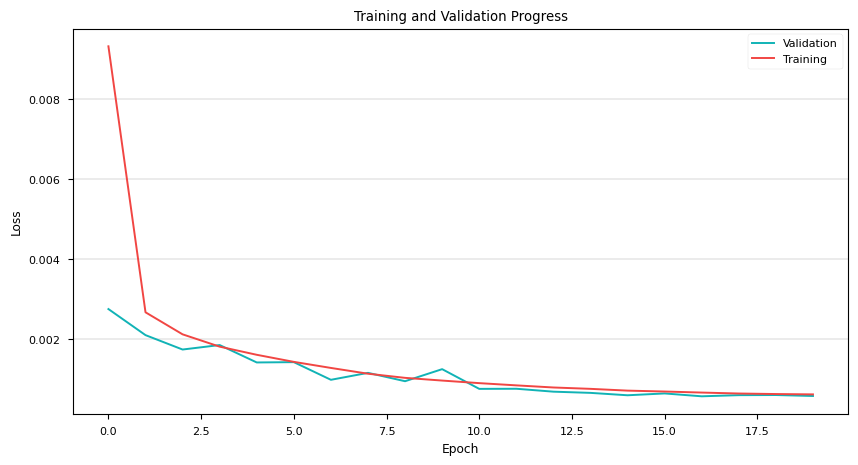

In [84]:
# 构造参数字典
params3 = {
    "task_args":{
        "columns": ['load', 'temp'],
        "target": ["load", 'temp'],
        "features": 'M'
    },
    "train_args": {
        "model_name": BiLED,
        "train_loader": train_loader,
        "valid_loader": valid_loader,
        "n_epochs": 20,
        "learning_rate": 0.001,
        "loss": nn.MSELoss(),
        "patience": 3,
        "device": 'cuda',
        "lradj": 'cosine',
        "model_path": "../outputs/best_models/BiLED",
        "verbose": True,
        "plots": True,
    },
    "model_args": {
        'seq_len': 6,
        'pred_len': 3,
        "label_len": 0,
        'd_model': 128,
        'c_in': 2,
        'c_out': 2,
        'e_layers': 1,
        'd_layers': 1,
    },
}
model = train(**params3)

#### 模型测试

In [85]:
def test(task_args, test_args):
    # 参数配置
    columns = task_args['columns'] # 全部
    target = task_args['target'] 
    features = task_args['features'] 
    model = test_args['model'] 
    x_test = test_args['x_test'] 
    x_test_stamp = test_args['x_test_stamp']
    y_test = test_args['y_test'] 
    y_test_stamp = test_args['y_test_stamp']
    pred_len = test_args['pred_len'] 
    label_len = test_args['label_len']
    device = test_args['device'] # 训练设备，可选'cuda'和'cpu'
    test_path = test_args['test_path'] # 结果保存路径
    
    #检查是否可用GPU
    device = torch.device(device)

    # 评估指标函数
    def metric(pred, true):
        # a/b，其中生成的 NaN 或 Inf 替换为 0
        def divide_no_nan(a, b):
            result = a / b
            result[result != result] = .0
            result[np.inf in result] = .0
            result[np.nan in result] = .0
            return result
        # 残差的标准误差
        def RSE(pred, true):
            return np.sqrt(np.sum((true - pred) ** 2)) / np.sqrt(np.sum((true - true.mean()) ** 2))
        # 相关系数
        def CORR(pred, true):
            u = ((true - true.mean(0)) * (pred - pred.mean(0))).sum(0)
            d = np.sqrt(((true - true.mean(0)) ** 2 * (pred - pred.mean(0)) ** 2).sum(0))
            return (u / d).mean(-1)
        # 平均绝对误差
        def MAE(pred, true):
            return np.mean(np.abs(pred - true))
        # 均方误差
        def MSE(pred, true):
            return np.mean((pred - true) ** 2)
        # 均方根误差
        def RMSE(pred, true):
            return np.sqrt(MSE(pred, true))
        # 平均绝对百分比误差
        def MAPE(pred, true):
            return np.mean(np.abs(divide_no_nan((pred - true), true)))
        # 均方预测误差
        def MSPE(pred, true):
            return np.mean(np.square(divide_no_nan((pred - true), true)))
        # 结果汇总
        mae = MAE(pred, true)
        mse = MSE(pred, true)
        rmse = RMSE(pred, true)
        mape = MAPE(pred, true)
        mspe = MSPE(pred, true)
        print("mae: {:.4f}\nmse: {:.4f}\nrmse: {:.4f}\nmape: {:.4f}\nmspe: {:.4f}".format(mae, mse, rmse, mape, mspe))
        return mae, mse, rmse, mape, mspe
    
    def forecasting_task(columns, target, features):
        """
        features: [M, S, MS]; 
            M:multivariate predict multivariate, 
            S:univariate predict univariate, 
            MS:multivariate predict univariate'
        """
        # 字典索引生成
        col_dict = {}
        for i,j in enumerate(columns):
            col_dict[j] = i

        if features == 'MS':
            target = target[0]
            if target in columns:
                f_dim = col_dict[target]
            else:
                f_dim = 0
        elif features == 'S':
            f_dim = 0
        else:
            f_dim = 0
        return f_dim
    f_dim = forecasting_task(columns, target, features)
    
    # 设置保存模型路径
    if not os.path.exists(test_path):
        os.makedirs(test_path)
    
    # 关闭自动求导功能
    model.eval() # 一定要有
    with torch.no_grad():
        '''测试集设置'''
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        x_test_stamp = x_test_stamp.to(device)
        y_test_stamp = y_test_stamp.to(device)
        # decoder输入
        dec_inp = torch.zeros_like(y_test[:, -pred_len:, :]).float()
        dec_inp = torch.cat([y_test[:, -label_len:, :], dec_inp], dim=1).float().to(device)
        outputs = model(x_test, x_test_stamp, dec_inp, y_test_stamp)
        if features == 'MS':
            dec_inp = torch.cat([x_test[:, -label_len:, f_dim: f_dim+1], dec_inp], dim=1).float().to(device)
            y_pred = model(x_test, x_test_stamp, dec_inp, y_test_stamp)
            # y_pred = outputs[:, :, f_dim: f_dim+1] 
        else:
            dec_inp = torch.cat([x_test[:, -label_len:, f_dim:], dec_inp], dim=1).float().to(device)
            y_pred = model(x_test, x_test_stamp, dec_inp, y_test_stamp)
            # y_pred = outputs[:, :, f_dim:]
        # 评估指标计算
        y_pred = y_pred.cpu().detach().numpy()
        y_true = y_test.cpu().detach().numpy()
        mae, mse, rmse, mape, mspe = metric(y_pred, y_true)
        np.save(test_path + '/metrics.npy', np.array([mae, mse, rmse, mape, mspe]))
        np.save(test_path + '/pred.npy', y_pred)
        np.save(test_path + '/true.npy', y_true)
        
    return 0

In [86]:
# 构造参数字典
params4 = {
    "task_args":{
        "columns": ['load', 'temp'],
        "target": ['load', 'temp'],
        "features": 'M'
    },
    "test_args": {
        "model": model,
        "x_test": X_test,
        "x_test_stamp": X_test_stamp,
        "y_test": y_test,
        "y_test_stamp": y_test_stamp,
        'label_len': 0,
        'pred_len': 3,
        'device': 'cuda',
        'test_path': '../outputs/results/BiLED'
    }
}
res = test(**params4)

mae: 0.0694
mse: 0.0107
rmse: 0.1033
mape: 0.1822
mspe: 0.0907


#### 结果分析

In [87]:
def plot(task_args, plot_args):
    # 参数配置
    columns = task_args['columns'] # 全部
    target = task_args['target'] 
    features = task_args['features'] 
    drawing_point = plot_args['drawing_point'] # 绘图点
    model = plot_args['model'] 
    x_train = plot_args['x_train'] 
    x_train_stamp = plot_args['x_train_stamp']
    x_valid = plot_args['x_valid'] 
    x_valid_stamp = plot_args['x_valid_stamp']
    x_test = plot_args['x_test'] 
    x_test_stamp = plot_args['x_test_stamp']
    y_train = plot_args['y_train'] 
    y_train_stamp = plot_args['y_train_stamp']
    y_valid = plot_args['y_valid'] 
    y_valid_stamp = plot_args['y_valid_stamp']
    y_test = plot_args['y_test'] 
    y_test_stamp = plot_args['y_test_stamp']
    y_true = plot_args['y_true'] 
    seq_len = plot_args['seq_len']
    scaler = plot_args['scaler']
    pred_len = plot_args['pred_len'] 
    label_len = plot_args['label_len']
    device = plot_args['device'] # 训练设备，可选'cuda'和'cpu'
    option = plot_args['option'] # 绘图选项，可选'part','full'
    figure_path = plot_args['figure_path'] # 图片保存路径
    seq_len = seq_len - 1 # 包含当前时间点
    
    #检查是否可用GPU
    device = torch.device(device)
    
    # 任务分类
    def forecasting_task(columns, target, features, drawing_point):
        """
        features: [M, S, MS]; 
            M:multivariate predict multivariate, 
            S:univariate predict univariate, 
            MS:multivariate predict univariate'
        """
        # 字典索引生成
        col_dict = {}
        for i,j in enumerate(columns):
            col_dict[j] = i

        if features == 'MS':
            target = target[0]
            if target in columns:
                f_dim = col_dict[target]
            else:
                f_dim = 0
        elif features == 'S':
            f_dim = 0
        else:
            f_dim = 0

        if drawing_point in columns:
            d_dim = col_dict[drawing_point]
        else:
            d_dim = 0
        return f_dim, d_dim
    f_dim, d_dim = forecasting_task(columns, target, features, drawing_point)
        
    # 数据集长度
    train_size = len(x_train) + seq_len + pred_len
    valid_size = len(x_valid) + seq_len + pred_len
    test_size = len(x_test) + seq_len + pred_len
    
    # 时间序列形状
    timeseries_y = y_true.values[:, d_dim].reshape(-1, 1)
    timeseries_x = y_true.index
    
    # 关闭自动求导功能
    model.eval() # 一定要有
    with torch.no_grad():
        '''训练集设置'''
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        x_train_stamp = x_train_stamp.to(device)
        y_train_stamp = y_train_stamp.to(device)
        # decoder输入
        B, _, _ = x_train.shape
        dec_inp = torch.zeros((B, pred_len, len(target))).float().to(device)
        if features == 'S' or features == 'M':
            dec_inp = torch.cat([x_train[:, -label_len:, f_dim:], dec_inp], dim=1).float()
            y_pred = model(x_train, x_train_stamp, dec_inp, y_train_stamp)
            y_pred = y_pred.cpu().detach().numpy() # 首先将张量移动到CPU，然后从计算图中分离，最后转换为NumPy数组
            y_pred = scaler.inverse_transform(y_pred[:, 0, :].reshape(-1, len(columns))) # 反归一化
            y_pred = y_pred[:, d_dim:d_dim+1]
        else:
            dec_inp = torch.cat([x_train[:, -label_len:, f_dim: f_dim+1], dec_inp], dim=1).float()
            y_pred = model(x_train, x_train_stamp, dec_inp, y_train_stamp)
            y_pred = y_pred.cpu().detach().numpy() # 首先将张量移动到CPU，然后从计算图中分离，最后转换为NumPy数组
            y_pred = scaler.inverse_transform(y_pred[:, 0, :].reshape(-1, 1)) # 反归一化
        train_plot_y = [np.nan]*(seq_len+1) + list(y_pred.reshape(-1, ))+ [np.nan]*(pred_len-1)
        train_plot_x = timeseries_x[: train_size]
        
        '''验证集设置'''
        x_valid = x_valid.to(device)
        y_valid = y_valid.to(device)
        x_valid_stamp = x_valid_stamp.to(device)
        y_valid_stamp = y_valid_stamp.to(device)
        # decoder输入
        B, _, _ = x_valid.shape
        dec_inp = torch.zeros((B, pred_len, len(target))).float().to(device)
        if features == 'S' or features == 'M':
            dec_inp = torch.cat([x_valid[:, -label_len:, f_dim:], dec_inp], dim=1).float()
            y_pred = model(x_valid, x_valid_stamp, dec_inp, y_valid_stamp)
            y_pred = y_pred.cpu().detach().numpy() 
            y_pred = scaler.inverse_transform(y_pred[:, 0, :].reshape(-1, len(columns))) # 反归一化
            y_pred = y_pred[:, d_dim:d_dim+1]
        else:
            dec_inp = torch.cat([x_valid[:, -label_len:, f_dim: f_dim+1], dec_inp], dim=1).float()
            y_pred = model(x_valid, x_valid_stamp, dec_inp, y_valid_stamp)
            y_pred = y_pred.cpu().detach().numpy() 
            y_pred = scaler.inverse_transform(y_pred[:, 0, :].reshape(-1, 1)) # 反归一化
        valid_plot_y = [np.nan]*(seq_len+1) + list(y_pred.reshape(-1, ))+ [np.nan]*(pred_len-1)
        valid_plot_x = timeseries_x[train_size: train_size+valid_size]
        
        '''测试集设置'''
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        x_test_stamp = x_test_stamp.to(device)
        y_test_stamp = y_test_stamp.to(device)
        # decoder输入
        B, _, _ = x_test.shape
        dec_inp = torch.zeros((B, pred_len, len(target))).float().to(device)
        if features == 'S' or features == 'M':
            dec_inp = torch.cat([x_test[:, -label_len:, f_dim:], dec_inp], dim=1).float()
            y_pred = model(x_test, x_test_stamp, dec_inp, y_test_stamp)
            y_pred = y_pred.cpu().detach().numpy() 
            y_pred = scaler.inverse_transform(y_pred[:, 0, :].reshape(-1, len(columns))) # 反归一化
            y_pred = y_pred[:, d_dim:d_dim+1]
        else:
            dec_inp = torch.cat([x_test[:, -label_len:, f_dim: f_dim+1], dec_inp], dim=1).float()
            y_pred = model(x_test, x_test_stamp, dec_inp, y_test_stamp)
            y_pred = y_pred.cpu().detach().numpy() 
            y_pred = scaler.inverse_transform(y_pred[:, 0, :].reshape(-1, 1)) # 反归一化
        test_plot_y = [np.nan]*(seq_len+1) + list(y_pred.reshape(-1, )) + [np.nan]*(pred_len-1)
        test_plot_x = timeseries_x[train_size+valid_size: train_size+valid_size+test_size]
        
    # 设置保存图片路径
    if not os.path.exists(figure_path):
        os.makedirs(figure_path)
    figure_path = figure_path + '/' + target[0] + '_' + option + '.png'

    # 全局静态图
    def static_full_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, 
                               valid_plot_x, valid_plot_y, test_plot_x, test_plot_y, figure_path):
        #绘图，原始图，训练图，验证图，测试图
        fig = plt.figure(1, (10, 5))
        ax = fig.add_subplot(1,1,1)
        plt.style.use('seaborn-v0_8-paper') #绘制背景色
        plt.grid(axis = 'y',linewidth=0.35) #绘制网格
        plt.title('true-predict-curve ') #图标题
        plt.xticks(rotation = 45) #rotation文字旋转方向
        ax.plot(timeseries_x, timeseries_y, linestyle='-',color = '#11b3b6',label = 'true_curve')
        ax.plot(train_plot_x, train_plot_y, linestyle='--',label = 'train_predict_curve')
        ax.plot(valid_plot_x, valid_plot_y, linestyle='--',label = 'valid_predict_curve')
        ax.plot(test_plot_x, test_plot_y, linestyle='--',label = 'test_predict_curve')
        ax.legend(frameon=False) #绘制图例
        plt.xlabel('Time')
        plt.ylabel('Values')
        plt.savefig(figure_path, dpi=600)
        plt.show()

    # 局部静态图
    def static_part_timeseries(timeseries_x, timeseries_y, test_plot_x, test_plot_y, figure_path):
        timeseries_x = timeseries_x[timeseries_x >= test_plot_x[0]]
        timeseries_y = timeseries_y[timeseries_y.shape[0] - len(test_plot_x):,:]
        #绘图，原始图，训练图，验证图，测试图
        fig = plt.figure(1, (10, 5))
        ax = fig.add_subplot(1,1,1)
        plt.style.use('seaborn-v0_8-paper') #绘制背景色
        plt.grid(axis = 'y',linewidth=0.35) #绘制网格
        plt.title('true-predict-curve ') #图标题
        plt.xticks(rotation = 45) #rotation文字旋转方向
        ax.plot(timeseries_x, timeseries_y, linestyle='-',label = 'true_curve')
        ax.plot(test_plot_x, test_plot_y, linestyle='--',label = 'predict_curve')
        ax.legend(frameon=False) #绘制图例
        plt.xlabel('Time')
        plt.ylabel('Values')
        plt.savefig(figure_path, dpi=600)
        plt.show()

    # 全局动态图
    def dynamic_full_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y):
        # 准备画布
        fig = go.Figure()
    
        # 添加实际数据
        fig.add_trace(
            go.Scatter(
                x=timeseries_x,
                y=timeseries_y.reshape(timeseries_y.shape[0], ),
                mode='lines',
                name='true_curve',
                line = dict(color=None, width=2, dash=None)
            ))
    
        # 添加训练预测数据
        fig.add_trace(
            go.Scatter(
                x=train_plot_x,
                y=train_plot_y,
                mode='lines',
                name='train_predict_curve',
                line = dict(color=None, width=2, dash=None)
            ))
    
        # 添加验证预测数据
        fig.add_trace(
            go.Scatter(
                x=valid_plot_x,
                y=valid_plot_y,
                mode='lines',
                name='valid_predict_curve',
                line = dict(color=None, width=2, dash=None)
            ))
    
        # 添加测试预测数据
        fig.add_trace(
            go.Scatter(
                x=test_plot_x,
                y=test_plot_y,
                mode='lines',
                name='test_predict_curve',
                line = dict(color=None, width=2, dash=None)
            ))
    
        #更新图表的排版
        fig.update_layout(
            title='true-predict-curve',
            xaxis=dict(title="date"),
            yaxis=dict(title="values"),
            width=900,  #图表宽度
            height=500,  #图表长度
            template="simple_white"  #图表风格
        )
    
        fig.show()

    # 局部动态图
    def dynamic_part_timeseries(timeseries_x, timeseries_y, test_plot_x, test_plot_y):
        timeseries_x = timeseries_x[timeseries_x >= test_plot_x[0]]
        timeseries_y = timeseries_y[timeseries_y.shape[0] - len(test_plot_x):,:]
        # 准备画布
        fig = go.Figure()
    
        # 添加实际数据
        fig.add_trace(
            go.Scatter(
                x=timeseries_x,
                y=timeseries_y.reshape(timeseries_y.shape[0], ),
                mode='lines',
                name='true_curve',
                line = dict(color=None, width=2, dash=None)
            ))
    
        # 添加测试预测数据
        fig.add_trace(
            go.Scatter(
                x=test_plot_x,
                y=test_plot_y,
                mode='lines',
                name='predict_curve',
                line = dict(color=None, width=2, dash=None)
            ))
    
        #更新图表的排版
        fig.update_layout(
            title='true-predict-curve',
            xaxis=dict(title="date"),
            yaxis=dict(title="values"),
            width=900,  #图表宽度
            height=500,  #图表长度
            template="simple_white"  #图表风格
        )
    
        fig.show()

    # 绘图选项，可选'part','full','dynamic_part','dynamic_full'
    if option == 'part':
        # 局部静态图
        static_part_timeseries(timeseries_x, timeseries_y, test_plot_x, test_plot_y, figure_path)
    elif option == 'full':
        # 全局静态图
        static_full_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, 
                               valid_plot_x, valid_plot_y, test_plot_x, test_plot_y, figure_path)
    elif option == 'dynamic_full':
        # 全局动态图
        dynamic_full_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, 
                               valid_plot_x, valid_plot_y, test_plot_x, test_plot_y)
    elif option == 'dynamic_part':
        # 局部动态图
        dynamic_part_timeseries(timeseries_x, timeseries_y, test_plot_x, test_plot_y)
    else:
        raise ValueError("only support 'part','full','dynamic_part','dynamic_part'")
        
    return 0

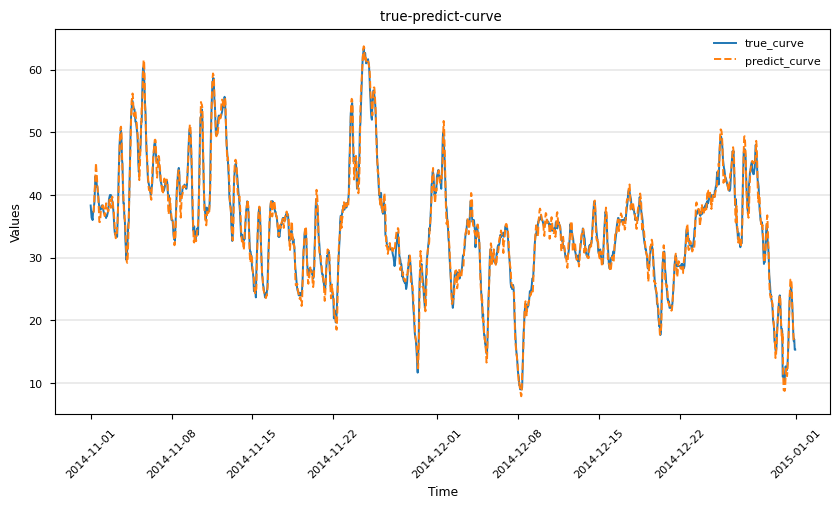

0

In [88]:
# 构造参数字典
params5 = {
    "task_args":{
        "columns": ['load', 'temp'],
        "target": ['load', 'temp'],
        "features": 'M'
    },
    "plot_args": {
        "drawing_point": 'temp',
        "model": model,
        "x_train": X_train,
        "x_valid": X_valid,
        "x_test": X_test,
        "x_train_stamp": X_train_stamp,
        "x_valid_stamp": X_valid_stamp,
        "x_test_stamp": X_test_stamp,
        "y_train": y_train,
        "y_valid": y_valid,
        "y_test": y_test,
        "y_train_stamp": y_train_stamp,
        "y_valid_stamp": y_valid_stamp,
        "y_test_stamp": y_test_stamp,
        "y_true": ts_data,
        "seq_len": 6,
        "pred_len": 3,
        "label_len": 0,
        "scaler": y_scaler,
        "device": 'cuda',
        "option": 'part',
        "figure_path": '../outputs/images/BiLED'
    }
}
plot(**params5)

#### 模型预测

In [89]:
def predict(task_args, predict_args, model_args):
    # 参数配置
    columns = task_args['columns']
    target = task_args['target'] 
    time_col = predict_args['time_col']
    features = task_args['features'] 
    freq = predict_args['freq']
    model_name = predict_args['model_name'] 
    x_true = predict_args['x_true'] 
    scaler_path = predict_args['scaler_path']
    model_path = predict_args['model_path'] 
    device = predict_args['device'] # 预测设备，可选'cuda'和'cpu'
    pred_len = model_args['pred_len'] 
    label_len = model_args['label_len']

    #检查是否可用GPU
    device = torch.device(device)

    # 读取归一化参数
    x_scaler = joblib.load(scaler_path + "/x_scaler.pkl")
    y_scaler = joblib.load(scaler_path + "/y_scaler.pkl")

    # 加载模型
    model = model_name(**model_args)
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)

    # 生成固定长度的时间范围
    x_true = loader(data_path=None, data=x_true, time_col=time_col) # 原始数据
    x_true = x_true[columns]
    timedelta = x_true.index[-1] - x_true.index[-2] # 时间差
    if label_len != 0:
        y_stamp = pd.date_range(start=x_true.index[-label_len], 
                                end=x_true.index[-label_len]+timedelta*(label_len+pred_len-1), 
                                freq=freq)
    else:
        y_stamp = pd.date_range(start=x_true.index[-1]+timedelta*(label_len+1), 
                                end=x_true.index[-1]+timedelta*(label_len+pred_len), 
                                freq=freq) 
    x_stamp = time_features(pd.to_datetime(x_true.index), freq=freq) # x时间戳数据
    x_stamp = x_stamp.transpose(1, 0)
    y_time = y_stamp
    y_stamp = time_features(y_stamp, freq=freq) # y时间戳数据
    y_stamp = y_stamp.transpose(1, 0)
    

    # 转换类型
    x_true[columns] = x_scaler.transform(x_true) # 归一化
    x_true = x_true.values.astype('float32')
    x_true = torch.as_tensor(x_true).unsqueeze(0).float() # 转为张量
    x_stamp = torch.as_tensor(x_stamp).unsqueeze(0).float()
    y_stamp = torch.as_tensor(y_stamp).unsqueeze(0).float()
    
    # 任务分类
    def forecasting_task(columns, target, features):
        """
        features: [M, S, MS]; 
            M:multivariate predict multivariate, 
            S:univariate predict univariate, 
            MS:multivariate predict univariate'
        """
        # 字典索引生成
        col_dict = {}
        for i,j in enumerate(columns):
            col_dict[j] = i

        if features == 'MS':
            target = target[0]
            if target in columns:
                f_dim = col_dict[target]
            else:
                f_dim = 0
        elif features == 'S':
            f_dim = 0
        else:
            f_dim = 0
        return f_dim
    f_dim = forecasting_task(columns, target, features)

    # 关闭自动求导功能
    model.eval() # 一定要有
    with torch.no_grad():
        x_true = x_true.to(device)
        x_stamp = x_stamp.to(device)
        y_stamp = y_stamp.to(device)
        # decoder输入
        B, _, _ = x_true.shape
        dec_inp = torch.zeros((B, pred_len, len(target))).float().to(device)
        if features == 'MS':
            dec_inp = torch.cat([x_true[:, -label_len:, f_dim: f_dim+1], dec_inp], dim=1).float()
            y_pred = model(x_true, x_stamp, dec_inp, y_stamp)
            y_pred = y_pred.cpu().detach().numpy() 
            y_pred = y_scaler.inverse_transform(y_pred[-1, :, :]) # 反归一化
            # y_pred = y_pred[:, f_dim: f_dim+1]
        else:
            dec_inp = torch.cat([x_true[:, -label_len:, f_dim:], dec_inp], dim=1).float()
            y_pred = model(x_true, x_stamp, dec_inp, y_stamp)
            y_pred = y_pred.cpu().detach().numpy() 
            y_pred = y_scaler.inverse_transform(y_pred[-1, :, :]) # 反归一化
            # y_pred = y_pred[:, f_dim:]

    # 输出为dataframe
    y_pred = pd.DataFrame(data=y_pred, index=y_time[-pred_len:], columns=target)
    
    return y_pred

In [90]:
# 构造参数字典
params6 = {
    "task_args":{
        "columns": ['load', 'temp'],
        "target": ['load', 'temp'],
        "features": 'M',
    },
    "predict_args": {
        "time_col": 'time',
        "freq": 'h',
        "model_name": BiLED,
        "model_path": "../outputs/best_models/BiLED/checkpoint.pth",
        "x_true": pd.read_csv(data_path).iloc[:6, :],
        "scaler_path": '../outputs/scalers/BiLED',
        "device": 'cpu'
    },
    "model_args": {
        'seq_len': 6,
        'pred_len': 3,
        "label_len": 0,
        'd_model': 128,
        'c_in': 2,
        'c_out': 2,
        'e_layers': 1,
        'd_layers': 1,
    },
}
y_pred = predict(**params6)

In [91]:
y_pred

,load,temp
2012-01-01 06:00:00,2521.520508,31.684967
2012-01-01 07:00:00,2751.319092,32.006138
2012-01-01 08:00:00,3024.335449,32.786758


## Bi-GRU-Encoder-Decoder

### 多输入多输出多步预测

#### 数据准备

In [3]:
# 读取数据
def loader(data_path=None, data=None, time_col=None, datetime=None, freq=None):
    """
    读取数据，并对输入数据时间列进行处理

    参数说明
    ----------
    data_path : {str}
        输入数据地址，如果为空，读取已有数据
    data : {DataFrame} of shape (n_samples, n_features)
        输入数据，如果需读取本地数据，将该值置空，否则传入已有数据
    time_col : {str}
        输入数据的时间列，如果没有时间列，生成时间戳范围，或者生成固定频率的时间戳数据
    datetime : {str} 
        时间列开始时间，如果time_col为空，需填入此项，格式为%Y-%m-%d %H:%M:%S
    freq : {int}
        时间序列频率，单位为秒

    返回值
    -------
    data : {DataFrame} of shape (n_samples, n_features)
        经过时间序列处理后的数据
    """
    # 读取原始数据
    if data_path == None:
        if data.empty is True:
            raise ValueError("data is not exist!")
        else:
            data = data
    else:
        data = pd.read_csv(data_path)
    
    # 时间列处理
    if time_col == None:
        # 筛选输入频率
        re_1 = re.findall('[0-9]', freq)
        re_2 = re.findall('[a-z]', freq)
        # 识别数字频率
        if len(re_1) == 0:
            nums = 1
        else:
            nums = int(''.join(re_1))
        # 识别频率
        fr = re_2[0]
        # 生成时间间隔
        if fr == 's':
            time_index = pd.date_range(start=pd.to_datetime(datetime),
                                       end=pd.to_datetime(datetime) +
                                       timedelta(seconds=(data.shape[0] - 1)*nums),
                                       freq=freq)
        elif fr == 't':
            time_index = pd.date_range(start=pd.to_datetime(datetime),
                                       end=pd.to_datetime(datetime) +
                                       timedelta(minutes=(data.shape[0] - 1)*nums),
                                       freq=freq)
        elif fr == 'h':
            time_index = pd.date_range(start=pd.to_datetime(datetime),
                                       end=pd.to_datetime(datetime) +
                                       timedelta(hours=(data.shape[0] - 1)*nums),
                                       freq=freq)
        elif fr == 'd':
            time_index = pd.date_range(start=pd.to_datetime(datetime),
                                       end=pd.to_datetime(datetime) +
                                       timedelta(days=(data.shape[0] - 1)*nums),
                                       freq=freq)
        full_data = pd.DataFrame(data=data.values,
                                 index=pd.to_datetime(time_index, unit=freq),
                                 columns=data.columns)
    else:
        columns = [i for i in data.columns if i != time_col] # 去除时间列
        full_data = pd.DataFrame(data=data.drop([time_col], axis=1).values,
                                 index=pd.to_datetime(data[time_col].values),
                                 columns=columns)
    return full_data

In [97]:
data_path = "../outputs/datasets/energy.csv"
ts_data = loader(data_path=data_path, data=None, time_col='time')
ts_data

,load,temp
2012-01-01 00:00:00,2698.0,32.00
2012-01-01 01:00:00,2558.0,32.67
2012-01-01 02:00:00,2444.0,30.00
2012-01-01 03:00:00,2402.0,31.00
2012-01-01 04:00:00,2403.0,32.00
...,...,...
2014-12-31 19:00:00,4012.0,18.00
2014-12-31 20:00:00,3856.0,16.67
2014-12-31 21:00:00,3671.0,17.00
2014-12-31 22:00:00,3499.0,15.33


In [98]:
# 时间格式编码
def time_features_from_frequency_str(freq_str: str):
    """
    Returns a list of time features that will be appropriate for the given frequency string.
    Parameters
    ----------
    freq_str
        Frequency string of the form [multiple][granularity] such as "12H", "5min", "1D" etc.
    """

    class TimeFeature:
        def __init__(self):
            pass

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            pass

        def __repr__(self):
            return self.__class__.__name__ + "()"


    class SecondOfMinute(TimeFeature):
        """Minute of hour encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return index.second / 59.0 - 0.5


    class MinuteOfHour(TimeFeature):
        """Minute of hour encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return index.minute / 59.0 - 0.5


    class HourOfDay(TimeFeature):
        """Hour of day encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return index.hour / 23.0 - 0.5


    class DayOfWeek(TimeFeature):
        """Hour of day encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return index.dayofweek / 6.0 - 0.5


    class DayOfMonth(TimeFeature):
        """Day of month encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return (index.day - 1) / 30.0 - 0.5


    class DayOfYear(TimeFeature):
        """Day of year encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return (index.dayofyear - 1) / 365.0 - 0.5


    class MonthOfYear(TimeFeature):
        """Month of year encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return (index.month - 1) / 11.0 - 0.5


    class WeekOfYear(TimeFeature):
        """Week of year encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return (index.isocalendar().week - 1) / 52.0 - 0.5

    
    features_by_offsets = {
        offsets.YearEnd: [],
        offsets.QuarterEnd: [MonthOfYear],
        offsets.MonthEnd: [MonthOfYear],
        offsets.Week: [DayOfMonth, WeekOfYear],
        offsets.Day: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.BusinessDay: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Hour: [HourOfDay, DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Minute: [
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
        offsets.Second: [
            SecondOfMinute,
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
    }

    offset = to_offset(freq_str)

    for offset_type, feature_classes in features_by_offsets.items():
        if isinstance(offset, offset_type):
            return [cls() for cls in feature_classes]

    supported_freq_msg = f"""
    Unsupported frequency {freq_str}
    The following frequencies are supported:
        Y   - yearly
            alias: A
        M   - monthly
        W   - weekly
        D   - daily
        B   - business days
        H   - hourly
        T   - minutely
            alias: min
        S   - secondly
    """
    raise RuntimeError(supported_freq_msg)
    
def time_features(dates, freq='h'):
    return np.vstack([feat(dates) for feat in time_features_from_frequency_str(freq)])

In [3]:
# 包含时间维度的数据集划分
def divider(df, train_ratio, valid_ratio, x_feature_list, y_feature_list, freq, scaler_path):
    """
    读取数据，并对数据进行划分

    参数说明
    ----------
    df : {DataFrame} of shape (n_samples, n_features)
        输入数据
    train_ratio : {float}
        用于训练的数据集占比:将数据按照一定比例进行切分，取值范围为(0,1)
    valid_ratio : {float}
        用于验证的数据集占比:将数据按照一定比例进行切分，取值范围为(0,1)
    x_feature_list : {list[str]} 
        训练特征列，不包含时间列
    y_feature_list : {list[str]} 
        目标特征列，不包含时间列
    freq : {str}
        用来编码时间特征的频率，可选[s:秒,t:分,h:时,d:天,b:工作日,w:周,m:月]，频率越低，模型可能越精确
    scaler_path : {str} 
        数据归一化模型保存地址

    返回值
    -------
    x_scaler : {sklearn.preprocessing.MinMaxScaler}
        训练特征列归一化器
    y_scaler : {sklearn.preprocessing.MinMaxScaler}
        目标特征列归一化器
    train : {list[DataFrame]}
        训练特征数据，目标特征数据，时间特征数据
    valid : {list[DataFrame]}
        验证特征数据，目标特征数据，时间特征数据
    test : {list[DataFrame]}
        测试特征数据，目标特征数据，时间特征数据
    """
    #归一化
    x_scaler = MinMaxScaler() # 保证数据同分布
    y_scaler = MinMaxScaler()
    x_scaler = x_scaler.fit(df.copy()[x_feature_list]) 
    y_scaler = y_scaler.fit(df.copy()[y_feature_list])

    # 设置保存归一化参数路径
    if not os.path.exists(scaler_path):
        os.makedirs(scaler_path)

    # 保存归一化参数
    joblib.dump(x_scaler, scaler_path + "/x_scaler.pkl")
    joblib.dump(y_scaler, scaler_path + "/y_scaler.pkl")

    #测试集
    train = df.copy().iloc[:int(df.shape[0]*train_ratio), :][x_feature_list]
    train_stamp = time_features(pd.to_datetime(train.index), freq=freq)
    train_stamp = train_stamp.transpose(1, 0)
    train[x_feature_list] = x_scaler.transform(train)
    xtr = train.values.astype('float32')
    ytr = df.copy().iloc[:int(df.shape[0]*train_ratio), :][y_feature_list]
    ytr[y_feature_list] = y_scaler.transform(ytr)
    ytr = ytr.values.astype('float32')
    train = [xtr, ytr, train_stamp]

    #验证集
    valid = df.copy().iloc[int(df.shape[0]*train_ratio): int(df.shape[0]*(train_ratio+valid_ratio)), :][x_feature_list]
    valid_stamp = time_features(pd.to_datetime(valid.index), freq=freq)
    valid_stamp = valid_stamp.transpose(1, 0)
    valid[x_feature_list] = x_scaler.transform(valid)
    xva = valid.values.astype('float32')
    yva = df.copy().iloc[int(df.shape[0]*train_ratio): int(df.shape[0]*(train_ratio+valid_ratio)), :][y_feature_list]
    yva[y_feature_list] = y_scaler.transform(yva)
    yva = yva.values.astype('float32')
    valid = [xva, yva, valid_stamp]

    #测试集
    if train_ratio + valid_ratio != 1:
        test = df.copy().iloc[int(df.shape[0]*(train_ratio+valid_ratio)):, :][x_feature_list]
        test_stamp = time_features(pd.to_datetime(test.index), freq=freq)
        test_stamp = test_stamp.transpose(1, 0)
        test[x_feature_list] = x_scaler.transform(test)
        xte = test.values.astype('float32')
        yte = df.copy().iloc[int(df.shape[0]*(train_ratio+valid_ratio)):, :][y_feature_list]
        yte[y_feature_list] = y_scaler.transform(yte)
        yte = yte.values.astype('float32')
        test = [xte, yte, test_stamp]
    else:
        test = [np.array(0), np.array(0), np.array(0)]
    
    return x_scaler, y_scaler, train, valid, test

In [100]:
# 构造参数字典
params1 = {
    "df": ts_data,
    "train_ratio": 0.7,
    "valid_ratio": 0.1,
    "x_feature_list": ["load", 'temp'],
    "y_feature_list": ["load", 'temp'],
    "freq": 'h',
    "scaler_path": '../outputs/scalers/BiGED'
}

#函数传参
x_scaler, y_scaler, train_data, valid_data, test_data = divider(**params1)
print("x_train shape: {0} y_train shape: {1} stamp_train shape: {2}".format(train_data[0].shape, train_data[1].shape, train_data[2].shape))
print("x_valid shape: {0} y_valid shape: {1} stamp_valid shape: {2}".format(valid_data[0].shape, valid_data[1].shape, valid_data[2].shape))
print("x_test shape: {0} y_test shape: {1} stamp_test shape: {2}".format(test_data[0].shape, test_data[1].shape, test_data[2].shape))

x_train shape: (23376, 2) y_train shape: (23376, 2) stamp_train shape: (23376, 4)
x_valid shape: (1464, 2) y_valid shape: (1464, 2) stamp_valid shape: (1464, 4)
x_test shape: (1464, 2) y_test shape: (1464, 2) stamp_test shape: (1464, 4)


In [6]:
# 利用前seq_len个数据，预测下pred_len个数据
def generator(data_list, seq_len, pred_len, label_len, batch_size, sample_freq: int = 1):
    """
    读取数据，并对数据进行划分

    参数说明
    ----------
    data_list : {list[DataFrame]}
        输入特征数据，目标特征数据，时间特征数据
    seq_len : {int}
        输入数据包含过去多少个时间步，正整数
    pred_len : {int}
        目标应该在未来多少个时间步之后，正整数
    label_len : {int} 
        先验时间步
    batch_size : {int} 
        输入数据的批次大小，正整数
    sample_freq : {int} 
        采样频率，正整数

    返回值
    -------
    X : {torch.Tensor}
        特征数据张量
    y : {torch.Tensor}
        目标数据张量
    X_stamp : {torch.Tensor}
        特征时间编码张量
    y_stamp : {torch.Tensor}
        目标时间编码张量
    data_loader : {torch.utils.data.dataloader.DataLoader}
        数据加载器，[特征，目标，特征时间编码，目标时间编码]
    """
    # 获取数据
    feature = data_list[0] # 特征
    target = data_list[1] # 目标
    stamp = data_list[2] # 时间戳
    
    # 循环生成数据
    X, y = [], []
    X_stamp, y_stamp = [], []
    seq_len = seq_len - 1 # 包含当前时间点
    for i in range(seq_len, len(feature) - pred_len, sample_freq):
        # 数据维度
        feat = feature[i - seq_len:i + 1]
        tar = target[i + 1:i + 1 + pred_len]
        X.append(np.array(feat))
        y.append(np.array(tar))
        
        # 时间维度
        xs = stamp[i - seq_len:i + 1]
        ys = stamp[i + 1 - label_len:i + 1 + pred_len]
        X_stamp.append(np.array(xs))
        y_stamp.append(np.array(ys))
        
    # 转为张量，数据维度
    X = torch.as_tensor(X).float()
    y = torch.as_tensor(y).float()
    
    # 转为张量，时间维度
    X_stamp = torch.as_tensor(X_stamp).float()
    y_stamp = torch.as_tensor(y_stamp).float()
    
    # 创建dataloader，[特征，目标，特征时间编码，目标时间编码]
    data_loader = DataLoader(TensorDataset(X, y, X_stamp, y_stamp), shuffle=True, batch_size=batch_size)
    
    return X, y, X_stamp, y_stamp, data_loader

In [102]:
# 构造参数字典
params2 = {
    "seq_len": 6,
    "pred_len": 3,
    "label_len": 0,
    "batch_size": 32,
}
X_train, y_train, X_train_stamp, y_train_stamp, train_loader = generator(train_data, **params2)
X_valid, y_valid, X_valid_stamp, y_valid_stamp, valid_loader = generator(valid_data, **params2)
X_test, y_test, X_test_stamp, y_test_stamp, test_loader = generator(test_data, **params2)
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_train.shape, y_train.shape, len(train_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_valid.shape, y_valid.shape, len(valid_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_test.shape, y_test.shape, len(test_loader)))

X_size: torch.Size([23368, 6, 2]),y_size: torch.Size([23368, 3, 2]),loader_len: 731
X_size: torch.Size([1456, 6, 2]),y_size: torch.Size([1456, 3, 2]),loader_len: 46
X_size: torch.Size([1456, 6, 2]),y_size: torch.Size([1456, 3, 2]),loader_len: 46


#### 模型定义

In [103]:
# BiGED模型
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, e_layers):
        super(Encoder, self).__init__()
        # GRU层将输入序列映射到隐藏状态空间，双向GRU
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers=e_layers, batch_first=True, bidirectional=True)

    def forward(self, x):
        # 将输入序列传入GRU层，返回隐藏状态
        _, hidden = self.gru(x)
        return hidden

# 定义解码器模型
class Decoder(nn.Module):
    def __init__(self, hidden_dim, out_dim, d_layers):
        super(Decoder, self).__init__()
        # GRU层将解码器输入映射到隐藏状态空间
        self.gru = nn.GRU(out_dim, hidden_dim, num_layers=d_layers, batch_first=True, bidirectional=True)
        # dropout操作层
        self.dropout = nn.Dropout(0.1)
        # 线性层将解码器输出映射到指定输出维度，线性层输入维度为hidden_dim*2
        self.out = nn.Linear(hidden_dim*2, out_dim)

    def forward(self, y, hidden):
        # 将输入序列传入GRU层，返回输出、隐藏状态
        output, hidden = self.gru(y, hidden)
        output = self.dropout(output)
        # 使用线性层映射到输出维度
        output = self.out(output)
        return output, hidden

# BiGED模型
class BiGED(nn.Module):
    def __init__(self, seq_len, pred_len, label_len, c_in, d_model, c_out, e_layers, d_layers):
        super(BiGED, self).__init__()
        self.pred_len = pred_len
        # 创建编码器和解码器实例
        self.encoder = Encoder(c_in, d_model, e_layers)
        self.decoder = Decoder(d_model, c_out, d_layers)

    def forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec):
        # 编码器处理输入序列
        encoder_hidden = self.encoder(x_enc)
        # 解码器初始化隐藏状态和细胞状态，让解码器的隐藏层状态等于编码器的隐藏层状态
        decoder_hidden = encoder_hidden
        # 解码器处理目标序列
        dec_out, _ = self.decoder(x_dec, decoder_hidden)
        output = dec_out[:, -self.pred_len:, :]  # [B, L, D]
        
        return output

#### 模型训练

In [104]:
def train(task_args, train_args, model_args):
    # 参数配置
    columns = task_args['columns'] # 模型全部特征
    target = task_args['target'] # 模型预测特征
    features = task_args['features'] # 模型预测模式
    model_name = train_args['model_name'] # 模型名称
    train_loader = train_args['train_loader'] # 训练集
    valid_loader = train_args['valid_loader'] # 验证集
    n_epochs = train_args['n_epochs'] # 训练次数
    learning_rate = train_args['learning_rate'] # 学习率
    loss = train_args['loss'] # 损失函数
    patience = train_args['patience'] # 最大早停次数阈值，超过就会早停
    lradj = train_args['lradj'] # 学习率函数
    model_path = train_args['model_path'] # 模型保存路径
    verbose = train_args['verbose'] # 打印训练过程
    plots = train_args['plots'] # 绘制损失图
    device = train_args['device'] # 训练设备，可选'cuda'和'cpu'
    pred_len = model_args['pred_len'] # 预测长度
    label_len = model_args['label_len']
    
    #检查是否可用GPU
    device = torch.device(device)
    
    # 创建模型和优化器
    model = model_name(**model_args).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = loss
    
    # 调整学习率
    def adjust_learning_rate(optimizer, epoch, lradj, learning_rate, train_epochs):
        # lr = learning_rate * (0.2 ** (epoch // 2))
        if lradj == 'type1':
            lr_adjust = {epoch: learning_rate * (0.5 ** ((epoch - 1) // 1))}
        elif lradj == 'type2':
            lr_adjust = {
                2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6,
                10: 5e-7, 15: 1e-7, 20: 5e-8
            }
        elif lradj == "cosine":
            lr_adjust = {epoch: learning_rate /2 * (1 + math.cos(epoch / train_epochs * math.pi))}
        if epoch in lr_adjust.keys():
            lr = lr_adjust[epoch]
            # 参数组(param_groups)是用来指定不同的参数组以便对它们进行不同的优化设置，比如'lr'
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
            print('Updating learning rate to {}'.format(lr))
    
    # 设置早停
    class EarlyStopping():
        def __init__(self, patience=7, verbose=False, delta=0):
            self.patience = patience # 连续超限次数，如果满足条件，则早停
            self.verbose = verbose
            self.counter = 0
            self.best_score = None
            self.early_stop = False
            self.val_loss_min = np.Inf
            self.delta = delta

        def __call__(self, val_loss, model, path):
            score = -val_loss
            if self.best_score is None:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
            elif score < self.best_score + self.delta:
                self.counter += 1
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
                self.counter = 0

        def save_checkpoint(self, val_loss, model, path):
            if self.verbose:
                print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
            torch.save(model.state_dict(), path + '/' + 'checkpoint.pth')
            self.val_loss_min = val_loss
    early_stopping = EarlyStopping(patience=patience, verbose=verbose)
    
    # 训练任务
    def forecasting_task(columns, target, features):
        """
        features: [M, S, MS]; 
            M:multivariate predict multivariate, 
            S:univariate predict univariate, 
            MS:multivariate predict univariate'
        """
        # 字典索引生成
        col_dict = {}
        for i,j in enumerate(columns):
            col_dict[j] = i

        if features == 'MS':
            target = target[0]
            if target in columns:
                f_dim = col_dict[target]
            else:
                f_dim = 0
        elif features == 'S':
            f_dim = 0
        else:
            f_dim = 0
        return f_dim
    f_dim = forecasting_task(columns, target, features)
    
    # 设置保存模型路径
    if not os.path.exists(model_path):
        os.makedirs(model_path)

    # 模型训练和验证
    train_losses, val_losses = [], []
    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_train_loss = 0
        for batch_x, batch_y, batch_x_mark, batch_y_mark in train_loader:
            #将数据移至 GPU
            batch_x = batch_x.to(device) # 会用到实际数据
            batch_y = batch_y.to(device) # 只用来获取维度，不会用到实际数据，防止泄露信息
            batch_x_mark = batch_x_mark.to(device)
            batch_y_mark = batch_y_mark.to(device)
            # 清空梯度
            optimizer.zero_grad()
            # decoder输入 
            dec_inp = torch.zeros_like(batch_y[:, -pred_len:, :]).float()
            if features == 'MS':
                dec_inp = torch.cat([batch_x[:, -label_len:, f_dim: f_dim+1], dec_inp], dim=1).float().to(device)
                outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                # outputs = outputs[:, :, f_dim: f_dim+1] 
            else:
                dec_inp = torch.cat([batch_x[:, -label_len:, f_dim:], dec_inp], dim=1).float().to(device)
                outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                # outputs = outputs[:, :, f_dim:]
            train_loss = criterion(outputs, batch_y)
            # 反向传播计算得到每个参数的梯度值
            train_loss.backward()
            # 通过梯度下降执行一步参数更新
            optimizer.step()
            #每个batch的loss和
            total_train_loss += train_loss.item() # .item()表示只包含一个元素的tensor中提取值
                
        #每个epoch的损失平均
        avg_train_loss = total_train_loss / len(train_loader)
        
        #所有epoch的loss
        train_losses.append(avg_train_loss)
        
        #评估模型
        model.eval()
        #关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            total_val_loss = 0
            for batch_x, batch_y, batch_x_mark, batch_y_mark in valid_loader:
                #将数据移至 GPU
                batch_x = batch_x.to(device) # 会用到实际数据
                batch_y = batch_y.to(device) # 只用来获取维度，不会用到实际数据，防止泄露信息
                batch_x_mark = batch_x_mark.to(device)
                batch_y_mark = batch_y_mark.to(device)
                # decoder输入
                dec_inp = torch.zeros_like(batch_y[:, -pred_len:, :]).float()
                if features == 'MS':
                    dec_inp = torch.cat([batch_x[:, -label_len:, f_dim: f_dim+1], dec_inp], dim=1).float().to(device)
                    outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                    # outputs = outputs[:, :, f_dim: f_dim+1] 
                else:
                    dec_inp = torch.cat([batch_x[:, -label_len:, f_dim:], dec_inp], dim=1).float().to(device)
                    outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                    # outputs = outputs[:, :, f_dim:]
                val_loss = criterion(outputs, batch_y)
                #每个batch的loss和
                total_val_loss += val_loss.item()
                
        #每个epoch的损失平均
        avg_val_loss = total_val_loss / len(valid_loader)
        
        #所有epoch的loss
        val_losses.append(avg_val_loss)
        
        #打印训练过程
        if verbose:
            print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
            
        # 设置早停
        early_stopping(avg_val_loss, model, model_path)
        if early_stopping.early_stop:
            print("Early stopping!")
            break
            
        # 调整学习率
        adjust_learning_rate(optimizer, epoch+1, lradj, learning_rate, n_epochs)

    #绘制损失函数图
    def plot_loss(train_losses, val_losses):
        plt.figure(figsize=(10, 5))
        plt.style.use('seaborn-v0_8-paper') #绘制背景色
        plt.grid(axis = 'y',linewidth=0.35) #绘制网格
        plt.plot(val_losses, linestyle='-',color = '#11b3b6')
        plt.plot(train_losses, linestyle='-',color = '#f14643')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Progress")
        plt.legend(["Validation", "Training"])
        plt.show()
    if plots:
        plot_loss(train_losses, val_losses)
            
    return model

  5%|████▏                                                                              | 1/20 [00:03<01:13,  3.89s/it]

Epoch [1/20], Training Loss: 0.0088, Validation Loss: 0.0026
Validation loss decreased (inf --> 0.002628).  Saving model ...
Updating learning rate to 0.0009938441702975688


 10%|████████▎                                                                          | 2/20 [00:07<01:06,  3.70s/it]

Epoch [2/20], Training Loss: 0.0029, Validation Loss: 0.0027
EarlyStopping counter: 1 out of 3
Updating learning rate to 0.0009755282581475768


 15%|████████████▍                                                                      | 3/20 [00:11<01:02,  3.66s/it]

Epoch [3/20], Training Loss: 0.0025, Validation Loss: 0.0019
Validation loss decreased (0.002628 --> 0.001933).  Saving model ...
Updating learning rate to 0.0009455032620941839


 20%|████████████████▌                                                                  | 4/20 [00:14<00:58,  3.66s/it]

Epoch [4/20], Training Loss: 0.0021, Validation Loss: 0.0018
Validation loss decreased (0.001933 --> 0.001822).  Saving model ...
Updating learning rate to 0.0009045084971874737


 25%|████████████████████▊                                                              | 5/20 [00:18<00:54,  3.66s/it]

Epoch [5/20], Training Loss: 0.0018, Validation Loss: 0.0013
Validation loss decreased (0.001822 --> 0.001305).  Saving model ...
Updating learning rate to 0.0008535533905932737


 30%|████████████████████████▉                                                          | 6/20 [00:22<00:51,  3.65s/it]

Epoch [6/20], Training Loss: 0.0015, Validation Loss: 0.0012
Validation loss decreased (0.001305 --> 0.001231).  Saving model ...
Updating learning rate to 0.0007938926261462366


 35%|█████████████████████████████                                                      | 7/20 [00:25<00:47,  3.63s/it]

Epoch [7/20], Training Loss: 0.0013, Validation Loss: 0.0012
Validation loss decreased (0.001231 --> 0.001161).  Saving model ...
Updating learning rate to 0.0007269952498697733


 40%|█████████████████████████████████▏                                                 | 8/20 [00:29<00:43,  3.66s/it]

Epoch [8/20], Training Loss: 0.0013, Validation Loss: 0.0010
Validation loss decreased (0.001161 --> 0.000979).  Saving model ...
Updating learning rate to 0.0006545084971874737


 45%|█████████████████████████████████████▎                                             | 9/20 [00:32<00:40,  3.66s/it]

Epoch [9/20], Training Loss: 0.0012, Validation Loss: 0.0008
Validation loss decreased (0.000979 --> 0.000794).  Saving model ...
Updating learning rate to 0.0005782172325201155


 50%|█████████████████████████████████████████                                         | 10/20 [00:36<00:36,  3.65s/it]

Epoch [10/20], Training Loss: 0.0011, Validation Loss: 0.0009
EarlyStopping counter: 1 out of 3
Updating learning rate to 0.0005


 55%|█████████████████████████████████████████████                                     | 11/20 [00:40<00:32,  3.67s/it]

Epoch [11/20], Training Loss: 0.0010, Validation Loss: 0.0007
Validation loss decreased (0.000794 --> 0.000685).  Saving model ...
Updating learning rate to 0.0004217827674798845


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:43<00:29,  3.63s/it]

Epoch [12/20], Training Loss: 0.0009, Validation Loss: 0.0009
EarlyStopping counter: 1 out of 3
Updating learning rate to 0.00034549150281252633


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:47<00:25,  3.62s/it]

Epoch [13/20], Training Loss: 0.0009, Validation Loss: 0.0007
EarlyStopping counter: 2 out of 3
Updating learning rate to 0.00027300475013022663


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:51<00:27,  3.94s/it]

Epoch [14/20], Training Loss: 0.0009, Validation Loss: 0.0007
EarlyStopping counter: 3 out of 3
Early stopping!


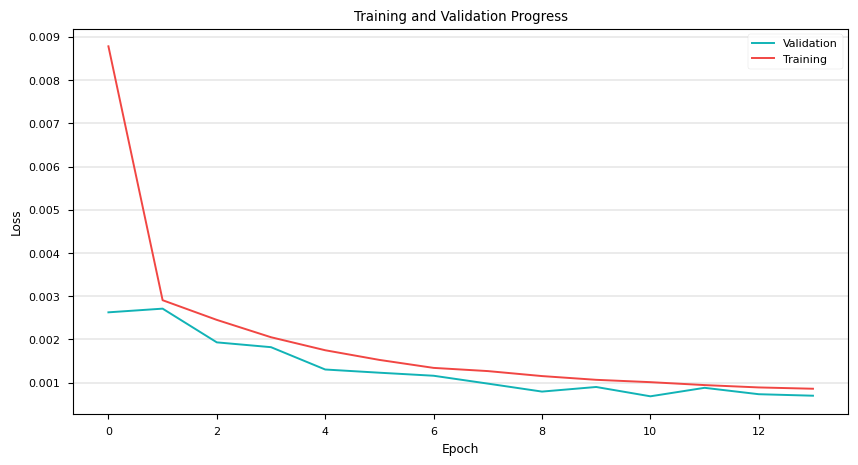

In [105]:
# 构造参数字典
params3 = {
    "task_args":{
        "columns": ['load', 'temp'],
        "target": ['load', 'temp'],
        "features": 'M'
    },
    "train_args": {
        "model_name": BiGED,
        "train_loader": train_loader,
        "valid_loader": valid_loader,
        "n_epochs": 20,
        "learning_rate": 0.001,
        "loss": nn.MSELoss(),
        "patience": 3,
        "device": 'cuda',
        "lradj": 'cosine',
        "model_path": "../outputs/best_models/BiGED",
        "verbose": True,
        "plots": True,
    },
    "model_args": {
        'seq_len': 6,
        'pred_len': 3,
        "label_len": 0,
        'd_model': 128,
        'c_in': 2,
        'c_out': 2,
        'e_layers': 1,
        'd_layers': 1,
    },
}
model = train(**params3)

#### 模型测试

In [106]:
def test(task_args, test_args):
    # 参数配置
    columns = task_args['columns'] # 全部
    target = task_args['target'] 
    features = task_args['features'] 
    model = test_args['model'] 
    x_test = test_args['x_test'] 
    x_test_stamp = test_args['x_test_stamp']
    y_test = test_args['y_test'] 
    y_test_stamp = test_args['y_test_stamp']
    pred_len = test_args['pred_len'] 
    label_len = test_args['label_len']
    device = test_args['device'] # 训练设备，可选'cuda'和'cpu'
    test_path = test_args['test_path'] # 结果保存路径
    
    #检查是否可用GPU
    device = torch.device(device)

    # 评估指标函数
    def metric(pred, true):
        # a/b，其中生成的 NaN 或 Inf 替换为 0
        def divide_no_nan(a, b):
            result = a / b
            result[result != result] = .0
            result[np.inf in result] = .0
            result[np.nan in result] = .0
            return result
        # 残差的标准误差
        def RSE(pred, true):
            return np.sqrt(np.sum((true - pred) ** 2)) / np.sqrt(np.sum((true - true.mean()) ** 2))
        # 相关系数
        def CORR(pred, true):
            u = ((true - true.mean(0)) * (pred - pred.mean(0))).sum(0)
            d = np.sqrt(((true - true.mean(0)) ** 2 * (pred - pred.mean(0)) ** 2).sum(0))
            return (u / d).mean(-1)
        # 平均绝对误差
        def MAE(pred, true):
            return np.mean(np.abs(pred - true))
        # 均方误差
        def MSE(pred, true):
            return np.mean((pred - true) ** 2)
        # 均方根误差
        def RMSE(pred, true):
            return np.sqrt(MSE(pred, true))
        # 平均绝对百分比误差
        def MAPE(pred, true):
            return np.mean(np.abs(divide_no_nan((pred - true), true)))
        # 均方预测误差
        def MSPE(pred, true):
            return np.mean(np.square(divide_no_nan((pred - true), true)))
        # 结果汇总
        mae = MAE(pred, true)
        mse = MSE(pred, true)
        rmse = RMSE(pred, true)
        mape = MAPE(pred, true)
        mspe = MSPE(pred, true)
        print("mae: {:.4f}\nmse: {:.4f}\nrmse: {:.4f}\nmape: {:.4f}\nmspe: {:.4f}".format(mae, mse, rmse, mape, mspe))
        return mae, mse, rmse, mape, mspe
    
    def forecasting_task(columns, target, features):
        """
        features: [M, S, MS]; 
            M:multivariate predict multivariate, 
            S:univariate predict univariate, 
            MS:multivariate predict univariate'
        """
        # 字典索引生成
        col_dict = {}
        for i,j in enumerate(columns):
            col_dict[j] = i

        if features == 'MS':
            target = target[0]
            if target in columns:
                f_dim = col_dict[target]
            else:
                f_dim = 0
        elif features == 'S':
            f_dim = 0
        else:
            f_dim = 0
        return f_dim
    f_dim = forecasting_task(columns, target, features)
    
    # 设置保存模型路径
    if not os.path.exists(test_path):
        os.makedirs(test_path)
    
    # 关闭自动求导功能
    model.eval() # 一定要有
    with torch.no_grad():
        '''测试集设置'''
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        x_test_stamp = x_test_stamp.to(device)
        y_test_stamp = y_test_stamp.to(device)
        # decoder输入
        dec_inp = torch.zeros_like(y_test[:, -pred_len:, :]).float()
        dec_inp = torch.cat([y_test[:, -label_len:, :], dec_inp], dim=1).float().to(device)
        outputs = model(x_test, x_test_stamp, dec_inp, y_test_stamp)
        if features == 'MS':
            dec_inp = torch.cat([x_test[:, -label_len:, f_dim: f_dim+1], dec_inp], dim=1).float().to(device)
            y_pred = model(x_test, x_test_stamp, dec_inp, y_test_stamp)
            # y_pred = outputs[:, :, f_dim: f_dim+1] 
        else:
            dec_inp = torch.cat([x_test[:, -label_len:, f_dim:], dec_inp], dim=1).float().to(device)
            y_pred = model(x_test, x_test_stamp, dec_inp, y_test_stamp)
            # y_pred = outputs[:, :, f_dim:]
        # 评估指标计算
        y_pred = y_pred.cpu().detach().numpy()
        y_true = y_test.cpu().detach().numpy()
        mae, mse, rmse, mape, mspe = metric(y_pred, y_true)
        np.save(test_path + '/metrics.npy', np.array([mae, mse, rmse, mape, mspe]))
        np.save(test_path + '/pred.npy', y_pred)
        np.save(test_path + '/true.npy', y_true)
        
    return 0

In [107]:
# 构造参数字典
params4 = {
    "task_args":{
        "columns": ['load', 'temp'],
        "target": ['load', 'temp'],
        "features": 'M'
    },
    "test_args": {
        "model": model,
        "x_test": X_test,
        "x_test_stamp": X_test_stamp,
        "y_test": y_test,
        "y_test_stamp": y_test_stamp,
        'label_len': 0,
        'pred_len': 3,
        'device': 'cuda',
        'test_path': '../outputs/results/BiGED'
    }
}
res = test(**params4)

mae: 0.0520
mse: 0.0056
rmse: 0.0750
mape: 0.1379
mspe: 0.0499


#### 结果分析

In [108]:
def plot(task_args, plot_args):
    # 参数配置
    columns = task_args['columns'] # 全部
    target = task_args['target'] 
    features = task_args['features'] 
    drawing_point = plot_args['drawing_point'] # 绘图点
    model = plot_args['model'] 
    x_train = plot_args['x_train'] 
    x_train_stamp = plot_args['x_train_stamp']
    x_valid = plot_args['x_valid'] 
    x_valid_stamp = plot_args['x_valid_stamp']
    x_test = plot_args['x_test'] 
    x_test_stamp = plot_args['x_test_stamp']
    y_train = plot_args['y_train'] 
    y_train_stamp = plot_args['y_train_stamp']
    y_valid = plot_args['y_valid'] 
    y_valid_stamp = plot_args['y_valid_stamp']
    y_test = plot_args['y_test'] 
    y_test_stamp = plot_args['y_test_stamp']
    y_true = plot_args['y_true'] 
    seq_len = plot_args['seq_len']
    scaler = plot_args['scaler']
    pred_len = plot_args['pred_len'] 
    label_len = plot_args['label_len']
    device = plot_args['device'] # 训练设备，可选'cuda'和'cpu'
    option = plot_args['option'] # 绘图选项，可选'part','full'
    figure_path = plot_args['figure_path'] # 图片保存路径
    seq_len = seq_len - 1 # 包含当前时间点
    
    #检查是否可用GPU
    device = torch.device(device)
    
    # 任务分类
    def forecasting_task(columns, target, features, drawing_point):
        """
        features: [M, S, MS]; 
            M:multivariate predict multivariate, 
            S:univariate predict univariate, 
            MS:multivariate predict univariate'
        """
        # 字典索引生成
        col_dict = {}
        for i,j in enumerate(columns):
            col_dict[j] = i

        if features == 'MS':
            target = target[0]
            if target in columns:
                f_dim = col_dict[target]
            else:
                f_dim = 0
        elif features == 'S':
            f_dim = 0
        else:
            f_dim = 0

        if drawing_point in columns:
            d_dim = col_dict[drawing_point]
        else:
            d_dim = 0
        return f_dim, d_dim
    f_dim, d_dim = forecasting_task(columns, target, features, drawing_point)
        
    # 数据集长度
    train_size = len(x_train) + seq_len + pred_len
    valid_size = len(x_valid) + seq_len + pred_len
    test_size = len(x_test) + seq_len + pred_len
    
    # 时间序列形状
    timeseries_y = y_true.values[:, d_dim].reshape(-1, 1)
    timeseries_x = y_true.index
    
    # 关闭自动求导功能
    model.eval() # 一定要有
    with torch.no_grad():
        '''训练集设置'''
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        x_train_stamp = x_train_stamp.to(device)
        y_train_stamp = y_train_stamp.to(device)
        # decoder输入
        B, _, _ = x_train.shape
        dec_inp = torch.zeros((B, pred_len, len(target))).float().to(device)
        if features == 'S' or features == 'M':
            dec_inp = torch.cat([x_train[:, -label_len:, f_dim:], dec_inp], dim=1).float()
            y_pred = model(x_train, x_train_stamp, dec_inp, y_train_stamp)
            y_pred = y_pred.cpu().detach().numpy() # 首先将张量移动到CPU，然后从计算图中分离，最后转换为NumPy数组
            y_pred = scaler.inverse_transform(y_pred[:, 0, :].reshape(-1, len(columns))) # 反归一化
            y_pred = y_pred[:, d_dim:d_dim+1]
        else:
            dec_inp = torch.cat([x_train[:, -label_len:, f_dim: f_dim+1], dec_inp], dim=1).float()
            y_pred = model(x_train, x_train_stamp, dec_inp, y_train_stamp)
            y_pred = y_pred.cpu().detach().numpy() # 首先将张量移动到CPU，然后从计算图中分离，最后转换为NumPy数组
            y_pred = scaler.inverse_transform(y_pred[:, 0, :].reshape(-1, 1)) # 反归一化
        train_plot_y = [np.nan]*(seq_len+1) + list(y_pred.reshape(-1, ))+ [np.nan]*(pred_len-1)
        train_plot_x = timeseries_x[: train_size]
        
        '''验证集设置'''
        x_valid = x_valid.to(device)
        y_valid = y_valid.to(device)
        x_valid_stamp = x_valid_stamp.to(device)
        y_valid_stamp = y_valid_stamp.to(device)
        # decoder输入
        B, _, _ = x_valid.shape
        dec_inp = torch.zeros((B, pred_len, len(target))).float().to(device)
        if features == 'S' or features == 'M':
            dec_inp = torch.cat([x_valid[:, -label_len:, f_dim:], dec_inp], dim=1).float()
            y_pred = model(x_valid, x_valid_stamp, dec_inp, y_valid_stamp)
            y_pred = y_pred.cpu().detach().numpy() 
            y_pred = scaler.inverse_transform(y_pred[:, 0, :].reshape(-1, len(columns))) # 反归一化
            y_pred = y_pred[:, d_dim:d_dim+1]
        else:
            dec_inp = torch.cat([x_valid[:, -label_len:, f_dim: f_dim+1], dec_inp], dim=1).float()
            y_pred = model(x_valid, x_valid_stamp, dec_inp, y_valid_stamp)
            y_pred = y_pred.cpu().detach().numpy() 
            y_pred = scaler.inverse_transform(y_pred[:, 0, :].reshape(-1, 1)) # 反归一化
        valid_plot_y = [np.nan]*(seq_len+1) + list(y_pred.reshape(-1, ))+ [np.nan]*(pred_len-1)
        valid_plot_x = timeseries_x[train_size: train_size+valid_size]
        
        '''测试集设置'''
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        x_test_stamp = x_test_stamp.to(device)
        y_test_stamp = y_test_stamp.to(device)
        # decoder输入
        B, _, _ = x_test.shape
        dec_inp = torch.zeros((B, pred_len, len(target))).float().to(device)
        if features == 'S' or features == 'M':
            dec_inp = torch.cat([x_test[:, -label_len:, f_dim:], dec_inp], dim=1).float()
            y_pred = model(x_test, x_test_stamp, dec_inp, y_test_stamp)
            y_pred = y_pred.cpu().detach().numpy() 
            y_pred = scaler.inverse_transform(y_pred[:, 0, :].reshape(-1, len(columns))) # 反归一化
            y_pred = y_pred[:, d_dim:d_dim+1]
        else:
            dec_inp = torch.cat([x_test[:, -label_len:, f_dim: f_dim+1], dec_inp], dim=1).float()
            y_pred = model(x_test, x_test_stamp, dec_inp, y_test_stamp)
            y_pred = y_pred.cpu().detach().numpy() 
            y_pred = scaler.inverse_transform(y_pred[:, 0, :].reshape(-1, 1)) # 反归一化
        test_plot_y = [np.nan]*(seq_len+1) + list(y_pred.reshape(-1, )) + [np.nan]*(pred_len-1)
        test_plot_x = timeseries_x[train_size+valid_size: train_size+valid_size+test_size]
        
    # 设置保存图片路径
    if not os.path.exists(figure_path):
        os.makedirs(figure_path)
    figure_path = figure_path + '/' + target[0] + '_' + option + '.png'

    # 全局静态图
    def static_full_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, 
                               valid_plot_x, valid_plot_y, test_plot_x, test_plot_y, figure_path):
        #绘图，原始图，训练图，验证图，测试图
        fig = plt.figure(1, (10, 5))
        ax = fig.add_subplot(1,1,1)
        plt.style.use('seaborn-v0_8-paper') #绘制背景色
        plt.grid(axis = 'y',linewidth=0.35) #绘制网格
        plt.title('true-predict-curve ') #图标题
        plt.xticks(rotation = 45) #rotation文字旋转方向
        ax.plot(timeseries_x, timeseries_y, linestyle='-',color = '#11b3b6',label = 'true_curve')
        ax.plot(train_plot_x, train_plot_y, linestyle='--',label = 'train_predict_curve')
        ax.plot(valid_plot_x, valid_plot_y, linestyle='--',label = 'valid_predict_curve')
        ax.plot(test_plot_x, test_plot_y, linestyle='--',label = 'test_predict_curve')
        ax.legend(frameon=False) #绘制图例
        plt.xlabel('Time')
        plt.ylabel('Values')
        plt.savefig(figure_path, dpi=600)
        plt.show()

    # 局部静态图
    def static_part_timeseries(timeseries_x, timeseries_y, test_plot_x, test_plot_y, figure_path):
        timeseries_x = timeseries_x[timeseries_x >= test_plot_x[0]]
        timeseries_y = timeseries_y[timeseries_y.shape[0] - len(test_plot_x):,:]
        #绘图，原始图，训练图，验证图，测试图
        fig = plt.figure(1, (10, 5))
        ax = fig.add_subplot(1,1,1)
        plt.style.use('seaborn-v0_8-paper') #绘制背景色
        plt.grid(axis = 'y',linewidth=0.35) #绘制网格
        plt.title('true-predict-curve ') #图标题
        plt.xticks(rotation = 45) #rotation文字旋转方向
        ax.plot(timeseries_x, timeseries_y, linestyle='-',label = 'true_curve')
        ax.plot(test_plot_x, test_plot_y, linestyle='--',label = 'predict_curve')
        ax.legend(frameon=False) #绘制图例
        plt.xlabel('Time')
        plt.ylabel('Values')
        plt.savefig(figure_path, dpi=600)
        plt.show()

    # 全局动态图
    def dynamic_full_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y):
        # 准备画布
        fig = go.Figure()
    
        # 添加实际数据
        fig.add_trace(
            go.Scatter(
                x=timeseries_x,
                y=timeseries_y.reshape(timeseries_y.shape[0], ),
                mode='lines',
                name='true_curve',
                line = dict(color=None, width=2, dash=None)
            ))
    
        # 添加训练预测数据
        fig.add_trace(
            go.Scatter(
                x=train_plot_x,
                y=train_plot_y,
                mode='lines',
                name='train_predict_curve',
                line = dict(color=None, width=2, dash=None)
            ))
    
        # 添加验证预测数据
        fig.add_trace(
            go.Scatter(
                x=valid_plot_x,
                y=valid_plot_y,
                mode='lines',
                name='valid_predict_curve',
                line = dict(color=None, width=2, dash=None)
            ))
    
        # 添加测试预测数据
        fig.add_trace(
            go.Scatter(
                x=test_plot_x,
                y=test_plot_y,
                mode='lines',
                name='test_predict_curve',
                line = dict(color=None, width=2, dash=None)
            ))
    
        #更新图表的排版
        fig.update_layout(
            title='true-predict-curve',
            xaxis=dict(title="date"),
            yaxis=dict(title="values"),
            width=900,  #图表宽度
            height=500,  #图表长度
            template="simple_white"  #图表风格
        )
    
        fig.show()

    # 局部动态图
    def dynamic_part_timeseries(timeseries_x, timeseries_y, test_plot_x, test_plot_y):
        timeseries_x = timeseries_x[timeseries_x >= test_plot_x[0]]
        timeseries_y = timeseries_y[timeseries_y.shape[0] - len(test_plot_x):,:]
        # 准备画布
        fig = go.Figure()
    
        # 添加实际数据
        fig.add_trace(
            go.Scatter(
                x=timeseries_x,
                y=timeseries_y.reshape(timeseries_y.shape[0], ),
                mode='lines',
                name='true_curve',
                line = dict(color=None, width=2, dash=None)
            ))
    
        # 添加测试预测数据
        fig.add_trace(
            go.Scatter(
                x=test_plot_x,
                y=test_plot_y,
                mode='lines',
                name='predict_curve',
                line = dict(color=None, width=2, dash=None)
            ))
    
        #更新图表的排版
        fig.update_layout(
            title='true-predict-curve',
            xaxis=dict(title="date"),
            yaxis=dict(title="values"),
            width=900,  #图表宽度
            height=500,  #图表长度
            template="simple_white"  #图表风格
        )
    
        fig.show()

    # 绘图选项，可选'part','full','dynamic_part','dynamic_full'
    if option == 'part':
        # 局部静态图
        static_part_timeseries(timeseries_x, timeseries_y, test_plot_x, test_plot_y, figure_path)
    elif option == 'full':
        # 全局静态图
        static_full_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, 
                               valid_plot_x, valid_plot_y, test_plot_x, test_plot_y, figure_path)
    elif option == 'dynamic_full':
        # 全局动态图
        dynamic_full_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, 
                               valid_plot_x, valid_plot_y, test_plot_x, test_plot_y)
    elif option == 'dynamic_part':
        # 局部动态图
        dynamic_part_timeseries(timeseries_x, timeseries_y, test_plot_x, test_plot_y)
    else:
        raise ValueError("only support 'part','full','dynamic_part','dynamic_part'")
        
    return 0

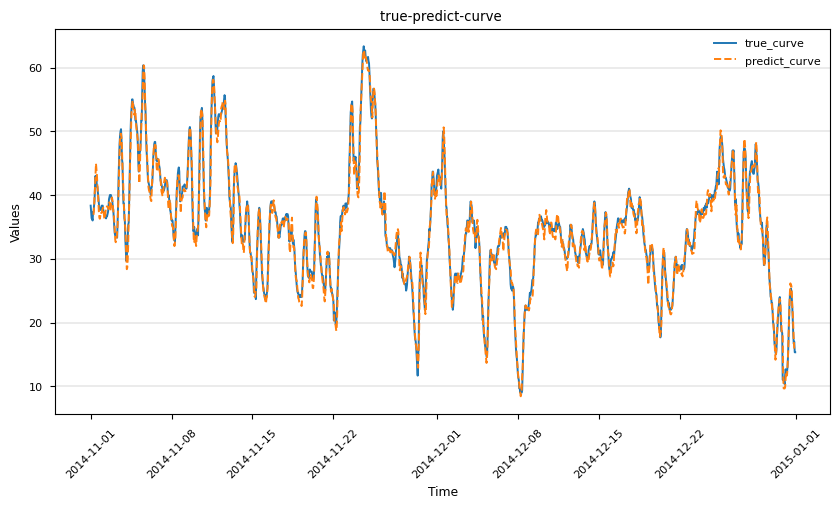

0

In [109]:
# 构造参数字典
params5 = {
    "task_args":{
        "columns": ['load', 'temp'],
        "target": ['load', 'temp'],
        "features": 'M'
    },
    "plot_args": {
        "drawing_point": 'temp',
        "model": model,
        "x_train": X_train,
        "x_valid": X_valid,
        "x_test": X_test,
        "x_train_stamp": X_train_stamp,
        "x_valid_stamp": X_valid_stamp,
        "x_test_stamp": X_test_stamp,
        "y_train": y_train,
        "y_valid": y_valid,
        "y_test": y_test,
        "y_train_stamp": y_train_stamp,
        "y_valid_stamp": y_valid_stamp,
        "y_test_stamp": y_test_stamp,
        "y_true": ts_data,
        "seq_len": 6,
        "pred_len": 3,
        "label_len": 0,
        "scaler": y_scaler,
        "device": 'cuda',
        "option": 'part',
        "figure_path": '../outputs/images/BiGED'
    }
}
plot(**params5)

#### 模型预测

In [110]:
def predict(task_args, predict_args, model_args):
    # 参数配置
    columns = task_args['columns']
    target = task_args['target'] 
    time_col = predict_args['time_col']
    features = task_args['features'] 
    freq = predict_args['freq']
    model_name = predict_args['model_name'] 
    x_true = predict_args['x_true'] 
    scaler_path = predict_args['scaler_path']
    model_path = predict_args['model_path'] 
    device = predict_args['device'] # 预测设备，可选'cuda'和'cpu'
    pred_len = model_args['pred_len'] 
    label_len = model_args['label_len']

    #检查是否可用GPU
    device = torch.device(device)

    # 读取归一化参数
    x_scaler = joblib.load(scaler_path + "/x_scaler.pkl")
    y_scaler = joblib.load(scaler_path + "/y_scaler.pkl")

    # 加载模型
    model = model_name(**model_args)
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)

    # 生成固定长度的时间范围
    x_true = loader(data_path=None, data=x_true, time_col=time_col) # 原始数据
    x_true = x_true[columns]
    timedelta = x_true.index[-1] - x_true.index[-2] # 时间差
    if label_len != 0:
        y_stamp = pd.date_range(start=x_true.index[-label_len], 
                                end=x_true.index[-label_len]+timedelta*(label_len+pred_len-1), 
                                freq=freq)
    else:
        y_stamp = pd.date_range(start=x_true.index[-1]+timedelta*(label_len+1), 
                                end=x_true.index[-1]+timedelta*(label_len+pred_len), 
                                freq=freq) 
    x_stamp = time_features(pd.to_datetime(x_true.index), freq=freq) # x时间戳数据
    x_stamp = x_stamp.transpose(1, 0)
    y_time = y_stamp
    y_stamp = time_features(y_stamp, freq=freq) # y时间戳数据
    y_stamp = y_stamp.transpose(1, 0)
    

    # 转换类型
    x_true[columns] = x_scaler.transform(x_true) # 归一化
    x_true = x_true.values.astype('float32')
    x_true = torch.as_tensor(x_true).unsqueeze(0).float() # 转为张量
    x_stamp = torch.as_tensor(x_stamp).unsqueeze(0).float()
    y_stamp = torch.as_tensor(y_stamp).unsqueeze(0).float()
    
    # 任务分类
    def forecasting_task(columns, target, features):
        """
        features: [M, S, MS]; 
            M:multivariate predict multivariate, 
            S:univariate predict univariate, 
            MS:multivariate predict univariate'
        """
        # 字典索引生成
        col_dict = {}
        for i,j in enumerate(columns):
            col_dict[j] = i

        if features == 'MS':
            target = target[0]
            if target in columns:
                f_dim = col_dict[target]
            else:
                f_dim = 0
        elif features == 'S':
            f_dim = 0
        else:
            f_dim = 0
        return f_dim
    f_dim = forecasting_task(columns, target, features)

    # 关闭自动求导功能
    model.eval() # 一定要有
    with torch.no_grad():
        x_true = x_true.to(device)
        x_stamp = x_stamp.to(device)
        y_stamp = y_stamp.to(device)
        # decoder输入
        B, _, _ = x_true.shape
        dec_inp = torch.zeros((B, pred_len, len(target))).float().to(device)
        if features == 'MS':
            dec_inp = torch.cat([x_true[:, -label_len:, f_dim: f_dim+1], dec_inp], dim=1).float()
            y_pred = model(x_true, x_stamp, dec_inp, y_stamp)
            y_pred = y_pred.cpu().detach().numpy() 
            y_pred = y_scaler.inverse_transform(y_pred[-1, :, :]) # 反归一化
            # y_pred = y_pred[:, f_dim: f_dim+1]
        else:
            dec_inp = torch.cat([x_true[:, -label_len:, f_dim:], dec_inp], dim=1).float()
            y_pred = model(x_true, x_stamp, dec_inp, y_stamp)
            y_pred = y_pred.cpu().detach().numpy() 
            y_pred = y_scaler.inverse_transform(y_pred[-1, :, :]) # 反归一化
            # y_pred = y_pred[:, f_dim:]

    # 输出为dataframe
    y_pred = pd.DataFrame(data=y_pred, index=y_time[-pred_len:], columns=target)
    
    return y_pred

In [111]:
# 构造参数字典
params6 = {
    "task_args":{
        "columns": ['load', 'temp'],
        "target": ['load', 'temp'],
        "features": 'M',
    },
    "predict_args": {
        "time_col": 'time',
        "freq": 'h',
        "model_name": BiGED,
        "model_path": "../outputs/best_models/BiGED/checkpoint.pth",
        "x_true": pd.read_csv(data_path).iloc[:6, :],
        "scaler_path": '../outputs/scalers/BiGED',
        "device": 'cpu'
    },
    "model_args": {
        'seq_len': 6,
        'pred_len': 3,
        "label_len": 0,
        'd_model': 128,
        'c_in': 2,
        'c_out': 2,
        'e_layers': 1,
        'd_layers': 1,
    },
}
y_pred = predict(**params6)

In [112]:
y_pred

,load,temp
2012-01-01 06:00:00,2548.025879,31.438675
2012-01-01 07:00:00,2810.436523,31.851158
2012-01-01 08:00:00,3122.126221,33.447525


## Autoencoder

### 数据准备

In [4]:
# 读取数据
def loader(data_path=None, data=None, time_col=None, datetime=None, freq=None):
    """
    读取数据，并对输入数据时间列进行处理

    参数说明
    ----------
    data_path : {str}
        输入数据地址，如果为空，读取已有数据
    data : {DataFrame} of shape (n_samples, n_features)
        输入数据，如果需读取本地数据，将该值置空，否则传入已有数据
    time_col : {str}
        输入数据的时间列，如果没有时间列，生成时间戳范围，或者生成固定频率的时间戳数据
    datetime : {str} 
        时间列开始时间，如果time_col为空，需填入此项，格式为%Y-%m-%d %H:%M:%S
    freq : {int}
        时间序列频率，单位为秒

    返回值
    -------
    data : {DataFrame} of shape (n_samples, n_features)
        经过时间序列处理后的数据
    """
    # 读取原始数据
    if data_path == None:
        if data.empty is True:
            raise ValueError("data is not exist!")
        else:
            data = data
    else:
        data = pd.read_csv(data_path)
    
    # 时间列处理
    if time_col == None:
        # 筛选输入频率
        re_1 = re.findall('[0-9]', freq)
        re_2 = re.findall('[a-z]', freq)
        # 识别数字频率
        if len(re_1) == 0:
            nums = 1
        else:
            nums = int(''.join(re_1))
        # 识别频率
        fr = re_2[0]
        # 生成时间间隔
        if fr == 's':
            time_index = pd.date_range(start=pd.to_datetime(datetime),
                                       end=pd.to_datetime(datetime) +
                                       timedelta(seconds=(data.shape[0] - 1)*nums),
                                       freq=freq)
        elif fr == 't':
            time_index = pd.date_range(start=pd.to_datetime(datetime),
                                       end=pd.to_datetime(datetime) +
                                       timedelta(minutes=(data.shape[0] - 1)*nums),
                                       freq=freq)
        elif fr == 'h':
            time_index = pd.date_range(start=pd.to_datetime(datetime),
                                       end=pd.to_datetime(datetime) +
                                       timedelta(hours=(data.shape[0] - 1)*nums),
                                       freq=freq)
        elif fr == 'd':
            time_index = pd.date_range(start=pd.to_datetime(datetime),
                                       end=pd.to_datetime(datetime) +
                                       timedelta(days=(data.shape[0] - 1)*nums),
                                       freq=freq)
        full_data = pd.DataFrame(data=data.values,
                                 index=pd.to_datetime(time_index, unit=freq),
                                 columns=data.columns)
    else:
        columns = [i for i in data.columns if i != time_col] # 去除时间列
        full_data = pd.DataFrame(data=data.drop([time_col], axis=1).values,
                                 index=pd.to_datetime(data[time_col].values),
                                 columns=columns)
    return full_data

In [9]:
data_path = "../outputs/datasets/energy.csv"
ts_data = loader(data_path=data_path, data=None, time_col='time')
ts_data

,load,temp
2012-01-01 00:00:00,"2,698.00",32.00
2012-01-01 01:00:00,"2,558.00",32.67
2012-01-01 02:00:00,"2,444.00",30.00
2012-01-01 03:00:00,"2,402.00",31.00
2012-01-01 04:00:00,"2,403.00",32.00
...,...,...
2014-12-31 19:00:00,"4,012.00",18.00
2014-12-31 20:00:00,"3,856.00",16.67
2014-12-31 21:00:00,"3,671.00",17.00
2014-12-31 22:00:00,"3,499.00",15.33


In [2]:
# 包含时间维度的数据集划分
def divider(df, test_date, valid_date, x_feature_list, y_feature_list):
    #归一化
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()
    x_scaler = x_scaler.fit(df.copy()[x_feature_list]) 
    y_scaler = y_scaler.fit(df.copy()[y_feature_list])

    #测试集
    train = df.copy()[df.index < valid_date][x_feature_list]
    train[x_feature_list] = x_scaler.transform(train)
    train = train.values.astype('float32')

    #验证集
    valid = df.copy()[(df.index >= valid_date) & (df.index < test_date)][x_feature_list]
    valid[x_feature_list] = x_scaler.transform(valid)
    valid = valid.values.astype('float32')

    #测试集
    test = df.copy()[test_date:][x_feature_list]
    test[x_feature_list] = x_scaler.transform(test)
    test = test.values.astype('float32')

    #标签
    ytr = df.copy()[df.index < valid_date][y_feature_list]
    ytr[y_feature_list] = y_scaler.transform(ytr)
    ytr = ytr.values.astype('float32')

    yva = df.copy()[(df.index >= valid_date) & (df.index < test_date)][y_feature_list]
    yva[y_feature_list] = y_scaler.transform(yva)
    yva = yva.values.astype('float32')

    yte = df.copy()[test_date:][y_feature_list]
    yte[y_feature_list] = y_scaler.transform(yte)
    yte = yte.values.astype('float32')
    return y_scaler, train, valid, test, ytr, yva, yte

In [61]:
# 构造参数字典
params1 = {
    "df": ts_data,
    "valid_date": "2014-09-01 00:00:00",
    "test_date": "2014-11-01 00:00:00",
    "x_feature_list": ["load", "temp"],
    "y_feature_list": ["load", "temp"],
}

#函数传参
scaler, x_train, x_valid, x_test, y_train, y_valid, y_test = divider(**params1)
print("x_train shape: {0} y_train shape: {1}".format(x_train.shape, y_train.shape))
print("x_valid shape: {0} y_valid shape: {1}".format(x_valid.shape, y_valid.shape))
print("x_test shape: {0} y_test shape: {1}".format(x_test.shape, y_test.shape))

x_train shape: (23376, 2) y_train shape: (23376, 2)
x_valid shape: (1464, 2) y_valid shape: (1464, 2)
x_test shape: (1464, 2) y_test shape: (1464, 2)


### 线性自编码器

In [6]:
# 生成tensor数据
def generator(feature, target, batch_size):
    """
    @参数设置：
    feature：输入向量
    target：输出向量
    """
    #转为张量
    X = torch.as_tensor(feature)
    y = torch.as_tensor(target)
    
    #创建dataloader
    loader = data.DataLoader(data.TensorDataset(X, y), shuffle=True, batch_size=batch_size)
    return X, y, loader

In [7]:
# 构造参数字典
params2 = {
    "batch_size": 32,
}
X_train, y_train, train_loader = generator(x_train, y_train, **params2)
X_valid, y_valid, valid_loader = generator(x_valid, y_valid, **params2)
X_test, y_test, test_loader = generator(x_test, y_test, **params2)
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_train.shape, y_train.shape, len(train_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_valid.shape, y_valid.shape, len(valid_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_test.shape, y_test.shape, len(test_loader)))

X_size: torch.Size([23376, 2]),y_size: torch.Size([23376, 2]),loader_len: 731
X_size: torch.Size([1464, 2]),y_size: torch.Size([1464, 2]),loader_len: 46
X_size: torch.Size([1464, 2]),y_size: torch.Size([1464, 2]),loader_len: 46


In [8]:
def train(train_loader, valid_loader, n_epochs, verbose=True, plots=True):
    # 定义自编码器模型
    class Autoencoder(nn.Module):
        def __init__(self, input_dim, hidden_dim):
            super(Autoencoder, self).__init__()
            self.encoder = nn.Linear(input_dim, hidden_dim)
            self.decoder = nn.Linear(hidden_dim, input_dim)

        def forward(self, x):
            x = self.encoder(x)
            x = torch.relu(x)
            x = self.decoder(x)
            return x
        
    #检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 创建模型和优化器
    model = Autoencoder(input_dim=2, hidden_dim=93).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()

    # 损失函数值
    train_losses, val_losses = [], []

    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_train_loss = 0
        for inputs_batch, targets_batch in train_loader:
            #将数据移至 GPU
            inputs_batch = inputs_batch.to(device)
            targets_batch = targets_batch.to(device)
            # 清空梯度
            optimizer.zero_grad()
            outputs = model(inputs_batch)
            train_loss = loss_fn(outputs, targets_batch)
            # 反向传播计算得到每个参数的梯度值
            train_loss.backward()
            # 通过梯度下降执行一步参数更新
            optimizer.step()
            #每个batch的loss和
            total_train_loss += train_loss.item() # .item()表示只包含一个元素的tensor中提取值
                
        #每个epoch的损失平均
        avg_train_loss = total_train_loss / len(train_loader)
        
        #所有epoch的loss
        train_losses.append(avg_train_loss)
        
        #评估模型
        model.eval()
        #关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            total_val_loss = 0
            for inputs_batch, targets_batch in valid_loader:
                #将数据移至 GPU
                inputs_batch = inputs_batch.to(device)
                targets_batch = targets_batch.to(device)
                val_outputs = model(inputs_batch)
                val_loss = loss_fn(val_outputs, targets_batch)
                #每个batch的loss和
                total_val_loss += val_loss.item()
                
        #每个epoch的损失平均
        avg_val_loss = total_val_loss / len(valid_loader)
        
        #所有epoch的loss
        val_losses.append(avg_val_loss)
        
        #打印训练过程
        if verbose:
            print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

    #绘制损失函数图
    if plots:
        plot_loss(train_losses, val_losses)
    return model

 10%|████████▎                                                                          | 1/10 [00:00<00:06,  1.48it/s]

Epoch [1/10], Training Loss: 0.0143, Validation Loss: 0.0005


 20%|████████████████▌                                                                  | 2/10 [00:01<00:05,  1.55it/s]

Epoch [2/10], Training Loss: 0.0000, Validation Loss: 0.0003


 30%|████████████████████████▉                                                          | 3/10 [00:01<00:04,  1.52it/s]

Epoch [3/10], Training Loss: 0.0000, Validation Loss: 0.0003


 40%|█████████████████████████████████▏                                                 | 4/10 [00:02<00:03,  1.54it/s]

Epoch [4/10], Training Loss: 0.0000, Validation Loss: 0.0002


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:03<00:03,  1.51it/s]

Epoch [5/10], Training Loss: 0.0000, Validation Loss: 0.0002


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:04<00:02,  1.47it/s]

Epoch [6/10], Training Loss: 0.0000, Validation Loss: 0.0002


 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:04<00:02,  1.49it/s]

Epoch [7/10], Training Loss: 0.0000, Validation Loss: 0.0002


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:05<00:01,  1.49it/s]

Epoch [8/10], Training Loss: 0.0000, Validation Loss: 0.0001


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:06<00:00,  1.48it/s]

Epoch [9/10], Training Loss: 0.0000, Validation Loss: 0.0001


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.50it/s]

Epoch [10/10], Training Loss: 0.0000, Validation Loss: 0.0001


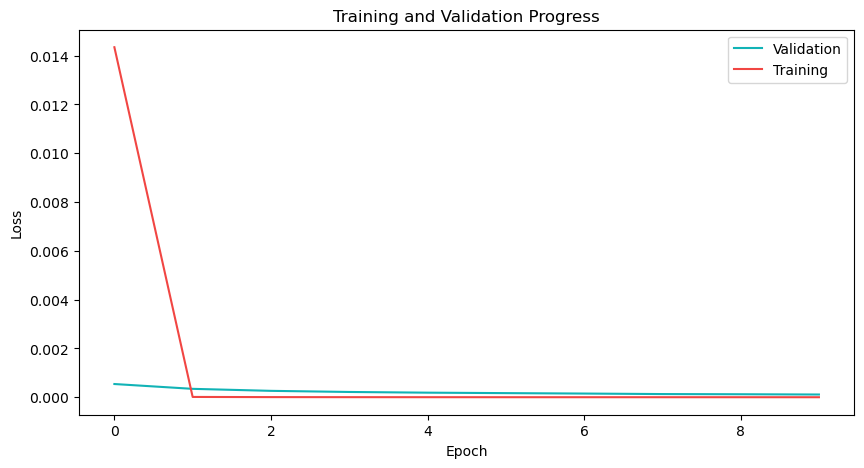

In [15]:
# 构造参数字典
params3 = {
    "train_loader": train_loader,
    "valid_loader": valid_loader,
    "n_epochs": 10,
    "verbose": True,
    "verbose": True,
}
model = train(**params3)

In [16]:
def predict(model, X_train, X_valid, X_test, y_train, y_valid, y_test, y_true, scaler):
    # 数据集长度
    train_size = len(X_train)
    valid_size = len(X_valid)
    test_size = len(X_test)
    
    # 时间序列形状
    timeseries_y = list(y_true.values.astype('float32').reshape(-1, ))
    timeseries_x = list(np.array(y_true.index).reshape(-1, ))
    
    # 检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 关闭自动求导功能
    with torch.no_grad():
        '''测试集设置'''
        X_train = X_train.to(device) # 将数据应用到GPU
        y_train = y_train.to(device)
        y_pred = model(X_train)
        y_pred = y_pred.cpu().detach().numpy() # 首先将张量移动到CPU，然后从计算图中分离，最后转换为NumPy数组
        y_pred = scaler.inverse_transform(y_pred) # 反归一化
        train_plot_y = y_pred[:, 0] # 0表示第一个输出
        train_plot_x = list(timeseries_x[: train_size])
        '''验证集设置'''
        X_valid = X_valid.to(device)
        y_valid = y_valid.to(device)
        y_pred = model(X_valid)
        y_pred = y_pred.cpu().detach().numpy()
        y_pred = scaler.inverse_transform(y_pred)
        valid_plot_y = y_pred[:, 0] # 0表示第一个输出
        valid_plot_x = timeseries_x[train_size: train_size+valid_size]
        '''测试集设置'''
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        y_pred = model(X_test)
        y_pred = y_pred.cpu().detach().numpy()
        y_pred = scaler.inverse_transform(y_pred)
        test_plot_y = y_pred[:, 0] # 0表示第一个输出
        test_plot_x = timeseries_x[train_size+valid_size: train_size+valid_size+test_size]
    return timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y

In [17]:
# 构造参数字典
params4 = {
    "model": model,
    "X_train": X_train,
    "X_valid": X_valid,
    "X_test": X_test,
    "y_train": y_train,
    "y_valid": y_valid,
    "y_test": y_test,
    "y_true": ts_data[['load']],
    "scaler": scaler,
}
timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y = predict(
    **params4)

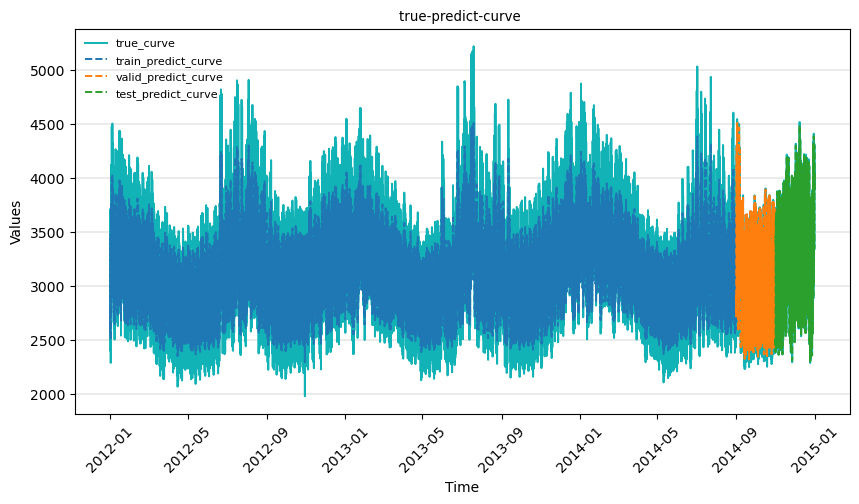

In [18]:
# 全局静态图
params5 = {
    "timeseries_x": timeseries_x,
    "timeseries_y": timeseries_y,
    "train_plot_x": train_plot_x,
    "train_plot_y": train_plot_y,
    "valid_plot_x": valid_plot_x,
    "valid_plot_y": valid_plot_y,
    "test_plot_x": test_plot_x,
    "test_plot_y": test_plot_y,
}
static_full_timeseries(**params5)

### 循环自编码器

基于LSTM的自编码器(LSTM-AE)中，输入和输出的时间步通常应该是一致的。自编码器的目标是通过编码和解码学习数据的表示，而LSTM是一种逐步处理序列数据的模型，需要保持输入和输出序列的长度一致以便进行有效的训练和预测。

In [5]:
# 生成tensor数据
def rnn_create_dataset(feature, target, lookback, step, batch_size):
    """
    @参数设置：
    feature：输入向量
    target：输出向量
    """
    X, y = [], []
    #循环生成数据
    for i in range(lookback, len(feature), step):
        feat = feature[i - lookback:i]
        tar = target[i - lookback:i]
        X.append(feat)
        y.append(tar)
    #转为张量
    X = torch.as_tensor(X)
    y = torch.as_tensor(y)
    #创建dataloader
    loader = data.DataLoader(data.TensorDataset(X, y), shuffle=True, batch_size=batch_size)
    return X, y, loader

In [6]:
# 构造参数字典
params2 = {
    "lookback": 6,
    "step": 1,
    "batch_size": 64,
}
X_train, y_train, train_loader = rnn_create_dataset(x_train, y_train, **params2)
X_valid, y_valid, valid_loader = rnn_create_dataset(x_valid, y_valid, **params2)
X_test, y_test, test_loader = rnn_create_dataset(x_test, y_test, **params2)
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_train.shape, y_train.shape, len(train_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_valid.shape, y_valid.shape, len(valid_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_test.shape, y_test.shape, len(test_loader)))

X_size: torch.Size([23370, 6, 2]),y_size: torch.Size([23370, 6, 2]),loader_len: 366
X_size: torch.Size([1458, 6, 2]),y_size: torch.Size([1458, 6, 2]),loader_len: 23
X_size: torch.Size([1458, 6, 2]),y_size: torch.Size([1458, 6, 2]),loader_len: 23


In [62]:
def train(train_loader, valid_loader, n_epochs, verbose=True, plots=True):
    # 定义编码器模型
    class Encoder(nn.Module):
        def __init__(self, input_dim, hidden_dim):
            super(Encoder, self).__init__()
            # LSTM层将输入序列映射到隐藏状态空间，双向LSTM
            self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=1, batch_first=True, bidirectional = True)

        def forward(self, x):
            # 将输入序列传入LSTM层，返回隐藏状态和细胞状态
            _, (hidden, cell) = self.lstm(x)
            return hidden, cell

    # 定义解码器模型
    class Decoder(nn.Module):
        def __init__(self, hidden_dim, input_dim):
            super(Decoder, self).__init__()
            # LSTM层将解码器输入映射到隐藏状态空间
            self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=1, batch_first=True, bidirectional = True)
            # 线性层将解码器输出映射到指定输出维度，线性层输入维度为hidden_dim*2
            self.out = nn.Linear(hidden_dim*2, input_dim)

        def forward(self, y, hidden, cell):
            # 将输入序列传入LSTM层，返回输出、隐藏状态和细胞状态
            output, (hidden, cell) = self.lstm(y, (hidden, cell))
            # 使用线性层映射到输出维度
            output = self.out(output)
            return output, hidden, cell

    # 定义整个Seq2Seq模型
    class Seq2Seq(nn.Module):
        def __init__(self, input_dim, hidden_dim):
            super(Seq2Seq, self).__init__()
            # 创建编码器和解码器实例
            self.encoder = Encoder(input_dim, hidden_dim)
            self.decoder = Decoder(hidden_dim, input_dim)

        def forward(self, x, y):
            # 编码器处理输入序列
            encoder_hidden, encoder_cell = self.encoder(x)
            # 解码器初始化隐藏状态和细胞状态，让解码器的隐藏层状态等于编码器的隐藏层状态
            decoder_hidden, decoder_cell = encoder_hidden, encoder_cell
            # 解码器处理目标序列
            decoder_output, _, _ = self.decoder(y, decoder_hidden, decoder_cell)
            return decoder_output
        
    #检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 创建模型和优化器
    model = Seq2Seq(input_dim=2, hidden_dim=1).to(device) # hidden_dim如果小于input_dim，可以达到降维效果
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()

    # 损失函数值
    train_losses, val_losses = [], []

    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_train_loss = 0
        for inputs_batch, targets_batch in train_loader:
            #将数据移至 GPU
            inputs_batch = inputs_batch.to(device)
            targets_batch = targets_batch.to(device)
            # 清空梯度
            optimizer.zero_grad()
            outputs = model(inputs_batch, targets_batch)
            train_loss = loss_fn(outputs, targets_batch)
            # 反向传播计算得到每个参数的梯度值
            train_loss.backward()
            # 通过梯度下降执行一步参数更新
            optimizer.step()
            #每个batch的loss和
            total_train_loss += train_loss.item() # .item()表示只包含一个元素的tensor中提取值
                
        #每个epoch的损失平均
        avg_train_loss = total_train_loss / len(train_loader)
        
        #所有epoch的loss
        train_losses.append(avg_train_loss)
        
        #评估模型
        model.eval()
        #关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            total_val_loss = 0
            for inputs_batch, targets_batch in valid_loader:
                #将数据移至 GPU
                inputs_batch = inputs_batch.to(device)
                targets_batch = targets_batch.to(device)
                val_outputs = model(inputs_batch, targets_batch)
                val_loss = loss_fn(val_outputs, targets_batch)
                #每个batch的loss和
                total_val_loss += val_loss.item()
                
        #每个epoch的损失平均
        avg_val_loss = total_val_loss / len(valid_loader)
        
        #所有epoch的loss
        val_losses.append(avg_val_loss)
        
        #打印训练过程
        if verbose:
            print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

    #绘制损失函数图
    if plots:
        plot_loss(train_losses, val_losses)
    return model

 10%|████████▎                                                                          | 1/10 [00:01<00:15,  1.69s/it]

Epoch [1/10], Training Loss: 0.1878, Validation Loss: 0.0478


 20%|████████████████▌                                                                  | 2/10 [00:03<00:13,  1.64s/it]

Epoch [2/10], Training Loss: 0.0284, Validation Loss: 0.0340


 30%|████████████████████████▉                                                          | 3/10 [00:04<00:11,  1.63s/it]

Epoch [3/10], Training Loss: 0.0177, Validation Loss: 0.0274


 40%|█████████████████████████████████▏                                                 | 4/10 [00:06<00:10,  1.67s/it]

Epoch [4/10], Training Loss: 0.0160, Validation Loss: 0.0255


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:08<00:08,  1.70s/it]

Epoch [5/10], Training Loss: 0.0150, Validation Loss: 0.0225


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:10<00:06,  1.74s/it]

Epoch [6/10], Training Loss: 0.0106, Validation Loss: 0.0108


 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:12<00:05,  1.77s/it]

Epoch [7/10], Training Loss: 0.0042, Validation Loss: 0.0058


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:13<00:03,  1.77s/it]

Epoch [8/10], Training Loss: 0.0019, Validation Loss: 0.0031


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:15<00:01,  1.80s/it]

Epoch [9/10], Training Loss: 0.0009, Validation Loss: 0.0021


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.75s/it]

Epoch [10/10], Training Loss: 0.0005, Validation Loss: 0.0017


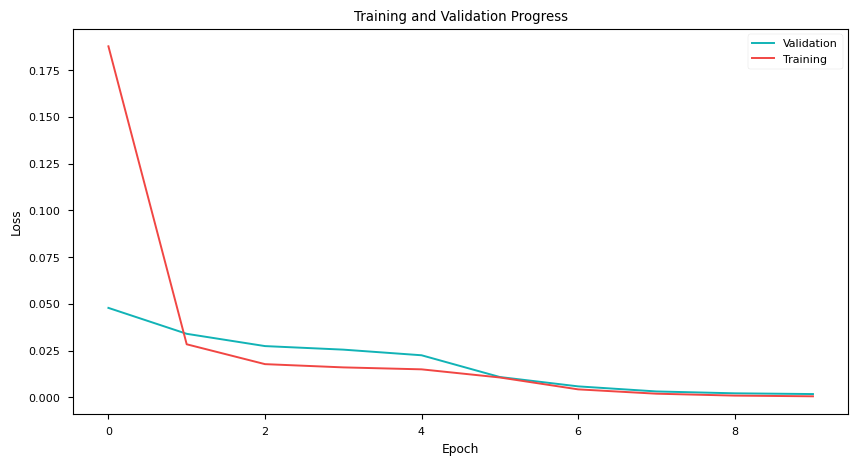

In [63]:
# 构造参数字典
params3 = {
    "train_loader": train_loader,
    "valid_loader": valid_loader,
    "n_epochs": 10,
    "verbose": True,
    "verbose": True,
}
model = train(**params3)

In [14]:
def predict(model, X_train, X_valid, X_test, y_train, y_valid, y_test, y_true, lookback, scaler):
    # 数据集长度
    train_size = len(X_train) + lookback
    valid_size = len(X_valid) + lookback
    test_size = len(X_test) + lookback
    
    # 时间序列形状
    timeseries_y = y_true.values
    timeseries_x = y_true.index
    
    # 检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 关闭自动求导功能
    with torch.no_grad():
        '''测试集设置'''
        X_train = X_train.to(device) # 将数据应用到GPU
        y_train = y_train.to(device)
        y_pred = model(X_train, y_train)
        y_pred = y_pred[:, -1, :]
        y_pred = y_pred.cpu().detach().numpy() # 首先将张量移动到CPU，然后从计算图中分离，最后转换为NumPy数组
        y_pred = scaler.inverse_transform(y_pred)[:, 0] # 反归一化
        train_plot_y = [np.nan]*(lookback) + list(y_pred.reshape(-1, ))
        train_plot_x = timeseries_x[: train_size]
        '''验证集设置'''
        X_valid = X_valid.to(device)
        y_valid = y_valid.to(device)
        y_pred = model(X_valid, y_valid)
        y_pred = y_pred[:, -1, :]
        y_pred = y_pred.cpu().detach().numpy()
        y_pred = scaler.inverse_transform(y_pred)[:, 0]
        valid_plot_y = [np.nan]*(lookback) + list(y_pred.reshape(-1, ))
        valid_plot_x = timeseries_x[train_size: train_size+valid_size]
        '''测试集设置'''
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        y_pred = model(X_test, y_test)
        y_pred = y_pred[:, -1, :]
        y_pred = y_pred.cpu().detach().numpy()
        y_pred = scaler.inverse_transform(y_pred)[:, 0]
        test_plot_y = [np.nan]*(lookback) + list(y_pred.reshape(-1, ))
        test_plot_x = timeseries_x[train_size+valid_size: train_size+valid_size+test_size]
    return timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y

In [65]:
# 构造参数字典
params4 = {
    "model": model,
    "X_train": X_train,
    "X_valid": X_valid,
    "X_test": X_test,
    "y_train": y_train,
    "y_valid": y_valid,
    "y_test": y_test,
    "y_true": ts_data[['load']],
    "lookback": 6,
    "scaler": scaler,
}
timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y = predict(
    **params4)

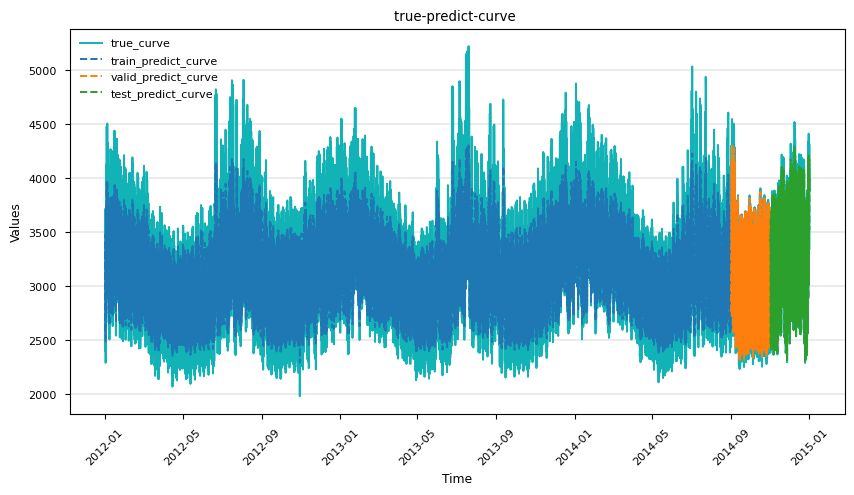

In [66]:
# 全局静态图
params5 = {
    "timeseries_x": timeseries_x,
    "timeseries_y": timeseries_y,
    "train_plot_x": train_plot_x,
    "train_plot_y": train_plot_y,
    "valid_plot_x": valid_plot_x,
    "valid_plot_y": valid_plot_y,
    "test_plot_x": test_plot_x,
    "test_plot_y": test_plot_y,
}
static_full_timeseries(**params5)

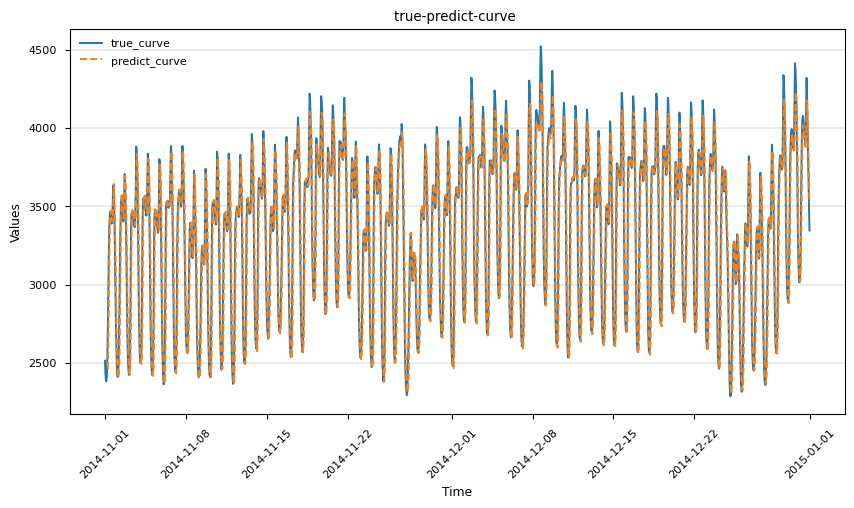

In [67]:
# 局部静态图
params5 = {
    "timeseries_x": timeseries_x,
    "timeseries_y": timeseries_y,
    "test_plot_x": test_plot_x,
    "test_plot_y": test_plot_y,
}
static_part_timeseries(**params5)

### 卷积自编码器

In [124]:
# 构造参数字典
params1 = {
    "df": ts_data,
    "valid_date": "2014-09-01 00:00:00",
    "test_date": "2014-11-01 00:00:00",
    "x_feature_list": ["load", "temp"],
    "y_feature_list": ["load", "temp"],
}

#函数传参
scaler, x_train, x_valid, x_test, y_train, y_valid, y_test = divide_dataset(**params1)
print("x_train shape: {0} y_train shape: {1}".format(x_train.shape, y_train.shape))
print("x_valid shape: {0} y_valid shape: {1}".format(x_valid.shape, y_valid.shape))
print("x_test shape: {0} y_test shape: {1}".format(x_test.shape, y_test.shape))

x_train shape: (23376, 2) y_train shape: (23376, 2)
x_valid shape: (1464, 2) y_valid shape: (1464, 2)
x_test shape: (1464, 2) y_test shape: (1464, 2)


In [125]:
# 生成tensor数据
def cnn_create_dataset(feature, target, lookback, step, batch_size):
    """
    @参数设置：
    feature：输入向量
    target：输出向量
    """
    X, y = [], []
    #循环生成数据
    for i in range(lookback, len(feature), step):
        feat = feature[i - lookback:i]
        tar = target[i - lookback:i]
        X.append(feat)
        y.append(tar)
    #转为张量
    X = torch.as_tensor(X)
    y = torch.as_tensor(y)
    X = X.permute(0,2,1)
    y = y.permute(0,2,1)
    #创建dataloader
    loader = data.DataLoader(data.TensorDataset(X, y), shuffle=True, batch_size=batch_size)
    return X, y, loader

In [126]:
# 构造参数字典
params2 = {
    "lookback": 64,
    "step": 1,
    "batch_size": 32,
}
X_train, y_train, train_loader = cnn_create_dataset(x_train, y_train, **params2)
X_valid, y_valid, valid_loader = cnn_create_dataset(x_valid, y_valid, **params2)
X_test, y_test, test_loader = cnn_create_dataset(x_test, y_test, **params2)
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_train.shape, y_train.shape, len(train_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_valid.shape, y_valid.shape, len(valid_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_test.shape, y_test.shape, len(test_loader)))

X_size: torch.Size([23312, 2, 64]),y_size: torch.Size([23312, 2, 64]),loader_len: 729
X_size: torch.Size([1400, 2, 64]),y_size: torch.Size([1400, 2, 64]),loader_len: 44
X_size: torch.Size([1400, 2, 64]),y_size: torch.Size([1400, 2, 64]),loader_len: 44


In [135]:
def train(train_loader, valid_loader, n_epochs, input_dim, seq_length, hidden_dim, verbose=True, plots=True):
    # 定义一维卷积编码器
    class Encoder(nn.Module):
        def __init__(self, input_dim, seq_length, hidden_dim):
            super(Encoder, self).__init__()
            self.conv1 = nn.Conv1d(input_dim, 16, kernel_size=3, stride=2, padding=1) # stride=2使序列长度减半
            self.conv2 = nn.Conv1d(16, 32, kernel_size=3, stride=2, padding=1)
            self.conv3 = nn.Conv1d(32, 64, kernel_size=3, stride=2, padding=1) # 形状为（batch_size, 64, 8）
            # 将多维的输入数据展平为一维
            self.flatten = nn.Flatten()
            self.fc = nn.Linear(64 * (seq_length // (2*2*2)), hidden_dim) # 序列长度大于8

        def forward(self, x):
            x = nn.functional.relu(self.conv1(x))
            x = nn.functional.relu(self.conv2(x))
            x = nn.functional.relu(self.conv3(x))
            x = self.flatten(x)
            x = self.fc(x)
            return x

    # 定义一维卷积解码器
    class Decoder(nn.Module):
        def __init__(self, input_dim, hidden_dim, seq_length):
            super(Decoder, self).__init__()
            self.fc = nn.Linear(hidden_dim, 64 * (seq_length // (2*2*2)))
            # 反卷积
            self.deconv1 = nn.ConvTranspose1d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1,
                                              groups=2)  # groups 参数指定了输入通道分组的数量，等于通道数
            self.deconv2 = nn.ConvTranspose1d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1, 
                                              groups=2)  # 添加 groups 参数
            self.deconv3 = nn.ConvTranspose1d(16, input_dim, kernel_size=3, stride=2, padding=1, output_padding=1) 

        def forward(self, x):
            x = self.fc(x)
            x = x.view(x.size(0), 64, -1) # 形状还原
            x = nn.functional.relu(self.deconv1(x))
            x = nn.functional.relu(self.deconv2(x))
            x = self.deconv3(x)
            return x

    # 定义一维卷积自编码器
    class Seq2Seq(nn.Module):
        def __init__(self, input_dim, seq_length, hidden_dim):
            super(Seq2Seq, self).__init__()
            self.encoder = Encoder(input_dim, seq_length, hidden_dim)
            self.decoder = Decoder(input_dim, hidden_dim, seq_length)

        def forward(self, x):
            x = self.encoder(x) 
            x = self.decoder(x)
            return x
        
    #检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 创建模型和优化器
    model = Seq2Seq(input_dim=input_dim, seq_length=seq_length, hidden_dim=hidden_dim).to(device) # hidden_dim如果小于input_dim，可以达到降维效果
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()

    # 损失函数值
    train_losses, val_losses = [], []

    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_train_loss = 0
        for inputs_batch, targets_batch in train_loader:
            #将数据移至 GPU
            inputs_batch = inputs_batch.to(device)
            targets_batch = targets_batch.to(device)
            # 清空梯度
            optimizer.zero_grad()
            outputs = model(inputs_batch)
            train_loss = loss_fn(outputs, targets_batch)
            # 反向传播计算得到每个参数的梯度值
            train_loss.backward()
            # 通过梯度下降执行一步参数更新
            optimizer.step()
            #每个batch的loss和
            total_train_loss += train_loss.item() # .item()表示只包含一个元素的tensor中提取值
                
        #每个epoch的损失平均
        avg_train_loss = total_train_loss / len(train_loader)
        
        #所有epoch的loss
        train_losses.append(avg_train_loss)
        
        #评估模型
        model.eval()
        #关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            total_val_loss = 0
            for inputs_batch, targets_batch in valid_loader:
                #将数据移至 GPU
                inputs_batch = inputs_batch.to(device)
                targets_batch = targets_batch.to(device)
                val_outputs = model(inputs_batch)
                val_loss = loss_fn(val_outputs, targets_batch)
                #每个batch的loss和
                total_val_loss += val_loss.item()
                
        #每个epoch的损失平均
        avg_val_loss = total_val_loss / len(valid_loader)
        
        #所有epoch的loss
        val_losses.append(avg_val_loss)
        
        #打印训练过程
        if verbose:
            print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

    #绘制损失函数图
    if plots:
        plot_loss(train_losses, val_losses)
    return model

 10%|████████▎                                                                          | 1/10 [00:05<00:48,  5.41s/it]

Epoch [1/10], Training Loss: 0.0216, Validation Loss: 0.0047


 20%|████████████████▌                                                                  | 2/10 [00:11<00:47,  5.96s/it]

Epoch [2/10], Training Loss: 0.0009, Validation Loss: 0.0027


 30%|████████████████████████▉                                                          | 3/10 [00:17<00:41,  5.91s/it]

Epoch [3/10], Training Loss: 0.0006, Validation Loss: 0.0020


 40%|█████████████████████████████████▏                                                 | 4/10 [00:23<00:35,  5.92s/it]

Epoch [4/10], Training Loss: 0.0005, Validation Loss: 0.0017


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:29<00:29,  5.92s/it]

Epoch [5/10], Training Loss: 0.0004, Validation Loss: 0.0016


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:35<00:24,  6.03s/it]

Epoch [6/10], Training Loss: 0.0004, Validation Loss: 0.0015


 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:41<00:17,  5.96s/it]

Epoch [7/10], Training Loss: 0.0003, Validation Loss: 0.0015


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:47<00:12,  6.07s/it]

Epoch [8/10], Training Loss: 0.0003, Validation Loss: 0.0014


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:54<00:06,  6.22s/it]

Epoch [9/10], Training Loss: 0.0003, Validation Loss: 0.0014


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:00<00:00,  6.03s/it]

Epoch [10/10], Training Loss: 0.0002, Validation Loss: 0.0014


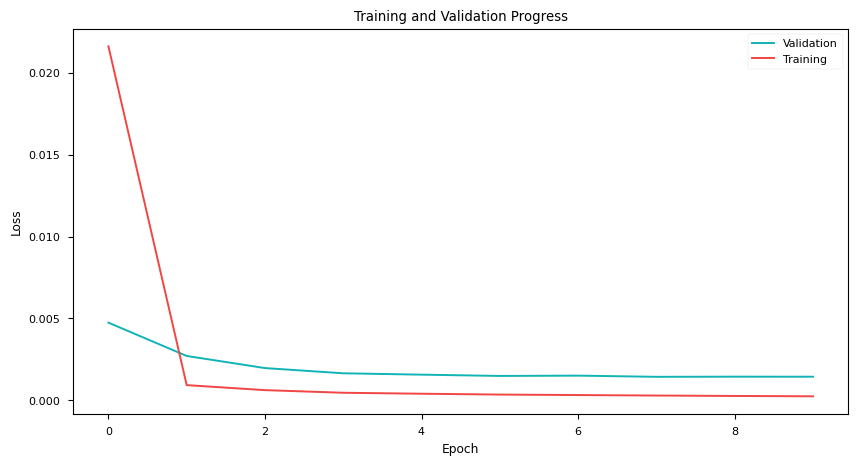

In [136]:
# 构造参数字典
params3 = {
    "train_loader": train_loader,
    "valid_loader": valid_loader,
    "n_epochs": 10,
    "input_dim": 2,
    "seq_length": 64,
    "hidden_dim": 32,
    "verbose": True,
    "verbose": True,
}
model = train(**params3)

In [149]:
def predict(model, X_train, X_valid, X_test, y_train, y_valid, y_test, y_true, lookback, scaler):
    # 数据集长度
    train_size = len(X_train) + lookback
    valid_size = len(X_valid) + lookback
    test_size = len(X_test) + lookback
    
    # 时间序列形状
    timeseries_y = y_true.values
    timeseries_x = y_true.index
    
    # 检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 关闭自动求导功能
    with torch.no_grad():
        '''测试集设置'''
        X_train = X_train.to(device) # 将数据应用到GPU
        y_train = y_train.to(device)
        y_pred = model(X_train)
        y_pred = y_pred[:, :, -1] # 取最后一个输出
        y_pred = y_pred.cpu().detach().numpy() # 首先将张量移动到CPU，然后从计算图中分离，最后转换为NumPy数组
        y_pred = scaler.inverse_transform(y_pred)[:, 0] # 反归一化，并取第一个特征
        train_plot_y = [np.nan]*(lookback) + list(y_pred.reshape(-1, ))
        train_plot_x = timeseries_x[: train_size]
        '''验证集设置'''
        X_valid = X_valid.to(device)
        y_valid = y_valid.to(device)
        y_pred = model(X_valid)
        y_pred = y_pred[:, :, -1]
        y_pred = y_pred.cpu().detach().numpy()
        y_pred = scaler.inverse_transform(y_pred)[:, 0]
        valid_plot_y = [np.nan]*(lookback) + list(y_pred.reshape(-1, ))
        valid_plot_x = timeseries_x[train_size: train_size+valid_size]
        '''测试集设置'''
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        y_pred = model(X_test)
        y_pred = y_pred[:, :, -1]
        y_pred = y_pred.cpu().detach().numpy()
        y_pred = scaler.inverse_transform(y_pred)[:, 0]
        test_plot_y = [np.nan]*(lookback) + list(y_pred.reshape(-1, ))
        test_plot_x = timeseries_x[train_size+valid_size: train_size+valid_size+test_size]
    return timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y

In [150]:
# 构造参数字典
params4 = {
    "model": model,
    "X_train": X_train,
    "X_valid": X_valid,
    "X_test": X_test,
    "y_train": y_train,
    "y_valid": y_valid,
    "y_test": y_test,
    "y_true": ts_data[['load']],
    "lookback": 64,
    "scaler": scaler,
}
timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y = predict(
    **params4)

torch.Size([23312, 2, 64])


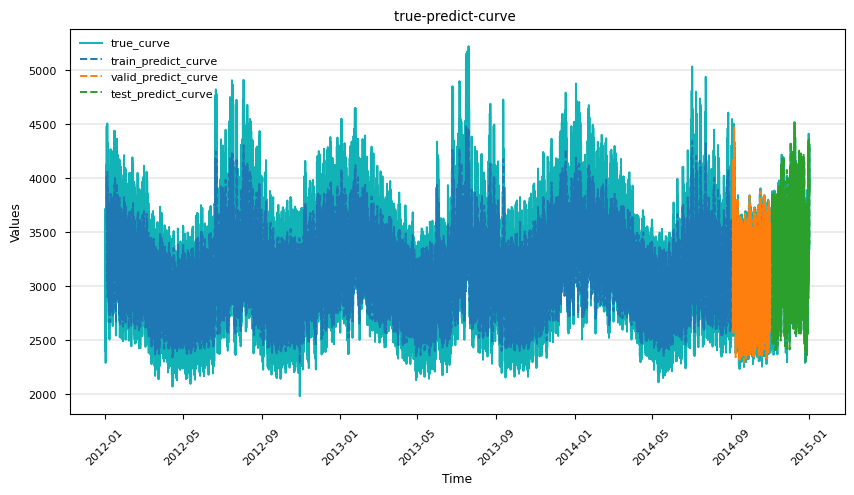

In [151]:
# 全局静态图
params5 = {
    "timeseries_x": timeseries_x,
    "timeseries_y": timeseries_y,
    "train_plot_x": train_plot_x,
    "train_plot_y": train_plot_y,
    "valid_plot_x": valid_plot_x,
    "valid_plot_y": valid_plot_y,
    "test_plot_x": test_plot_x,
    "test_plot_y": test_plot_y,
}
static_full_timeseries(**params5)

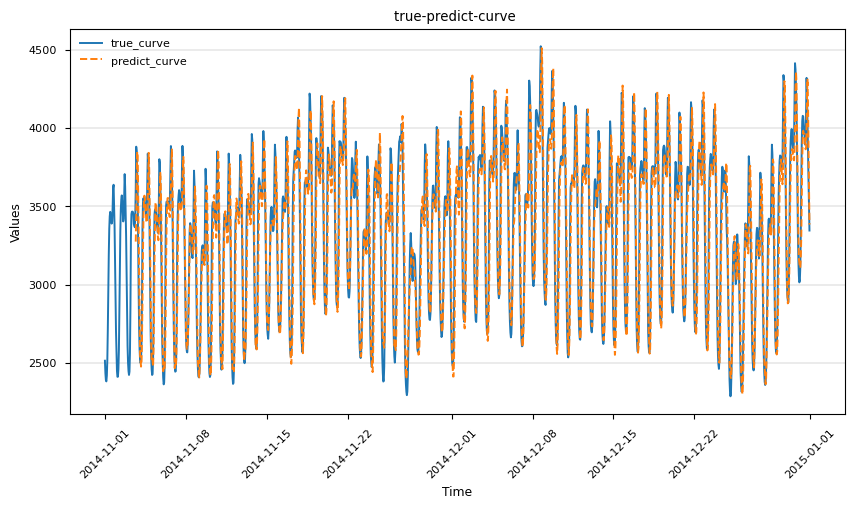

In [152]:
# 局部静态图
params5 = {
    "timeseries_x": timeseries_x,
    "timeseries_y": timeseries_y,
    "test_plot_x": test_plot_x,
    "test_plot_y": test_plot_y,
}
static_part_timeseries(**params5)

### 稀疏自编码器

基于时间序列的稀疏自编码器（Sparse Autoencoder）可以用于学习数据中的时间依赖性和发现潜在的时间序列模式。

稀疏自编码器通常用于学习诸如分类等任务的特征。稀疏自编码器就是普通自编码器的隐藏层加一个L1正则项，也就是一个训练惩罚项，这样我们训练出的编码器表征的特征更加的稀疏，从而能得到少且有用的特征项。

限制自编码器重构的一种方式是对其损失施加约束 -->稀疏性约束。可以使用神经元的输出作为神经元的激活度，即对于隐含层的第 j 个神经元，其激活度为：
$$a_{j}^{(2)} = f(w_{j1}^{(1)}x1 + w_{j2}^{(1)}x2 + ... +w_{j6}^{(1)}x6 + b_{j}^{(1)})$$

则对于 m 个样本，其平均激活度为：
$$\hat{\rho}_{j} = \frac{1}{m}\sum_{i=1}^{m}\left [ a_{j}^{(2)} (x^{(i)})\right ]$$

ρ是一个 常数，表示的是稀疏性参数，通常可以取一个接近于 0 的常数（ρ=0.05）。我们希望平均激活度能够尽可能接近稀疏性常数，通常可以取相对熵来衡量平均激活度与稀疏性参数之间的差异程度。

In [156]:
# 生成tensor数据
def create_dataset(feature, target, batch_size):
    """
    @参数设置：
    feature：输入向量
    target：输出向量
    """
    #转为张量
    X = torch.as_tensor(feature)
    y = torch.as_tensor(target)
    
    #创建dataloader
    loader = data.DataLoader(data.TensorDataset(X, y), shuffle=True, batch_size=batch_size)
    return X, y, loader

In [157]:
# 构造参数字典
params2 = {
    "batch_size": 32,
}
X_train, y_train, train_loader = create_dataset(x_train, y_train, **params2)
X_valid, y_valid, valid_loader = create_dataset(x_valid, y_valid, **params2)
X_test, y_test, test_loader = create_dataset(x_test, y_test, **params2)
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_train.shape, y_train.shape, len(train_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_valid.shape, y_valid.shape, len(valid_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_test.shape, y_test.shape, len(test_loader)))

X_size: torch.Size([23376, 2]),y_size: torch.Size([23376, 2]),loader_len: 731
X_size: torch.Size([1464, 2]),y_size: torch.Size([1464, 2]),loader_len: 46
X_size: torch.Size([1464, 2]),y_size: torch.Size([1464, 2]),loader_len: 46


In [176]:
def train(train_loader, valid_loader, n_epochs, verbose=True, plots=True):
    # 定义稀疏自编码器模型，通过引入稀疏性约束，学习对于输入数据而言激活较少的神经元，从而使得编码的表示更加稀疏。
    class SparseAutoencoder(nn.Module):
        def __init__(self, input_dim, hidden_dim, sparsity_parameter=0.01, rho=0.05):
            super(SparseAutoencoder, self).__init__()

            self.encoder = nn.Linear(input_dim, hidden_dim)
            self.decoder = nn.Linear(hidden_dim, input_dim)
            # 稀疏参数，表示期望的平均激活水平，激活水平通常是指神经元的输出值，该值通过激活函数处理后得到
            self.sparsity_parameter = sparsity_parameter 
            # 表示期望的活跃度水平
            self.rho = rho 

        def forward(self, x):
            # Encoder
            encoded = torch.sigmoid(self.encoder(x))
            # Decoder
            decoded = torch.sigmoid(self.decoder(encoded))
            return decoded, encoded

        def sparse_loss(self, encoded):
            # 计算稀疏性损失
            rho_hat = torch.mean(encoded, dim=0)  # 平均激活值
            # 比较模型学到的平均激活水平rho_hat与期望的激活水平self.sparsity_parameter。KL散度的值越小，表示两个分布越相似。
            sparsity_loss = torch.sum(self.sparsity_parameter * torch.log(self.sparsity_parameter / rho_hat) +
                                      (1 - self.sparsity_parameter) * torch.log((1 - self.sparsity_parameter) / (1 - rho_hat))) # KL散度
            return sparsity_loss

    #检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 创建模型和优化器
    model = SparseAutoencoder(input_dim=2, hidden_dim=93).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()

    # 损失函数值
    train_losses, val_losses = [], []

    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_train_loss = 0
        for inputs_batch, targets_batch in train_loader:
            #将数据移至 GPU
            inputs_batch = inputs_batch.to(device)
            targets_batch = targets_batch.to(device)
            # 清空梯度
            optimizer.zero_grad()
            outputs, encoded = model(inputs_batch)
            # 计算重构损失和稀疏性损失
            reconstruction_loss = loss_fn(outputs, targets_batch)
            sparsity_loss = model.sparse_loss(encoded)
            # 总损失
            train_loss = reconstruction_loss + sparsity_loss
            # 反向传播计算得到每个参数的梯度值
            train_loss.backward()
            # 通过梯度下降执行一步参数更新
            optimizer.step()
            #每个batch的loss和
            total_train_loss += train_loss.item() # .item()表示只包含一个元素的tensor中提取值
                
        #每个epoch的损失平均
        avg_train_loss = total_train_loss / len(train_loader)
        
        #所有epoch的loss
        train_losses.append(avg_train_loss)
        
        #评估模型
        model.eval()
        #关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            total_val_loss = 0
            for inputs_batch, targets_batch in valid_loader:
                #将数据移至 GPU
                inputs_batch = inputs_batch.to(device)
                targets_batch = targets_batch.to(device)
                val_outputs, val_encoded = model(inputs_batch)
                # 计算重构损失和稀疏性损失
                reconstruction_loss = loss_fn(val_outputs, targets_batch)
                sparsity_loss = model.sparse_loss(val_encoded)
                # 总损失
                val_loss = reconstruction_loss + sparsity_loss
                #每个batch的loss和
                total_val_loss += val_loss.item()
                
        #每个epoch的损失平均
        avg_val_loss = total_val_loss / len(valid_loader)
        
        #所有epoch的loss
        val_losses.append(avg_val_loss)
        
        #打印训练过程
        if verbose:
            print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

    #绘制损失函数图
    if plots:
        plot_loss(train_losses, val_losses)
    return model

  1%|▊                                                                                 | 1/100 [00:00<01:22,  1.20it/s]

Epoch [1/100], Training Loss: 37.8186, Validation Loss: 23.6024


  2%|█▋                                                                                | 2/100 [00:01<01:23,  1.18it/s]

Epoch [2/100], Training Loss: 14.4459, Validation Loss: 10.8586


  3%|██▍                                                                               | 3/100 [00:02<01:22,  1.18it/s]

Epoch [3/100], Training Loss: 6.4177, Validation Loss: 5.6880


  4%|███▎                                                                              | 4/100 [00:03<01:22,  1.17it/s]

Epoch [4/100], Training Loss: 3.1059, Validation Loss: 3.1918


  5%|████                                                                              | 5/100 [00:04<01:21,  1.16it/s]

Epoch [5/100], Training Loss: 1.5458, Validation Loss: 1.8534


  6%|████▉                                                                             | 6/100 [00:05<01:21,  1.15it/s]

Epoch [6/100], Training Loss: 0.7601, Validation Loss: 1.0946


  7%|█████▋                                                                            | 7/100 [00:06<01:20,  1.16it/s]

Epoch [7/100], Training Loss: 0.3597, Validation Loss: 0.6585


  8%|██████▌                                                                           | 8/100 [00:06<01:19,  1.16it/s]

Epoch [8/100], Training Loss: 0.1617, Validation Loss: 0.4059


  9%|███████▍                                                                          | 9/100 [00:07<01:18,  1.16it/s]

Epoch [9/100], Training Loss: 0.0716, Validation Loss: 0.2723


 10%|████████                                                                         | 10/100 [00:08<01:17,  1.16it/s]

Epoch [10/100], Training Loss: 0.0348, Validation Loss: 0.1964


 11%|████████▉                                                                        | 11/100 [00:09<01:16,  1.16it/s]

Epoch [11/100], Training Loss: 0.0221, Validation Loss: 0.1658


 12%|█████████▋                                                                       | 12/100 [00:10<01:16,  1.16it/s]

Epoch [12/100], Training Loss: 0.0186, Validation Loss: 0.1449


 13%|██████████▌                                                                      | 13/100 [00:11<01:14,  1.17it/s]

Epoch [13/100], Training Loss: 0.0172, Validation Loss: 0.1435


 14%|███████████▎                                                                     | 14/100 [00:12<01:13,  1.17it/s]

Epoch [14/100], Training Loss: 0.0162, Validation Loss: 0.1386


 15%|████████████▏                                                                    | 15/100 [00:12<01:12,  1.17it/s]

Epoch [15/100], Training Loss: 0.0142, Validation Loss: 0.1375


 16%|████████████▉                                                                    | 16/100 [00:13<01:12,  1.16it/s]

Epoch [16/100], Training Loss: 0.0125, Validation Loss: 0.1400


 17%|█████████████▊                                                                   | 17/100 [00:14<01:11,  1.15it/s]

Epoch [17/100], Training Loss: 0.0105, Validation Loss: 0.1299


 18%|██████████████▌                                                                  | 18/100 [00:15<01:11,  1.15it/s]

Epoch [18/100], Training Loss: 0.0091, Validation Loss: 0.1240


 19%|███████████████▍                                                                 | 19/100 [00:16<01:11,  1.13it/s]

Epoch [19/100], Training Loss: 0.0082, Validation Loss: 0.1196


 20%|████████████████▏                                                                | 20/100 [00:17<01:10,  1.13it/s]

Epoch [20/100], Training Loss: 0.0078, Validation Loss: 0.1191


 21%|█████████████████                                                                | 21/100 [00:18<01:09,  1.14it/s]

Epoch [21/100], Training Loss: 0.0075, Validation Loss: 0.1239


 22%|█████████████████▊                                                               | 22/100 [00:19<01:08,  1.15it/s]

Epoch [22/100], Training Loss: 0.0072, Validation Loss: 0.1130


 23%|██████████████████▋                                                              | 23/100 [00:19<01:08,  1.12it/s]

Epoch [23/100], Training Loss: 0.0068, Validation Loss: 0.1084


 24%|███████████████████▍                                                             | 24/100 [00:20<01:07,  1.12it/s]

Epoch [24/100], Training Loss: 0.0069, Validation Loss: 0.1115


 25%|████████████████████▎                                                            | 25/100 [00:21<01:06,  1.12it/s]

Epoch [25/100], Training Loss: 0.0066, Validation Loss: 0.1029


 26%|█████████████████████                                                            | 26/100 [00:22<01:05,  1.12it/s]

Epoch [26/100], Training Loss: 0.0064, Validation Loss: 0.0997


 27%|█████████████████████▊                                                           | 27/100 [00:23<01:04,  1.12it/s]

Epoch [27/100], Training Loss: 0.0065, Validation Loss: 0.0983


 28%|██████████████████████▋                                                          | 28/100 [00:24<01:03,  1.13it/s]

Epoch [28/100], Training Loss: 0.0063, Validation Loss: 0.0935


 29%|███████████████████████▍                                                         | 29/100 [00:25<01:02,  1.14it/s]

Epoch [29/100], Training Loss: 0.0062, Validation Loss: 0.0963


 30%|████████████████████████▎                                                        | 30/100 [00:26<01:00,  1.16it/s]

Epoch [30/100], Training Loss: 0.0058, Validation Loss: 0.0909


 31%|█████████████████████████                                                        | 31/100 [00:26<00:59,  1.17it/s]

Epoch [31/100], Training Loss: 0.0058, Validation Loss: 0.0864


 32%|█████████████████████████▉                                                       | 32/100 [00:27<00:58,  1.15it/s]

Epoch [32/100], Training Loss: 0.0058, Validation Loss: 0.0837


 33%|██████████████████████████▋                                                      | 33/100 [00:28<00:58,  1.14it/s]

Epoch [33/100], Training Loss: 0.0052, Validation Loss: 0.0840


 34%|███████████████████████████▌                                                     | 34/100 [00:29<00:58,  1.13it/s]

Epoch [34/100], Training Loss: 0.0052, Validation Loss: 0.0774


 35%|████████████████████████████▎                                                    | 35/100 [00:30<00:57,  1.13it/s]

Epoch [35/100], Training Loss: 0.0049, Validation Loss: 0.0742


 36%|█████████████████████████████▏                                                   | 36/100 [00:31<00:55,  1.15it/s]

Epoch [36/100], Training Loss: 0.0053, Validation Loss: 0.0769


 37%|█████████████████████████████▉                                                   | 37/100 [00:32<00:54,  1.15it/s]

Epoch [37/100], Training Loss: 0.0050, Validation Loss: 0.0752


 38%|██████████████████████████████▊                                                  | 38/100 [00:33<00:53,  1.16it/s]

Epoch [38/100], Training Loss: 0.0047, Validation Loss: 0.0709


 39%|███████████████████████████████▌                                                 | 39/100 [00:33<00:52,  1.16it/s]

Epoch [39/100], Training Loss: 0.0045, Validation Loss: 0.0672


 40%|████████████████████████████████▍                                                | 40/100 [00:34<00:51,  1.16it/s]

Epoch [40/100], Training Loss: 0.0045, Validation Loss: 0.0635


 41%|█████████████████████████████████▏                                               | 41/100 [00:35<00:50,  1.17it/s]

Epoch [41/100], Training Loss: 0.0045, Validation Loss: 0.0660


 42%|██████████████████████████████████                                               | 42/100 [00:36<00:49,  1.16it/s]

Epoch [42/100], Training Loss: 0.0045, Validation Loss: 0.0688


 43%|██████████████████████████████████▊                                              | 43/100 [00:37<00:48,  1.17it/s]

Epoch [43/100], Training Loss: 0.0043, Validation Loss: 0.0568


 44%|███████████████████████████████████▋                                             | 44/100 [00:38<00:48,  1.16it/s]

Epoch [44/100], Training Loss: 0.0043, Validation Loss: 0.0595


 45%|████████████████████████████████████▍                                            | 45/100 [00:39<00:47,  1.17it/s]

Epoch [45/100], Training Loss: 0.0039, Validation Loss: 0.0562


 46%|█████████████████████████████████████▎                                           | 46/100 [00:39<00:45,  1.18it/s]

Epoch [46/100], Training Loss: 0.0038, Validation Loss: 0.0534


 47%|██████████████████████████████████████                                           | 47/100 [00:40<00:45,  1.17it/s]

Epoch [47/100], Training Loss: 0.0037, Validation Loss: 0.0543


 48%|██████████████████████████████████████▉                                          | 48/100 [00:41<00:44,  1.16it/s]

Epoch [48/100], Training Loss: 0.0036, Validation Loss: 0.0498


 49%|███████████████████████████████████████▋                                         | 49/100 [00:42<00:44,  1.15it/s]

Epoch [49/100], Training Loss: 0.0036, Validation Loss: 0.0509


 50%|████████████████████████████████████████▌                                        | 50/100 [00:43<00:44,  1.14it/s]

Epoch [50/100], Training Loss: 0.0034, Validation Loss: 0.0506


 51%|█████████████████████████████████████████▎                                       | 51/100 [00:44<00:43,  1.14it/s]

Epoch [51/100], Training Loss: 0.0033, Validation Loss: 0.0494


 52%|██████████████████████████████████████████                                       | 52/100 [00:45<00:41,  1.15it/s]

Epoch [52/100], Training Loss: 0.0034, Validation Loss: 0.0465


 53%|██████████████████████████████████████████▉                                      | 53/100 [00:46<00:40,  1.16it/s]

Epoch [53/100], Training Loss: 0.0032, Validation Loss: 0.0449


 54%|███████████████████████████████████████████▋                                     | 54/100 [00:46<00:40,  1.14it/s]

Epoch [54/100], Training Loss: 0.0032, Validation Loss: 0.0414


 55%|████████████████████████████████████████████▌                                    | 55/100 [00:47<00:40,  1.12it/s]

Epoch [55/100], Training Loss: 0.0031, Validation Loss: 0.0417


 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:48<00:39,  1.12it/s]

Epoch [56/100], Training Loss: 0.0031, Validation Loss: 0.0395


 57%|██████████████████████████████████████████████▏                                  | 57/100 [00:49<00:37,  1.15it/s]

Epoch [57/100], Training Loss: 0.0029, Validation Loss: 0.0379


 58%|██████████████████████████████████████████████▉                                  | 58/100 [00:50<00:36,  1.15it/s]

Epoch [58/100], Training Loss: 0.0029, Validation Loss: 0.0383


 59%|███████████████████████████████████████████████▊                                 | 59/100 [00:51<00:36,  1.13it/s]

Epoch [59/100], Training Loss: 0.0027, Validation Loss: 0.0367


 60%|████████████████████████████████████████████████▌                                | 60/100 [00:52<00:35,  1.14it/s]

Epoch [60/100], Training Loss: 0.0028, Validation Loss: 0.0362


 61%|█████████████████████████████████████████████████▍                               | 61/100 [00:53<00:35,  1.10it/s]

Epoch [61/100], Training Loss: 0.0026, Validation Loss: 0.0354


 62%|██████████████████████████████████████████████████▏                              | 62/100 [00:54<00:34,  1.10it/s]

Epoch [62/100], Training Loss: 0.0026, Validation Loss: 0.0313


 63%|███████████████████████████████████████████████████                              | 63/100 [00:54<00:32,  1.12it/s]

Epoch [63/100], Training Loss: 0.0024, Validation Loss: 0.0325


 64%|███████████████████████████████████████████████████▊                             | 64/100 [00:55<00:31,  1.14it/s]

Epoch [64/100], Training Loss: 0.0023, Validation Loss: 0.0311


 65%|████████████████████████████████████████████████████▋                            | 65/100 [00:56<00:30,  1.14it/s]

Epoch [65/100], Training Loss: 0.0024, Validation Loss: 0.0315


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [00:57<00:29,  1.13it/s]

Epoch [66/100], Training Loss: 0.0024, Validation Loss: 0.0310


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [00:58<00:28,  1.15it/s]

Epoch [67/100], Training Loss: 0.0024, Validation Loss: 0.0302


 68%|███████████████████████████████████████████████████████                          | 68/100 [00:59<00:28,  1.13it/s]

Epoch [68/100], Training Loss: 0.0022, Validation Loss: 0.0279


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [01:00<00:27,  1.13it/s]

Epoch [69/100], Training Loss: 0.0021, Validation Loss: 0.0271


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [01:01<00:26,  1.14it/s]

Epoch [70/100], Training Loss: 0.0020, Validation Loss: 0.0255


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [01:01<00:25,  1.12it/s]

Epoch [71/100], Training Loss: 0.0021, Validation Loss: 0.0270


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [01:02<00:24,  1.13it/s]

Epoch [72/100], Training Loss: 0.0021, Validation Loss: 0.0252


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [01:03<00:23,  1.14it/s]

Epoch [73/100], Training Loss: 0.0019, Validation Loss: 0.0227


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [01:04<00:22,  1.14it/s]

Epoch [74/100], Training Loss: 0.0018, Validation Loss: 0.0219


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [01:05<00:21,  1.15it/s]

Epoch [75/100], Training Loss: 0.0019, Validation Loss: 0.0268


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [01:06<00:21,  1.14it/s]

Epoch [76/100], Training Loss: 0.0018, Validation Loss: 0.0225


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [01:07<00:20,  1.13it/s]

Epoch [77/100], Training Loss: 0.0018, Validation Loss: 0.0239


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [01:08<00:19,  1.13it/s]

Epoch [78/100], Training Loss: 0.0016, Validation Loss: 0.0203


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [01:09<00:18,  1.13it/s]

Epoch [79/100], Training Loss: 0.0018, Validation Loss: 0.0213


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [01:09<00:17,  1.14it/s]

Epoch [80/100], Training Loss: 0.0016, Validation Loss: 0.0190


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [01:10<00:16,  1.15it/s]

Epoch [81/100], Training Loss: 0.0016, Validation Loss: 0.0192


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [01:11<00:15,  1.14it/s]

Epoch [82/100], Training Loss: 0.0016, Validation Loss: 0.0190


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [01:12<00:15,  1.12it/s]

Epoch [83/100], Training Loss: 0.0015, Validation Loss: 0.0180


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [01:13<00:14,  1.12it/s]

Epoch [84/100], Training Loss: 0.0014, Validation Loss: 0.0169


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [01:14<00:13,  1.13it/s]

Epoch [85/100], Training Loss: 0.0014, Validation Loss: 0.0160


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [01:15<00:12,  1.15it/s]

Epoch [86/100], Training Loss: 0.0015, Validation Loss: 0.0168


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [01:16<00:11,  1.15it/s]

Epoch [87/100], Training Loss: 0.0013, Validation Loss: 0.0155


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [01:16<00:10,  1.14it/s]

Epoch [88/100], Training Loss: 0.0014, Validation Loss: 0.0153


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [01:17<00:09,  1.14it/s]

Epoch [89/100], Training Loss: 0.0013, Validation Loss: 0.0157


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [01:18<00:08,  1.13it/s]

Epoch [90/100], Training Loss: 0.0014, Validation Loss: 0.0141


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [01:19<00:08,  1.12it/s]

Epoch [91/100], Training Loss: 0.0013, Validation Loss: 0.0144


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [01:20<00:07,  1.13it/s]

Epoch [92/100], Training Loss: 0.0012, Validation Loss: 0.0131


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [01:21<00:06,  1.13it/s]

Epoch [93/100], Training Loss: 0.0012, Validation Loss: 0.0139


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [01:22<00:05,  1.13it/s]

Epoch [94/100], Training Loss: 0.0012, Validation Loss: 0.0137


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [01:23<00:04,  1.13it/s]

Epoch [95/100], Training Loss: 0.0011, Validation Loss: 0.0121


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [01:24<00:03,  1.12it/s]

Epoch [96/100], Training Loss: 0.0012, Validation Loss: 0.0117


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [01:24<00:02,  1.11it/s]

Epoch [97/100], Training Loss: 0.0011, Validation Loss: 0.0123


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [01:25<00:01,  1.09it/s]

Epoch [98/100], Training Loss: 0.0010, Validation Loss: 0.0116


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [01:26<00:00,  1.11it/s]

Epoch [99/100], Training Loss: 0.0011, Validation Loss: 0.0116


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:27<00:00,  1.14it/s]

Epoch [100/100], Training Loss: 0.0011, Validation Loss: 0.0112


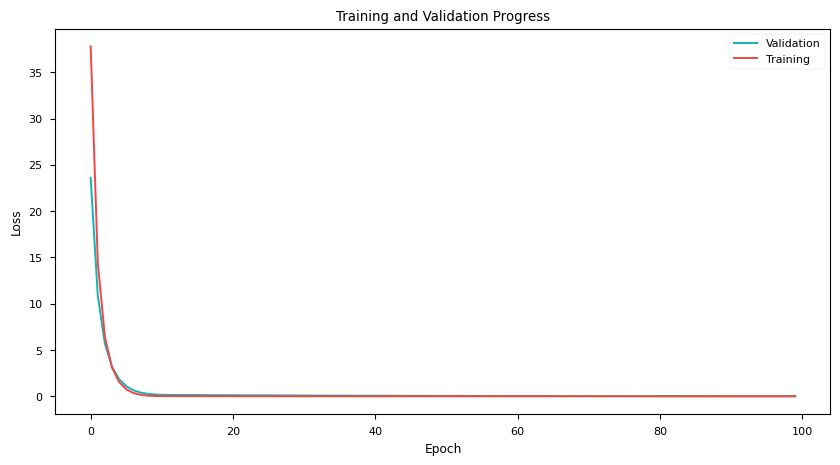

In [183]:
# 构造参数字典
params3 = {
    "train_loader": train_loader,
    "valid_loader": valid_loader,
    "n_epochs": 100,
    "verbose": True,
    "verbose": True,
}
model = train(**params3)

In [184]:
def predict(model, X_train, X_valid, X_test, y_train, y_valid, y_test, y_true, scaler):
    # 数据集长度
    train_size = len(X_train)
    valid_size = len(X_valid)
    test_size = len(X_test)
    
    # 时间序列形状
    timeseries_y = list(y_true.values.astype('float32').reshape(-1, ))
    timeseries_x = list(np.array(y_true.index).reshape(-1, ))
    
    # 检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 关闭自动求导功能
    with torch.no_grad():
        '''测试集设置'''
        X_train = X_train.to(device) # 将数据应用到GPU
        y_train = y_train.to(device)
        y_pred, encoded = model(X_train)
        y_pred = y_pred.cpu().detach().numpy() # 首先将张量移动到CPU，然后从计算图中分离，最后转换为NumPy数组
        y_pred = scaler.inverse_transform(y_pred) # 反归一化
        train_plot_y = y_pred[:, 0] # 0表示第一个输出
        train_plot_x = list(timeseries_x[: train_size])
        '''验证集设置'''
        X_valid = X_valid.to(device)
        y_valid = y_valid.to(device)
        y_pred, encoded = model(X_valid)
        y_pred = y_pred.cpu().detach().numpy()
        y_pred = scaler.inverse_transform(y_pred)
        valid_plot_y = y_pred[:, 0] # 0表示第一个输出
        valid_plot_x = timeseries_x[train_size: train_size+valid_size]
        '''测试集设置'''
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        y_pred, encoded = model(X_test)
        y_pred = y_pred.cpu().detach().numpy()
        y_pred = scaler.inverse_transform(y_pred)
        test_plot_y = y_pred[:, 0] # 0表示第一个输出
        test_plot_x = timeseries_x[train_size+valid_size: train_size+valid_size+test_size]
    return timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y

In [185]:
# 构造参数字典
params4 = {
    "model": model,
    "X_train": X_train,
    "X_valid": X_valid,
    "X_test": X_test,
    "y_train": y_train,
    "y_valid": y_valid,
    "y_test": y_test,
    "y_true": ts_data[['load']],
    "scaler": scaler,
}
timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y = predict(
    **params4)

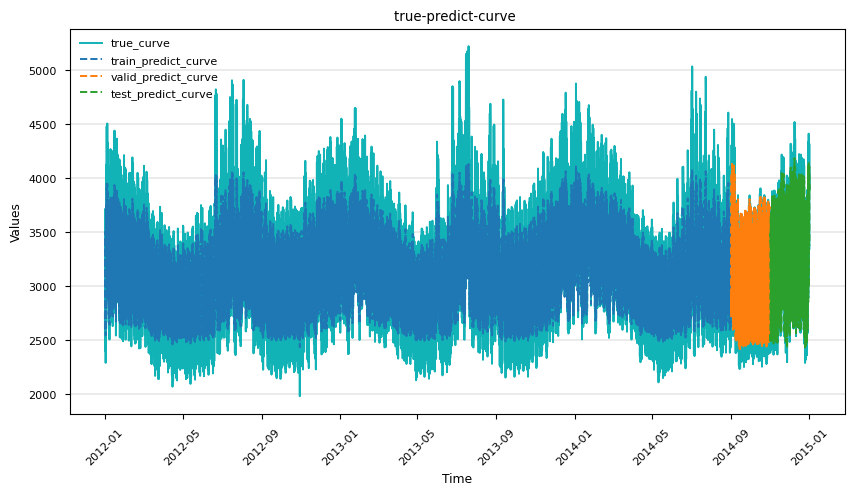

In [186]:
# 全局静态图
params5 = {
    "timeseries_x": timeseries_x,
    "timeseries_y": timeseries_y,
    "train_plot_x": train_plot_x,
    "train_plot_y": train_plot_y,
    "valid_plot_x": valid_plot_x,
    "valid_plot_y": valid_plot_y,
    "test_plot_x": test_plot_x,
    "test_plot_y": test_plot_y,
}
static_full_timeseries(**params5)

### 栈式自编码器

栈式自编码神经网络（Stacked Autoencoder）是一个由多层稀疏自编码器组成的神经网络，其前一层自编码器的输出作为其后一层自编码器的输入。

### 降噪自编码器

降噪自编码器就是输入换成了加噪的数据集，输出用原数据集去训练的自编码器，目的是习得降噪功能。

### 变分自编码器

变分自编码器的主要原理:

- 自编码器结构： VAE的核心是自编码器，它由一个编码器（Encoder）和一个解码器（Decoder）组成。编码器将输入数据映射到潜在空间中的分布参数，解码器则将潜在变量映射回输入空间。

- 潜在变量与分布： 与普通自编码器不同，VAE 引入了潜在变量（latent variable），用来表示输入数据的潜在结构。这些潜在变量的分布通常被建模为高斯分布。

- 损失函数： VAE的训练目标是最大化数据的边缘似然。这等效于最小化一个由两部分组成的损失函数：重构误差和潜在空间的正则项。重构误差确保生成的样本与原始输入相似，而正则项有助于确保潜在变量的分布接近预先定义的标准正态分布。

- 重参数化技巧： 为了能够在反向传播中估计梯度，VAE引入了重参数化技巧。通过这个技巧，潜在变量的采样过程变成可微的，从而可以使用梯度下降来优化模型参数。

- 生成新样本： 一旦训练完成，VAE 的解码器可以用来生成与训练数据类似的新样本。通过从潜在空间中采样，并将这些样本输入解码器，可以生成具有一定差异的新数据点。

变分自编码器（Variational Autoencoder，VAE）是一种深度学习模型，结合了自编码器和概率图模型的思想，用于学习时间序列数据的潜在表示。在时间序列数据上应用变分自编码器可以用于生成新的时间序列样本、降维和聚类，以及异常检测等任务。

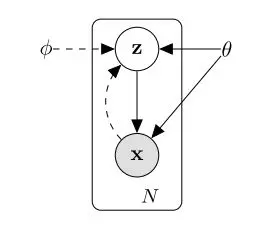

上图是VAE的图模型。我们能观测到的数据是$x$，而$x$由隐变量$z$产生，由$z->x$是生成模型$p_\theta(x|z)$，从自编码器（auto-encoder）的角度来看，就是解码器；而由$x->z$是识别模型（recognition model）$q_\phi(z|x)$，类似于自编码器的编码器。

怎么找出专属于$x$的正态分布$q_\phi(z|x)$的均值和方差呢？用神经网络来拟合出来。到这里，能知道专属于$x$的均值和方差了，也就知道它的正态分布长什么样了，然后从这个专属分布中采样一个$z$出来，然后经过一个生成器得到$\hat x$。

其实VAE还让所有的$q_\phi(z|x)$都向标准正态分布看齐，这样就防止了噪声为零，同时保证了模型具有生成能力。怎么理解“保证了生成能力”呢？如果所有的$q_\phi(z|x)$都很接近标准正态分布 N(0,I)，那么根据定义：
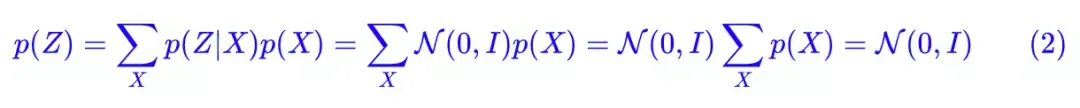
这样我们就能达到我们的先验假设：$p(z)$是标准正态分布。然后我们就可以放心地从 N(0,I) 中采样来生成数据了。

那怎么让所有的$q_\phi(z|x)$都向 N(0,I) 看齐呢？如果没有外部知识的话，其实最直接的方法应该是在重构误差的基础上中加入额外的 loss。
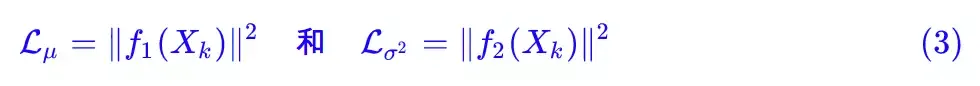
因为它们分别代表了均值$\mu$和方差的对数$\sigma^2$，达到 N(0,I) 就是希望二者尽量接近于0了。不过，这又会面临着这两个损失的比例要怎么选取的问题？原论文直接算了一般（各分量独立的）正态分布与标准正态分布的 KL 散度$KL(N(μ,σ^2)‖N(0,I))$作为这个额外的 loss。
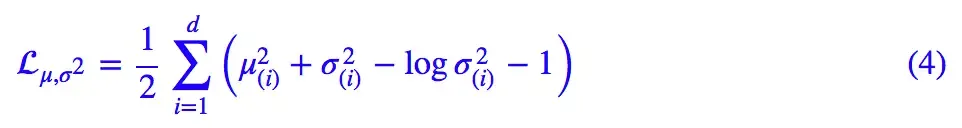

重新参数化意义：我们将从 $N(μ,σ^2)$ 采样变成了从 $N(0,1)$ 中采样，然后通过参数变换得到从$N(μ,σ^2)$ 中采样的结果。这样一来，“采样”这个操作就不用参与梯度下降了，改为采样的结果参与，使得整个模型可训练了。

在 VAE 中，通过最小化 KL 散度，模型试图使学到的潜在表示尽可能接近先验分布(标准正态分布)，从而使潜在空间更加规整。这有助于确保生成样本的潜在表示在整个潜在空间内均匀分布，提高模型的泛化性。